In [59]:
# %% Imports
import os
import pandas as pd
import xml.etree.ElementTree as ET
import datetime as dt
import sys



# %% Function Definitions

def preprocess_to_temp_file(file_path):

    print("Pre-processing and writing to temporary file...", end="")
    sys.stdout.flush()

    temp_file_path = "temp_preprocessed_export.xml"
    with open(file_path, 'r') as infile, open(temp_file_path, 'w') as outfile:
        skip_dtd = False
        for line in infile:
            if '<!DOCTYPE' in line:
                skip_dtd = True
            if not skip_dtd:
                line = strip_invisible_character(line)
                outfile.write(line)
            if ']>' in line:
                skip_dtd = False

    print("done!")
    return temp_file_path

def strip_invisible_character(line):
    return line.replace("\x0b", "")


def xml_to_csv(file_path):

    print("Converting XML File to CSV...", end="")
    sys.stdout.flush()

    attribute_list = []

    for event, elem in ET.iterparse(file_path, events=('end',)):
        if event == 'end':
            child_attrib = elem.attrib
            for metadata_entry in list(elem):
                metadata_values = list(metadata_entry.attrib.values())
                if len(metadata_values) == 2:
                    metadata_dict = {metadata_values[0]: metadata_values[1]}
                    child_attrib.update(metadata_dict)
            attribute_list.append(child_attrib)

            # Clear the element from memory to avoid excessive memory consumption
            elem.clear()

    health_df = pd.DataFrame(attribute_list)

    # Every health data type and some columns have a long identifer
    # Removing these for readability
    health_df.type = health_df.type.str.replace('HKQuantityTypeIdentifier', "")
    health_df.type = health_df.type.str.replace('HKCategoryTypeIdentifier', "")
    if 'creationDate' in health_df.columns:
        # Angenommen, die creationDate ist im ISO-Format oder einem anderen erkennbaren Format
        health_df['creationDate'] = pd.to_datetime(health_df['creationDate'])
        # Konvertiere und formatiere die creationDate
        health_df['creationDate'] = health_df['creationDate'].dt.strftime('%Y%m%d%H%M%S%z')
    health_df.columns = \
        health_df.columns.str.replace("HKCharacteristicTypeIdentifier", "")

    # Reorder some of the columns for easier visual data review
    original_cols = list(health_df)
    shifted_cols = ['type',
                    'sourceName',
                    'value',
                    'unit',
                    'startDate',
                    'endDate',
                    'creationDate']

    # Add loop specific column ordering if metadata entries exist
    if 'com.loopkit.InsulinKit.MetadataKeyProgrammedTempBasalRate' in original_cols:
        shifted_cols.append(
            'com.loopkit.InsulinKit.MetadataKeyProgrammedTempBasalRate')

    if 'com.loopkit.InsulinKit.MetadataKeyScheduledBasalRate' in original_cols:
        shifted_cols.append(
            'com.loopkit.InsulinKit.MetadataKeyScheduledBasalRate')

    if 'com.loudnate.CarbKit.HKMetadataKey.AbsorptionTimeMinutes' in original_cols:
        shifted_cols.append(
            'com.loudnate.CarbKit.HKMetadataKey.AbsorptionTimeMinutes')

    remaining_cols = list(set(original_cols) - set(shifted_cols))
    reordered_cols = shifted_cols + remaining_cols
    health_df = health_df.reindex(labels=reordered_cols, axis='columns')

    # Sort by newest data first
    health_df.sort_values(by='startDate', ascending=False, inplace=True)

    print("done!")

    return health_df


def save_to_csv(health_df):
    print("Saving CSV file...", end="")
    sys.stdout.flush()

    today = dt.datetime.now().strftime('%Y-%m-%d')
    health_df.to_csv("apple_health_export_cda_" + today + ".csv", index=False)
    print("done!")

    return

def remove_temp_file(temp_file_path):
    print("Removing temporary file...", end="")
    os.remove(temp_file_path)
    print("done!")
    
    return

def main():
    file_path = "/Users/tanjazast/Desktop/jupyter_folder/xml/export_cda_19.07.xml"
    temp_file_path = preprocess_to_temp_file(file_path)
    health_df = xml_to_csv(temp_file_path)
    save_to_csv(health_df)
    remove_temp_file(temp_file_path)

    return


# %%
if __name__ == '__main__':
    main()

Pre-processing and writing to temporary file...done!
Converting XML File to CSV...

AttributeError: 'DataFrame' object has no attribute 'type'

In [68]:
# Pfad zur CSV-Datei
file_path = '/Users/tanjazast/Desktop/jupyter_folder/csv/2024-07-18ExportTestRunsMiriam.csv'

# CSV-Datei einlesen
df = pd.read_csv(file_path)

# Nur die gewünschten Spalten behalten
columns_to_keep = ["user/age", "user/heightInCentimeters", "user/weightInKilogram", "user/gender", "id"]
df_filtered = df[columns_to_keep]

# Neue CSV-Datei speichern
output_file_path = 'Filtered_ExportTestRunsMiriam.csv'
df_filtered.to_csv(output_file_path, index=False)

In [61]:
import xml.etree.ElementTree as ET
import pandas as pd

# XML-Datei laden
tree = ET.parse('/Users/tanjazast/Desktop/jupyter_folder/xml/export_cda_19.07.xml')
root = tree.getroot()

# Namespaces definieren
ns = {
    'cda': 'urn:hl7-org:v3',
    'xsi': 'http://www.w3.org/2001/XMLSchema-instance'
}

# Datenextraktion
data = []
for observation in root.findall('.//cda:component/cda:observation', ns):
    patient_id = root.find('.//cda:recordTarget/cda:patientRole/cda:id', ns).attrib.get('root')
    gender = root.find('.//cda:recordTarget/cda:patientRole/cda:patient/cda:administrativeGenderCode', ns).attrib.get('code')
    birth_date = root.find('.//cda:recordTarget/cda:patientRole/cda:patient/cda:birthTime', ns).attrib.get('value')
    observation_id = observation.find('.//cda:id', ns).attrib.get('root')
    observation_type = 'Vital signs'
    code = observation.find('.//cda:code', ns).attrib.get('code')
    display_name = observation.find('.//cda:code', ns).attrib.get('displayName')
    effective_time = observation.find('.//cda:effectiveTime/cda:low', ns).attrib.get('value')

    # Extraktion von 'value' und 'unit' direkt aus dem <value> Element unter Berücksichtigung des xsi:Types
    value_element = observation.find('.//cda:value[@xsi:type="PQ"]', ns)
    if value_element is not None:
        measurement_value = value_element.attrib.get('value')
        unit = value_element.attrib.get('unit')
    else:
        measurement_value = None
        unit = None

    data.append([patient_id, gender, birth_date, observation_id, observation_type, code, display_name, measurement_value, unit, effective_time])

# Daten in ein DataFrame umwandeln
df = pd.DataFrame(data, columns=['PatientID', 'Gender', 'BirthDate', 'ObservationID', 'ObservationType', 'Code', 'DisplayName', 'MeasurementValue', 'Unit', 'EffectiveTime'])

# DataFrame in CSV umwandeln
csv_output_path = 'export_cda_19.07.xml.csv'
df.to_csv(csv_output_path, index=False)

# Hier mappen!!!!!!

In [63]:
import pandas as pd
import os

# Aktuelles Arbeitsverzeichnis ausgeben
print(os.getcwd())

# Pfade zu den CSV-Dateien
path1 = '/Users/tanjazast/Desktop/jupyter_folder/csv/apple_health_export_2024-03-29.csv'
path2 = '/Users/tanjazast/Desktop/jupyter_folder/csv/excel_6MWT_modified_2.csv'

# CSV-Dateien einlesen
df1 = pd.read_csv(path1, low_memory=False)
df2 = pd.read_csv(path2, low_memory=False)

# DataFrame df1 auf die ersten 74825 Zeilen beschränken
df1 = df1.iloc[:74825]

# Überprüfen, ob die Spaltennamen existieren
if 'startDate' not in df1.columns:
    raise ValueError("Spalte 'startDate' nicht in df1 gefunden")
if 'TimeStamp' not in df2.columns:
    raise ValueError("Spalte 'TimeStamp' nicht in df2 gefunden")

# Umwandlung der Werte in Spalte 'TimeStamp' in das gewünschte Format
df2['TimeStamp'] = df2['TimeStamp'].str.replace(r'(\+\d{2}):(\d{2})', r' \1\2', regex=True)

# Merge der beiden DataFrames basierend auf den Spalten 'startDate' und 'TimeStamp'
result_df = pd.merge(df1, df2, left_on='startDate', right_on='TimeStamp', how='left')

# Das Ergebnis in eine neue CSV-Datei speichern
output_path = 'gemappte_daten_crossEntropy.csv'
result_df.to_csv(output_path, index=False)

/Users/tanjazast/Desktop/jupyter_folder


FileNotFoundError: [Errno 2] No such file or directory: '/Users/tanjazast/Desktop/jupyter_folder/csv/apple_health_export_2024-03-29.csv'

In [20]:
import pandas as pd

# CSV-Datei einlesen
path = '/Users/tanjazast/Desktop/jupyter_folder/gemappte_daten_crossEntropy.csv'
df = pd.read_csv(path, low_memory=False)

# Zeilen identifizieren, bei denen zwei aufeinanderfolgende Werte der Spalte 'study ID' identisch sind
duplicate_indices = df[df['study ID'].shift() == df['study ID']].index

# Diese Zeilen löschen
df_cleaned = df.drop(duplicate_indices)

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'gemappte_daten_crossEntropy_cleaned.csv'
df_cleaned.to_csv(output_path, index=False)

In [21]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/gemappte_daten_crossEntropy_cleaned.csv')

df = df['study ID'].dropna()
print(df)

1348     738.0
2150     630.0
2708     670.0
3944     613.0
4726     620.0
         ...  
59095      5.0
59870      4.0
61553      1.0
62429      3.0
63068      2.0
Name: study ID, Length: 74, dtype: float64


/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_59963/1342944854.py:1: DtypeWarning: Columns (39,40,42,46,47,48,49,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/gemappte_daten_crossEntropy_cleaned.csv')


In [22]:
import pandas as pd

# CSV-Datei einlesen
path = '/Users/tanjazast/Desktop/jupyter_folder/csv/gemappte_daten_crossEntropy_cleaned.csv'
df = pd.read_csv(path, low_memory=False)

# Konvertierung der Spalten in Datetime-Objekte
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], format='%Y-%m-%d %H:%M:%S %z')
df['startDate'] = pd.to_datetime(df['startDate'], format='%Y-%m-%d %H:%M:%S %z')

# Funktion zum Erstellen von Intervallen und Filtern der Zeilen
def filter_by_interval(row, df):
    start_interval = row['TimeStamp']
    end_interval = start_interval + pd.Timedelta(minutes=10)
    mask = (df['startDate'] >= start_interval) & (df['startDate'] <= end_interval)
    return df[mask]

# Anwenden der Filterung auf das gesamte DataFrame
filtered_df = pd.DataFrame()
for index, row in df.iterrows():
    if pd.notna(row['TimeStamp']):
        filtered_rows = filter_by_interval(row, df)
        filtered_df = pd.concat([filtered_df, filtered_rows])

# Duplikate entfernen, da mehrere Intervalle gleiche Zeilen beinhalten können
filtered_df = filtered_df.drop_duplicates()

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'filtered_gemappte_daten.csv'
filtered_df.to_csv(output_path, index=False)

In [23]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/filtered_gemappte_daten.csv')

df = df['study ID'].dropna()
print(df)

513      738.0
830      630.0
1174     670.0
1596     613.0
1806     620.0
         ...  
32870      5.0
33324      4.0
33903      1.0
34493      3.0
35074      2.0
Name: study ID, Length: 74, dtype: float64


/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_59963/3881287102.py:1: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/filtered_gemappte_daten.csv')


In [69]:
import pandas as pd

# CSV-Datei einlesen
path = '/Users/tanjazast/Desktop/jupyter_folder/csv/apple_health_export_2024-07-19.csv'
df = pd.read_csv(path, low_memory=False)

# Alle unterschiedlichen Werte in der Spalte 'type' ausgeben
unique_types = df['type'].unique()

print("Unterschiedliche Werte in der Spalte 'type':")
for value in unique_types:
    print(value)

Unterschiedliche Werte in der Spalte 'type':
Height
BodyMass
StepCount
DistanceWalkingRunning
FlightsClimbed
WalkingStepLength
WalkingSpeed
WalkingDoubleSupportPercentage
WalkingAsymmetryPercentage
HeartRate
ActiveEnergyBurned
BasalEnergyBurned
PhysicalEffort
AppleExerciseTime
AppleStandTime
nan
AppleStandHour
EnvironmentalAudioExposure
StairDescentSpeed
TimeInDaylight
StairAscentSpeed
WalkingHeartRateAverage
OxygenSaturation
HeartRateVariabilitySDNN
RestingHeartRate
AppleWalkingSteadiness
HKWorkoutEventTypePause
HKWorkoutEventTypeMarker


In [71]:
import pandas as pd
import numpy as np

# CSV-Datei einlesen
path = '/Users/tanjazast/Desktop/jupyter_folder/csv/apple_health_export_2024-07-19.csv'
df = pd.read_csv(path, low_memory=False)

# Liste der zu löschenden Werte
values_to_delete = ['AppleStandTime', np.nan, 'AppleStandHour', 'TimeInDaylight']

# Zeilen löschen, in denen der Wert in der Spalte 'type' in values_to_delete ist
df_cleaned = df[~df['type'].isin(values_to_delete)]

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'cleaned_filtered_gemappte_daten-19.07.csv'
df_cleaned.to_csv(output_path, index=False)

In [99]:
import pandas as pd

# CSV-Datei einlesen
path = '/Users/tanjazast/Desktop/jupyter_folder/filtered_data_with_sums.csv'
df = pd.read_csv(path, low_memory=False)

# Spalte "startDate" in datetime umwandeln
df['startDate'] = pd.to_datetime(df['startDate'], format='%Y-%m-%d %H:%M:%S')

# Datumsschwelle festlegen und in die gleiche Zeitzone wie 'startDate' umwandeln
threshold_date = pd.Timestamp('2024-07-01', tz=df['startDate'].dt.tz)

# Zeilen löschen, in denen das Datum vor dem Schwellenwert liegt
df_filtered = df[df['startDate'] >= threshold_date]

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'filtered_data_3.0.csv'
df_filtered.to_csv(output_path, index=False)

In [97]:
path = '/Users/tanjazast/Desktop/jupyter_folder/csv/apple_health_export_2024-07-19.csv'
df = pd.read_csv(path, low_memory=False)

# Zeilen filtern, bei denen "sourceName" "Apple Watch von Rüdiger" oder "Health" ist
filtered_df = df[(df['sourceName'] == 'Apple Watch von Rüdiger') | (df['type'] == 'BodyMass') | (df['type'] == 'Height')]

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'filtered_data2.0.csv'
filtered_df.to_csv(output_path, index=False)

In [98]:
path = '/Users/tanjazast/Desktop/jupyter_folder/filtered_data2.0.csv'
df = pd.read_csv(path, low_memory=False)

# Spalte "startDate" in datetime umwandeln (falls benötigt)
# df['startDate'] = pd.to_datetime(df['startDate'], format='%Y-%m-%d %H:%M:%S')

# Initialisierungen
interval_start_index = None
active_energy_sum = 0
distance_walking_running_sum = 0
basal_energy_sum = 0

# Neue Spalten hinzufügen
df['ActiveEnergyBurned_Sum'] = 0
df['DistanceWalkingRunning_Sum'] = 0
df['BasalEnergyBurned_Sum'] = 0

# Durch die Zeilen des DataFrames iterieren
for i in range(len(df) - 1):
    if df.loc[i, 'type'] == 'Height':
        # Speichern des Startindex des Intervalls
        if interval_start_index is not None:
            # Summen in die Spalte eintragen, die am Anfang des Intervalls steht
            df.loc[interval_start_index, 'ActiveEnergyBurned_Sum'] = active_energy_sum
            df.loc[interval_start_index, 'DistanceWalkingRunning_Sum'] = distance_walking_running_sum
            df.loc[interval_start_index, 'BasalEnergyBurned_Sum'] = basal_energy_sum
            
            # Summen zurücksetzen
            active_energy_sum = 0
            distance_walking_running_sum = 0
            basal_energy_sum = 0
        
        # Setze den neuen Startindex
        interval_start_index = i
    
    # Addiere Werte für die Typen, die summiert werden sollen
    if df.loc[i, 'type'] == 'ActiveEnergyBurned':
        active_energy_sum += float(df.loc[i, 'value'])
    elif df.loc[i, 'type'] == 'DistanceWalkingRunning':
        distance_walking_running_sum += float(df.loc[i, 'value'])
    elif df.loc[i, 'type'] == 'BasalEnergyBurned':
        basal_energy_sum += float(df.loc[i, 'value'])

# Für das letzte Intervall, falls noch nicht gespeichert
if interval_start_index is not None:
    df.loc[interval_start_index, 'ActiveEnergyBurned_Sum'] = active_energy_sum
    df.loc[interval_start_index, 'DistanceWalkingRunning_Sum'] = distance_walking_running_sum
    df.loc[interval_start_index, 'BasalEnergyBurned_Sum'] = basal_energy_sum

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'filtered_data_with_sums.csv'
df.to_csv(output_path, index=False)

In [103]:
import pandas as pd

# CSV-Datei einlesen
path = '/Users/tanjazast/Desktop/jupyter_folder/csv/apple_health_export_2024-07-19.csv'
df = pd.read_csv(path, low_memory=False)

# Typen, die summiert werden sollen
types_to_sum = [
    'StepCount', 'AppleExerciseTime', 'PhysicalEffort', 'WalkingAsymmetryPercentage',
    'WalkingDoubleSupportPercentage', 'WalkingSpeed', 'WalkingStepLength', 'OxygenSaturation'
]

# Typen, die direkt übernommen werden sollen
types_to_keep = ['Height', 'BodyMass']

# Listen, um die Summen und Werte zu speichern
active_energy_values = []
basal_energy_values = []
distance_walking_running_values = []

# Neue Spalten hinzufügen
df['ActiveEnergyBurned_Sum'] = 0.0
df['DistanceWalkingRunning_Sum'] = 0.0
df['BasalEnergyBurned_Sum'] = 0.0

# Funktion zur Umwandlung von Werten in numerische Typen
def to_numeric(value):
    try:
        return float(value)
    except ValueError:
        return 0.0

# Umwandlung der Spalte 'value' in numerische Typen
df['value'] = df['value'].apply(to_numeric)

# Durch den DataFrame iterieren und Intervalle identifizieren
for i in range(len(df) - 1):
    if df.loc[i, 'type'] == 'Height' and df.loc[i + 1, 'type'] == 'BodyMass':
        interval_start_index = i
        
        # Initialisierung der Summen
        active_energy_sum = 0.0
        distance_walking_running_sum = 0.0
        basal_energy_sum = 0.0
        
        for j in range(i + 2, len(df)):
            if df.loc[j, 'type'] == 'Height':
                break
            if df.loc[j, 'type'] == 'ActiveEnergyBurned':
                active_energy_sum += df.loc[j, 'value']
            elif df.loc[j, 'type'] == 'DistanceWalkingRunning':
                distance_walking_running_sum += df.loc[j, 'value']
            elif df.loc[j, 'type'] == 'BasalEnergyBurned':
                basal_energy_sum += df.loc[j, 'value']
        
        # Summen in die entsprechenden Spalten schreiben
        df.loc[interval_start_index, 'ActiveEnergyBurned_Sum'] = active_energy_sum
        df.loc[interval_start_index, 'DistanceWalkingRunning_Sum'] = distance_walking_running_sum
        df.loc[interval_start_index, 'BasalEnergyBurned_Sum'] = basal_energy_sum

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'filtered_data_with_sums.csv'
df.to_csv(output_path, index=False)

print(f"Die gefilterte Datei wurde unter {output_path} gespeichert.")


Die gefilterte Datei wurde unter filtered_data_with_sums.csv gespeichert.


In [101]:
import pandas as pd

# CSV-Datei einlesen
path = '/Users/tanjazast/Desktop/jupyter_folder/csv/apple_health_export_2024-07-19.csv'
df = pd.read_csv(path, low_memory=False)

types_to_sum = [
    'StepCount', 'AppleExerciseTime', 'PhysicalEffort', 'WalkingAsymmetryPercentage',
    'WalkingDoubleSupportPercentage', 'WalkingSpeed', 'WalkingStepLength', 'OxygenSaturation'
]

# Typen, die direkt übernommen werden sollen
types_to_keep = ['Height', 'BodyMass']

# Initialisierungen
interval_start_index = 0
sums = {type_name: 0 for type_name in types_to_sum}
kept_values = {type_name: None for type_name in types_to_keep}
heart_rate_values = []
active_energy_values = []
basal_energy_values = []
distance_walking_running_values = []

# DataFrame für die Summen pro Intervall vorbereiten
sum_df = pd.DataFrame()

# Funktion zum Speichern der Summen und Zurücksetzen
def save_interval_sums(start_idx, end_idx, interval_sums, interval_kept, heart_rates, active_energy, basal_energy, distance_walking_running):
    global sum_df
    interval_data = df.iloc[start_idx:end_idx + 1].copy()
    interval_sums_df = pd.DataFrame([interval_sums])
    interval_kept_df = pd.DataFrame([interval_kept])
    
    # Erstellen von DataFrames für die Listen
    heart_rate_df = pd.DataFrame([heart_rates], columns=[f'HeartRate_{i+1}' for i in range(len(heart_rates))])
    active_energy_df = pd.DataFrame([active_energy], columns=[f'ActiveEnergyBurned_{i+1}' for i in range(len(active_energy))])
    basal_energy_df = pd.DataFrame([basal_energy], columns=[f'BasalEnergyBurned_{i+1}' for i in range(len(basal_energy))])
    distance_walking_running_df = pd.DataFrame([distance_walking_running], columns=[f'DistanceWalkingRunning_{i+1}' for i in range(len(distance_walking_running))])
    
    interval_sums_df['start_index'] = start_idx
    interval_sums_df['end_index'] = end_idx
    
    # Behalte alle Spalten ab 'study ID' bis 'Steps'
    columns_to_keep = df.columns[df.columns.get_loc('type'):df.columns.get_loc('creationDate')+1]
    interval_sums_df = pd.concat([
        interval_sums_df, interval_kept_df, heart_rate_df, active_energy_df,
        basal_energy_df, distance_walking_running_df, interval_data[columns_to_keep].iloc[0:1].reset_index(drop=True)
    ], axis=1)
    
    sum_df = pd.concat([sum_df, interval_sums_df], ignore_index=True)
    for key in interval_sums.keys():
        interval_sums[key] = 0
    for key in interval_kept.keys():
        interval_kept[key] = None
    heart_rates.clear()
    active_energy.clear()
    basal_energy.clear()
    distance_walking_running.clear()

# Durch die Zeilen des DataFrames iterieren und Intervalle identifizieren
for i, row in df.iterrows():
    if pd.notna(row['type']):
        save_interval_sums(interval_start_index, i - 1, sums, kept_values, heart_rate_values, active_energy_values, basal_energy_values, distance_walking_running_values)
        interval_start_index = i

    # Wenn der `type`-Eintrag summiert werden soll
    if row['type'] in types_to_sum:
        try:
            sums[row['type']] += float(row['value']) 
        except ValueError:
            print(f"Skipping non-numeric value: {row['value']} for type: {row['type']}")
    
    # Wenn der `type`-Eintrag direkt übernommen werden soll
    if row['type'] in types_to_keep:
        kept_values[row['type']] = row['value']  # Wert direkt übernehmen

    # Wenn der `type`-Eintrag 'HeartRate' ist
    if row['type'] == 'HeartRate':
        heart_rate_values.append(row['value'])  # Wert zur Liste hinzufügen
    
    if row['type'] == 'ActiveEnergyBurned':
        active_energy_values.append(row['value'])  # Wert zur Liste hinzufügen
    
    if row['type'] == 'DistanceWalkingRunning':
        distance_walking_running_values.append(row['value'])  # Wert zur Liste hinzufügen
    
    if row['type'] == 'BasalEnergyBurned':
        basal_energy_values.append(row['value'])  # Wert zur Liste hinzufügen

# Letztes Intervall speichern, wenn es nicht leer ist
if interval_start_index < len(df):
    save_interval_sums(interval_start_index, len(df) - 1, sums, kept_values, heart_rate_values, active_energy_values, basal_energy_values, distance_walking_running_values)

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'summed_intervals.csv'
sum_df.to_csv(output_path, index=False)

Die gefilterte Datei wurde unter filtered_data_with_sums.csv gespeichert.


In [76]:
path = '/Users/tanjazast/Desktop/jupyter_folder/cleaned_summed_renamed_intervals.csv'
df = pd.read_csv(path, low_memory=False)


# Identifikation der Spalten von "study ID" bis "Steps"
columns_to_shift = df.loc[:, 'study ID':'Steps'].columns

# Die Spalten von "study ID" bis "Steps" ans Ende der Tabelle verschieben
remaining_columns = df.columns.difference(columns_to_shift)
df = df[remaining_columns.tolist() + columns_to_shift.tolist()]

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'summed_intervals2.csv'
df.to_csv(output_path, index=False)

In [71]:
path = '/Users/tanjazast/Desktop/jupyter_folder/summed_intervals.csv'
df = pd.read_csv(path, low_memory=False)

# Überprüfen, ob die Spalte "99" existiert
if '99' in df.columns:
    # Ermitteln des Index der Spalte "99"
    column_index = df.columns.get_loc('Steps')   # +1, um auf 1-basierten Index zu ändern
    print(f'Die Spalte "99" ist die {column_index}. Spalte in der Tabelle.')
else:
    print('Die Spalte "99" existiert nicht in der Tabelle.')

Die Spalte "99" ist die 509. Spalte in der Tabelle.


In [76]:
import pandas as pd

# CSV-Datei einlesen
path = '/Users/tanjazast/Desktop/jupyter_folder/cleaned_filtered_gemappte_daten-19.07.csv'
df = pd.read_csv(path, low_memory=False)

def determine_column_name(values):
    counts = {'ActiveEnergyBurned': 0, 'BasalEnergyBurned': 0, 'DistanceWalkingRunning': 0, 'HeartRate': 0}
    
    for value in values:
        if isinstance(value, str):
            value = value.replace(',', '.')
        try:
            value = float(value)
        except ValueError:
            continue
        
        if 0.1 < value < 10:  # 0,x (ohne null nach Komma)
            counts['ActiveEnergyBurned'] += 1
        elif 0.1 > value > 0.01:  # 0,0x (mit einer Null nach Komma)
            counts['BasalEnergyBurned'] += 1
        elif 0.01 > value > 0:  # 0,00x (mit zwei Nullen nach Komma)
            counts['DistanceWalkingRunning'] += 1
        elif value >= 10.0 and value < 100.0:  # XX,xx (zwei Ziffern vor dem Komma)
            counts['HeartRate'] += 1
    
    if all(v == 0 for v in counts.values()):
        return None
    
    return max(counts, key=counts.get)

# Durchlaufe alle Spalten von "0" bis "99"
for col in df.columns:
    if col.isdigit() and 0 <= int(col) <= 1101:
        new_column_name = determine_column_name(df[col])
        if new_column_name:
            df.rename(columns={col: new_column_name}, inplace=True)


output_path = 'renamed_summed_intervals.csv'
df.to_csv(output_path, index=False)

In [78]:
path = '/Users/tanjazast/Desktop/jupyter_folder/renamed_summed_intervals.csv'
df = pd.read_csv(path, low_memory=False)

# Summen für jede Zeile berechnen und als neue Spalten hinzufügen
df['Sum_ActiveEnergyBurned'] = df.filter(like='ActiveEnergyBurned').sum(axis=1)
df['Sum_BasalEnergyBurned'] = df.filter(like='BasalEnergyBurned').sum(axis=1)
df['Sum_DistanceWalkingRunning'] = df.filter(like='DistanceWalkingRunning').sum(axis=1)

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'summed_renamed_intervals-19-07.csv'
df.to_csv(output_path, index=False)

In [77]:
path = '/Users/tanjazast/Desktop/jupyter_folder/summed_renamed_intervals-19.07.csv'
df = pd.read_csv(path, low_memory=False)

# Spalten löschen, die mit 'ActiveEnergyBurned', 'BasalEnergyBurned' oder 'DistanceWalkingRunning' beginnen
columns_to_drop = df.columns[df.columns.str.startswith(('ActiveEnergyBurned', 'BasalEnergyBurned', 'DistanceWalkingRunning'))]
df.drop(columns=columns_to_drop, inplace=True)

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'cleaned_summed_renamed_intervals.csv'
df.to_csv(output_path, index=False)

In [78]:
import pandas as pd

# CSV-Datei einlesen
path = '/Users/tanjazast/Desktop/jupyter_folder/cleaned_summed_renamed_intervals.csv'
df = pd.read_csv(path, low_memory=False)

# Spalten von "study ID" bis "Steps" identifizieren
columns_to_shift = df.loc[:, 'study ID':'Steps'].columns

# Einträge in diesen Spalten um eine Zeile nach oben verschieben
df[columns_to_shift] = df[columns_to_shift].shift(-1)

# Letzte Zeile der Tabelle löschen
df = df[:-1]

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'processed_cleaned_summed_renamed_intervals.csv'
df.to_csv(output_path, index=False)

In [79]:
import pandas as pd

# CSV-Datei einlesen
path = '/Users/tanjazast/Desktop/jupyter_folder/processed_cleaned_summed_renamed_intervals.csv'
df = pd.read_csv(path, low_memory=False)

# Spalten von 'study ID' bis 'Steps' identifizieren
columns_to_move = df.loc[:, 'study ID':'Steps'].columns

# Spalten 'Height' und 'BodyMass' löschen
df.drop(columns=['Height', 'BodyMass'], inplace=True)

# Spalten von 'study ID' bis 'Steps' ans Ende verschieben
remaining_columns = df.drop(columns=columns_to_move).columns
df = df[remaining_columns.tolist() + columns_to_move.tolist()]

df.loc[1:, columns_to_move] = df.loc[1:, columns_to_move].values

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'modified_summed_intervals.csv'
df.to_csv(output_path, index=False)

In [147]:
path_main = '/Users/tanjazast/Desktop/jupyter_folder/csv/modified_summed_intervals.csv'
path_secondary = '/Users/tanjazast/Desktop/jupyter_folder/csv/final_updated_data_23.05.csv'

df_main = pd.read_csv(path_main, low_memory=False)
df_secondary = pd.read_csv(path_secondary, low_memory=False)

# Spalten, die übernommen werden sollen
columns_to_merge = [
    'RR_before_systolic', 'RR_before_diastolic', 'RR_after_systolic', 'RR_after_diastolic',
    'RR_before_category', 'RR_after_category', 'RR_before_category_num', 'RR_after_category_num',
    'Subject_Patient_Number', 'RR_before', 'RR_after', 'HR_before', 'HR_after', 'gender', 'real_Distance', 'BMI', 'BMI_Over_25'
]

# Merge der beiden DataFrames basierend auf 'study ID'
df_merged = pd.merge(df_main, df_secondary[['study ID'] + columns_to_merge], on='study ID', how='left')

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'merged_processed_final_data.csv'
df_merged.to_csv(output_path, index=False)

In [148]:
path = '/Users/tanjazast/Desktop/jupyter_folder/merged_processed_final_data.csv'
df = pd.read_csv(path, low_memory=False)

# Löschen aller Zeilen, bei denen in der Spalte 'RR_before' nichts steht (NaN-Werte)
df_cleaned = df.dropna(subset=['RR_before'])

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'cleaned_merged_processed_final_data_07.06.csv'
df_cleaned.to_csv(output_path, index=False)

In [149]:
path = '/Users/tanjazast/Desktop/jupyter_folder/cleaned_merged_processed_final_data_07.06.csv'
df = pd.read_csv(path, low_memory=False)

# Löschen aller Zeilen, in denen in der Spalte "StepCount" der Wert "0.0" steht
df = df[df['StepCount'] != 0.0]

# Identifikation der Spalten von "HeartRate_110" bis "HeartRate_216"
columns_to_drop = [f'HeartRate_{i}' for i in range(110, 217)]

# Löschen der identifizierten Spalten
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'final_data_07.06.csv'
df.to_csv(output_path, index=False)

In [ ]:
import pandas as pd

# Load the CSV file
data = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/mapped_data.csv')


# Define simple heuristic thresholds for gender determination
height_threshold = 165  # cm
weight_threshold = 80   # kg
heart_rate_threshold = 90  # bpm, average resting heart rate is higher for females

gender_estimations = pd.DataFrame()

for index, row in data.iterrows():
    # Initialize gender as Unknown for each row
    #gender = 'Unknown'

    # Check the measurement type and apply the threshold to estimate gender
    if row['DisplayName'] == 'Height' and row['MeasurementValue'] > height_threshold and row['DisplayName'] == 'Body weight Measured' and row['MeasurementValue'] > weight_threshold:
        gender = 'Male'
    elif row['DisplayName'] == 'Body weight Measured' and row['MeasurementValue'] > weight_threshold:
        gender = 'Male'
    elif row['DisplayName'] == 'Heart rate' and row['MeasurementValue'] < heart_rate_threshold:
        gender = 'Female'

    # Append to our DataFrame
    gender_estimations = gender_estimations.append({
        'PatientID': row['PatientID'],
        'BirthDate': row['BirthDate'],
        'ObservationID': row['ObservationID'],
        'Code': row['Code'],
        'DisplayName': row['DisplayName'],
        'MeasurementValue': row['MeasurementValue'],
        'Unit': row['Unit'],
        'type': row['type'],
        'value': row['value'],
        'unit': row['unit'],
        'creationDate': row['creationDate'],
        'EstimatedGender': gender
    }, ignore_index=True)

# Remove duplicate CreationDate entries by keeping the last entry which has the gender estimation
gender_estimations.drop_duplicates(subset='creationDate', keep='last', inplace=True)

# Save the results to a CSV file
output_file_path = 'gender_estimation.csv'
gender_estimations.to_csv(output_file_path, index=False)

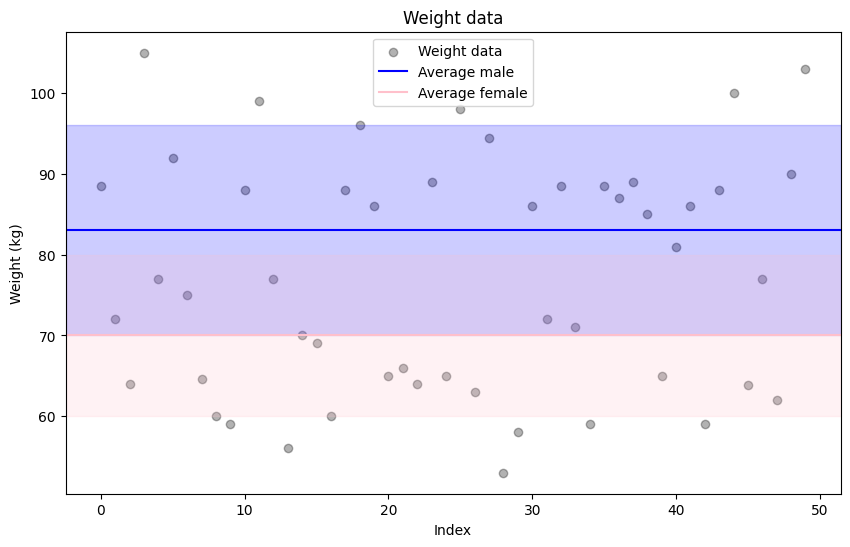

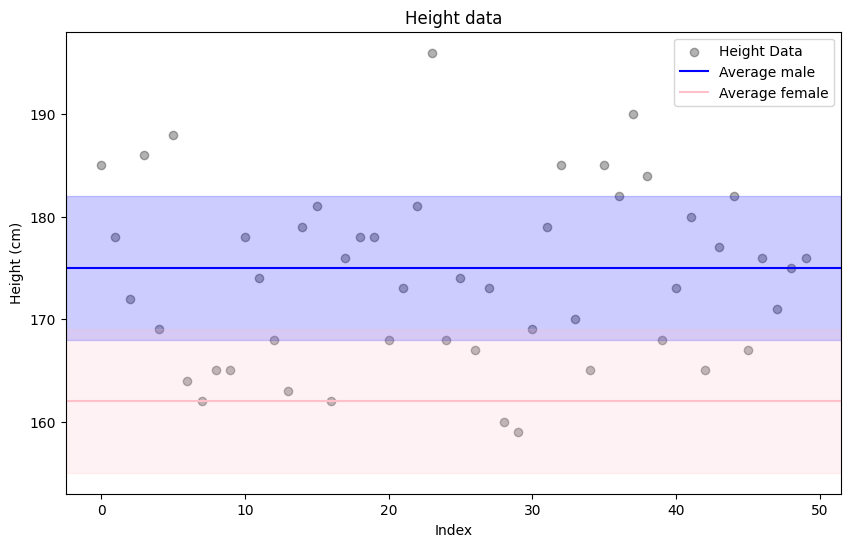

In [179]:
import matplotlib.pyplot as plt

data = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/cleaneddata_with_bmi_flag.csv')

# Durchschnitt und Standardabweichung für Männer und Frauen
average_weight_male = 83
std_dev_weight_male = 13
average_weight_female = 70
std_dev_weight_female = 10

plt.figure(figsize=(10, 6))

# Plotte Körpergewicht-Datenpunkte
plt.scatter(data['weight (kg)'].index, data['weight (kg)'], alpha=0.3, color = 'black', label='Weight data')

# Zeichne die Durchschnittslinien und Standardabweichungen für Gewicht
plt.axhline(y=average_weight_male, color='blue', linestyle='-', label='Average male')
plt.axhline(y=average_weight_female, color='pink', linestyle='-', label='Average female')
plt.axhspan(average_weight_male - std_dev_weight_male, average_weight_male + std_dev_weight_male, color='blue', alpha=0.2)
plt.axhspan(average_weight_female - std_dev_weight_female, average_weight_female + std_dev_weight_female, color='pink', alpha=0.2)

plt.xlabel('Index')
plt.ylabel('Weight (kg)')
plt.title('Weight data')
plt.legend()
plt.savefig('ratio_average_weight.png')
plt.show()

# Durchschnitt und Standardabweichung für Größe
average_height_male = 175
std_dev_height_male = 7
average_height_female = 162
std_dev_height_female = 7

# Plot für Körpergröße
plt.figure(figsize=(10, 6))

# Plotte Körpergröße-Datenpunkte
plt.scatter(data['height (cm)'].index, data['height (cm)'], alpha=0.3, color = 'black', label='Height Data')

# Zeichne die Durchschnittslinien und Standardabweichungen für Größe
plt.axhline(y=average_height_male, color='blue', linestyle='-', label='Average male')
plt.axhline(y=average_height_female, color='pink', linestyle='-', label='Average female')
plt.axhspan(average_height_male - std_dev_height_male, average_height_male + std_dev_height_male, color='blue', alpha=0.2)
plt.axhspan(average_height_female - std_dev_height_female, average_height_female + std_dev_height_female, color='pink', alpha=0.2)

plt.xlabel('Index')
plt.ylabel('Height (cm)')
plt.title('Height data')
plt.legend()
plt.savefig('ratio_average_height.png')
plt.show()


In [179]:
df_1 = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/6MWT_week1.csv')
df_2 = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/6MWT_week2.csv')
df_3 = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/6MWT_week3.csv')
df_4 = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/6MWT_week4.csv')

# Anpassen der DataFrames
df1_cut = df_1.iloc[:26, df_1.columns.get_loc("Unnamed: 0"):df_1.columns.get_loc("Unnamed: 28")+1]
df2_cut = df_2.iloc[2:32, df_2.columns.get_loc("Unnamed: 0"):df_2.columns.get_loc("Unnamed: 36")+1]
df3_cut = df_3.iloc[2:31, 0:df_3.columns.get_loc("Unnamed: 39")+1]
df4_cut = df_4.iloc[2:18, 0:df_4.columns.get_loc("Unnamed: 36")+1]

# Zusammenführen der angepassten DataFrames untereinander
df_concatenated = pd.concat([df1_cut, df2_cut, df3_cut, df4_cut], axis=0)

# Speichern des zusammengeführten DataFrames
csv_output = 'excel_6MWT_concatenated.csv'
df_concatenated.to_csv(csv_output, index=False)


0     Basic data
1       study ID
2           0001
3           0039
4           0040
5           0041
6           0042
7           0043
8           0044
9           0030
10          0045
11          0001
12          0046
13          0047
14          0011
15          0001
16          0048
17          0001
18          0049
19          0050
20          0051
21          0052
22          0053
23          0054
24          0055
25          0001
26          0056
27          0057
28          0058
29          0059
30          0060
31           NaN
32           NaN
33           NaN
34           NaN
35           NaN
36           NaN
37           NaN
38           NaN
Name:    , dtype: object


In [189]:
file_path = '/Users/tanjazast/Desktop/jupyter_folder/csv/excel_6MWT_concatenated.csv'

# Tabelle einlesen
df = pd.read_csv(file_path)

df.rename(columns={"   ": "Unnamed: ID"}, inplace=True)
print(df.columns)

values_to_move = df.iloc[56:100, df.columns.get_loc("Unnamed: 19")]

df.loc[56:99, "Unnamed: 0"] = values_to_move.values

index_of_id = df.columns.get_loc("Unnamed: 19") + 1  # +1, weil wir ab der nächsten Spalte löschen wollen

# Entferne alle Spalten ab diesem Index
df = df.iloc[:, :index_of_id]

output_path = 'excel_6MWT_modified.csv'
df.to_csv(output_path, index=False)

Index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Calibration', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Classic 6MWT', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Mobile Devices', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25',
       'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29',
       'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33',
       'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: ID',
       'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39'],
      dtype='object')


In [198]:
file_path = '/Users/tanjazast/Desktop/jupyter_folder/csv/mapped_modified.csv'

# Tabelle einlesen
df = pd.read_csv(file_path)

index_of_id = df.columns.get_loc("endDate") + 1  # +1, weil wir ab der nächsten Spalte löschen wollen

# Entferne alle Spalten ab diesem Index
df = df.iloc[:, :index_of_id]

output_path = 'mapped_modified.csv'
df.to_csv(output_path, index=False)

In [154]:
df_mapped_data = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/xml/mapped_data.csv')

# Filtere die Zeilen, in denen in der Spalte "type" der Wert "HeartRate" steht
df_heart_rate = df_mapped_data[df_mapped_data['type'] == 'HeartRate']

# Speichere die gefilterten Zeilen in eine neue CSV-Datei
df_heart_rate.to_csv('heart_rate_data_mod.csv', index=False)

In [155]:
df_mapped_data = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/xml/heart_rate_data_mod.csv')

# Sortiere den DataFrame nach der Spalte "creationDate" absteigend
df_sorted = df_mapped_data.sort_values(by='creationDate', ascending=False)

# Speichere den sortierten DataFrame in eine neue Datei, falls notwendig
df_sorted.to_csv('heart_rate_sorted.csv', index=False)

In [172]:
print(os.getcwd())

/Users/tanjazast/Desktop/jupyter_folder/xml


In [30]:
#### nun möchte ich hier die 6minuten (hopefully) herausfinden

import pandas as pd

file_path = '/Users/tanjazast/Desktop/jupyter_folder/csv/mapped_data.csv'

# Laden der Daten und Konvertierung des Datumsformats
df = pd.read_csv(file_path, parse_dates=['creationDate'])
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# Entfernen von Zeilen mit NaN-Werten in der 'value'-Spalte, um die gleiche Datenlänge sicherzustellen
df = df.dropna(subset=['value'])
#print(df['creationDate'])

# Korrektur der Datumsangaben
start_date = '20240216'
end_date = '20240217' 

# Filtern der Daten im 6-Minuten-Intervall
data_6MW = df[(df['creationDate'] >= start_date) & (df['creationDate'] <= end_date)]

# Daten in ein DataFrame umwandeln
df = pd.DataFrame(data_6MW)

# DataFrame in CSV umwandeln
csv_output_path = '16.02.xml.csv'
df.to_csv(csv_output_path, index=False)

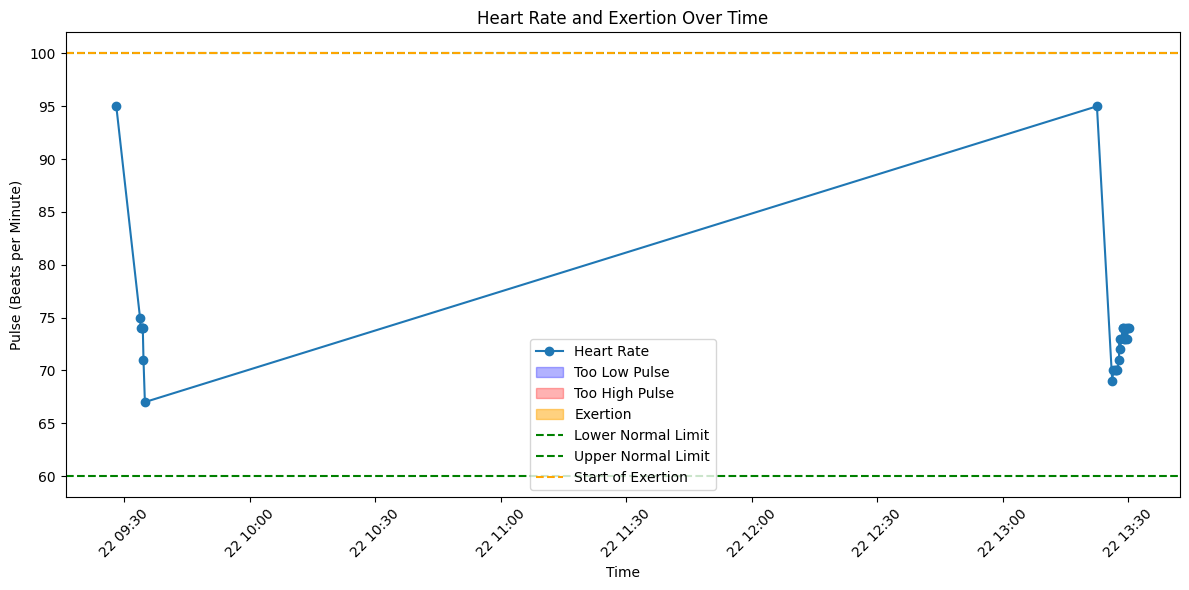

In [22]:
# Normal pulse range and the threshold for exertion

import matplotlib.pyplot as plt

normal_pulse_lower = 60
normal_pulse_upper = 100
effort_pulse = 100  # Start of the range considered as exertion

# Plot all heart rate values
plt.figure(figsize=(12, 6))
plt.plot(data_6MW['creationDate'], data_6MW['value'], label='Heart Rate', marker='o', linestyle='-')

# Highlight areas with too low pulse
plt.fill_between(data_6MW['creationDate'], data_6MW['value'], normal_pulse_lower, where=(data_6MW['value'] < normal_pulse_lower),
                 color='blue', alpha=0.3, label='Too Low Pulse')

# Highlight areas with too high pulse
plt.fill_between(data_6MW['creationDate'], data_6MW['value'], normal_pulse_upper, where=(data_6MW['value'] > normal_pulse_upper) & (data_6MW['value'] <= effort_pulse),
                 color='red', alpha=0.3, label='Too High Pulse')

# Highlight areas of exertion
plt.fill_between(data_6MW['creationDate'], data_6MW['value'], effort_pulse, where=(data_6MW['value'] > effort_pulse),
                 color='orange', alpha=0.5, label='Exertion')

# Optionally: Add horizontal lines for the normal pulse range and exertion
plt.axhline(normal_pulse_lower, color='green', linestyle='--', label='Lower Normal Limit')
plt.axhline(normal_pulse_upper, color='green', linestyle='--', label='Upper Normal Limit')
plt.axhline(effort_pulse, color='orange', linestyle='--', label='Start of Exertion')

# Adjustments for presentation
plt.xlabel('Time')
plt.ylabel('Pulse (Beats per Minute)')
plt.title('Heart Rate and Exertion Over Time')
plt.legend()
plt.xticks(rotation=45)  # Rotate the X-axis labels for better readability
plt.tight_layout()
plt.savefig('6MW_dataset_plot_22_02.png')
# Show the plot
plt.show()

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Pfad zur Datei
file_path = '/Users/tanjazast/Desktop/jupyter_folder/xml/heart_rate_sorted.csv'

# Daten laden und Datumsformat konvertieren
df = pd.read_csv(file_path, parse_dates=['creationDate'])
df['value'] = pd.to_numeric(df['value'], errors='coerce')
df = df.dropna(subset=['value'])

# Normalpulsbereich und Schwelle zur Anstrengung
normal_pulse_lower = 60
normal_pulse_upper = 100
effort_pulse = 100  # Beginn des Bereichs, der als Anstrengung betrachtet wird

# Extrahiere das Datum (ohne Uhrzeit) für die Gruppierung
df['date'] = df['creationDate'].dt.date

# Gruppiere die Daten nach dem extrahierten Datum
grouped = df.groupby('date')

for date, group in grouped:
    plt.figure(figsize=(12, 6))
    plt.plot(group['creationDate'], group['value'], label='Heart Rate', marker='o', linestyle='-')
    
    # Highlight-Bereiche wie im ursprünglichen Beispiel
    plt.fill_between(group['creationDate'], group['value'], normal_pulse_lower, where=(group['value'] < normal_pulse_lower), color='blue', alpha=0.3, label='Too Low Pulse')
    plt.fill_between(group['creationDate'], group['value'], normal_pulse_upper, where=(group['value'] > normal_pulse_upper) & (group['value'] <= effort_pulse), color='red', alpha=0.3, label='Too High Pulse')
    plt.fill_between(group['creationDate'], group['value'], effort_pulse, where=(group['value'] > effort_pulse), color='orange', alpha=0.5, label='Exertion')
    
    plt.axhline(normal_pulse_lower, color='green', linestyle='--', label='Lower Normal Limit')
    plt.axhline(normal_pulse_upper, color='green', linestyle='--', label='Upper Normal Limit')
    plt.axhline(effort_pulse, color='orange', linestyle='--', label='Start of Exertion')
    
    # Anpassungen für die Präsentation
    plt.xlabel('Time')
    plt.ylabel('Pulse (Beats per Minute)')
    plt.title(f'Heart Rate and Exertion Over Time on {date}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Speichere den Plot für jeden Tag
    plt.savefig(f'heart_rate_plot_{date}.png')
    plt.close()

In [42]:
df_data = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/mapped_data.csv')

df_distance = df_data[df_data['type'] == 'DistanceWalkingRunning']

# Speichere die gefilterten Zeilen in eine neue CSV-Datei
df_distance.to_csv('distance_data_all.csv', index=False)

In [73]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/distance_data_all.csv')

df = df.drop_duplicates(subset='creationDate')

df['creationDate'] = pd.to_datetime(df['creationDate'])

# Berechne die Differenz zwischen aufeinanderfolgenden 'creationDate'-Werten
df['time_diff'] = df['creationDate'].diff()
print(df['time_diff'])

# Initialisiere eine neue Spalte für die kumulierten Werte
df['value'] = df['value']*1000
df['cumulative_value'] = df['value']
print(df['cumulative_value'])

# Gehe durch die DataFrame-Zeilen und summiere die 'value'-Werte, wenn die 'time_diff' weniger als eine Minute beträgt
for i in range(1, len(df)):
    if df.iloc[i]['time_diff'] < pd.Timedelta(minutes=3):
        df.at[i, 'cumulative_value'] = (df.iloc[i-1]['cumulative_value'] + df.iloc[i]['value'])
    else:
        df.at[i, 'cumulative_value'] = df.iloc[i]['value']

# Zeige das Ergebnis
print(df[['creationDate', 'value', 'cumulative_value']])
df[['creationDate', 'cumulative_value']].to_csv('distance_data_all_new.csv', index=False)

0                     NaT
2      -26 days +02:41:47
3         0 days 01:42:28
4         0 days 00:00:02
5         0 days 00:00:26
              ...        
2418      0 days 00:00:06
2419      0 days 00:00:07
2420      0 days 00:00:11
2421      0 days 00:00:05
2422      0 days 00:00:10
Name: time_diff, Length: 2374, dtype: timedelta64[ns]
0       346.160
2        42.330
3         1.411
4         2.822
5         4.233
         ...   
2418      5.580
2419      5.460
2420      5.640
2421      5.640
2422      0.060
Name: cumulative_value, Length: 2374, dtype: float64
                  creationDate    value  cumulative_value
0    2024-03-13 09:56:12+01:00  346.160           346.160
2    2024-02-16 12:37:59+01:00   42.330             1.411
3    2024-02-16 14:20:27+01:00    1.411             4.233
4    2024-02-16 14:20:29+01:00    2.822             7.055
5    2024-02-16 14:20:55+01:00    4.233             7.055
...                        ...      ...               ...
2349                     

Cumulative Distance Values for Week 8:
creationDate
2024-02-19 23:02:24+01:00     95.5100
2024-02-19 23:18:13+01:00    108.1400
2024-02-20 10:36:17+01:00    113.8100
2024-02-20 11:17:27+01:00    144.7400
2024-02-20 11:57:14+01:00    130.1900
2024-02-22 13:22:28+01:00    654.4015
Name: cumulative_value, dtype: float64


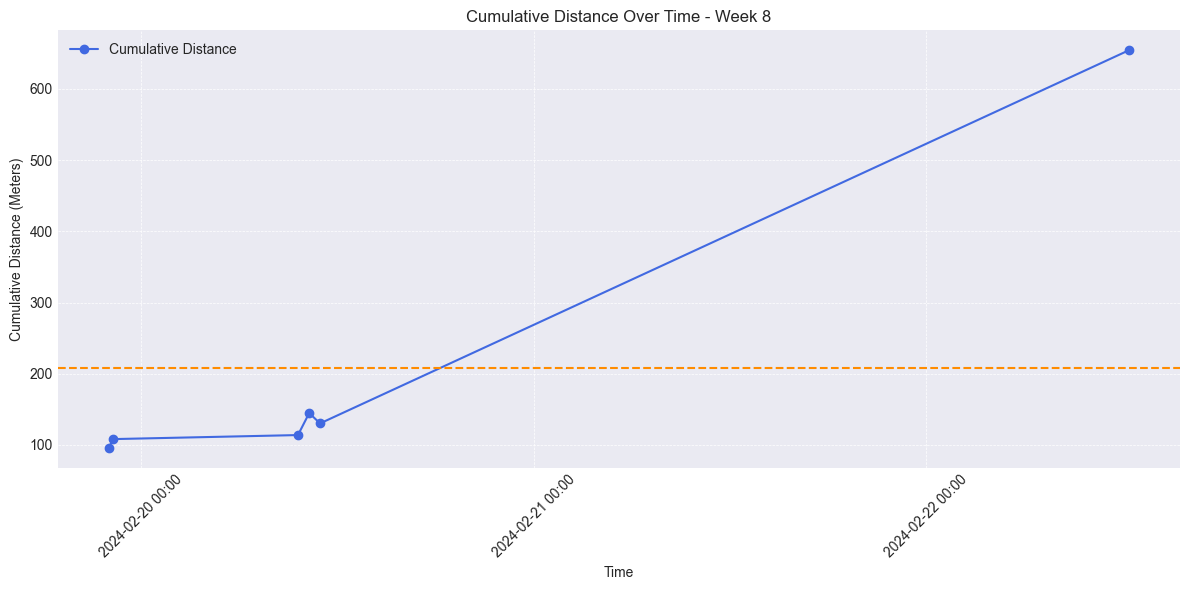

Cumulative Distance Values for Week 10:
creationDate
2024-03-05 13:20:38+01:00     90.1715
2024-03-05 13:42:07+01:00    121.3800
2024-03-05 13:55:17+01:00     91.0500
2024-03-05 15:45:13+01:00     94.5200
2024-03-06 09:56:05+01:00    193.3320
2024-03-06 09:59:33+01:00    127.8700
2024-03-06 10:44:21+01:00    124.9400
2024-03-06 12:11:11+01:00     98.7400
2024-03-06 12:37:21+01:00     87.2100
2024-03-06 14:09:27+01:00    117.7100
2024-03-06 14:20:15+01:00    123.1400
2024-03-06 14:59:16+01:00    106.5200
2024-03-07 09:21:35+01:00     89.0400
2024-03-07 10:00:20+01:00     94.8300
2024-03-07 10:21:15+01:00     85.9725
2024-03-07 11:05:28+01:00     98.8000
2024-03-07 13:59:12+01:00     93.0100
2024-03-07 15:42:11+01:00    118.0700
2024-03-07 15:54:24+01:00     91.2200
2024-03-08 11:22:18+01:00     84.6600
Name: cumulative_value, dtype: float64


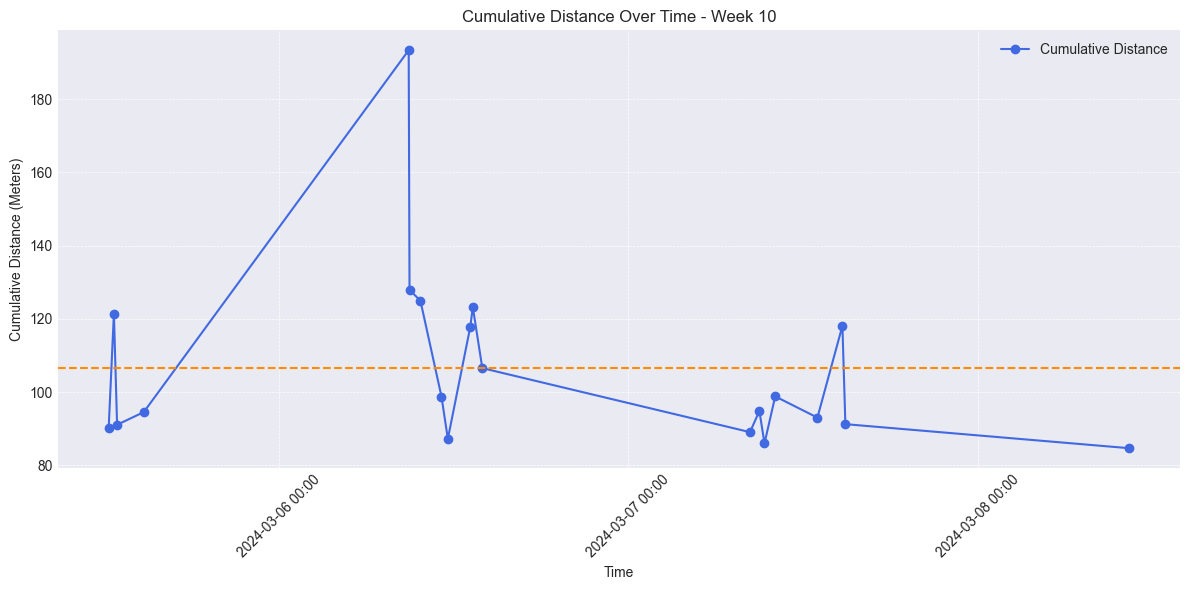

Cumulative Distance Values for Week 11:
creationDate
2024-03-11 11:12:15+01:00    137.8100
2024-03-11 12:47:10+01:00    120.1700
2024-03-11 13:10:30+01:00    113.0700
2024-03-11 13:31:46+01:00    117.6400
2024-03-11 15:01:31+01:00    116.2700
2024-03-12 11:36:17+01:00    100.2200
2024-03-12 11:44:39+01:00    380.9300
2024-03-12 13:13:08+01:00    102.0000
2024-03-12 13:50:08+01:00    122.2300
2024-03-13 09:56:12+01:00    346.1600
2024-03-13 10:01:22+01:00    126.9235
2024-03-13 10:53:23+01:00    100.5625
2024-03-13 12:59:24+01:00    801.1600
2024-03-13 14:48:27+01:00    105.0900
2024-03-13 15:00:11+01:00    118.2500
2024-03-13 15:15:12+01:00    118.7300
2024-03-14 09:37:16+01:00     95.5965
2024-03-14 10:51:24+01:00    214.3600
2024-03-14 11:24:12+01:00     82.7400
2024-03-15 10:15:11+01:00    102.4600
2024-03-15 11:22:42+01:00    108.1600
2024-03-15 12:02:14+01:00    129.5100
Name: cumulative_value, dtype: float64


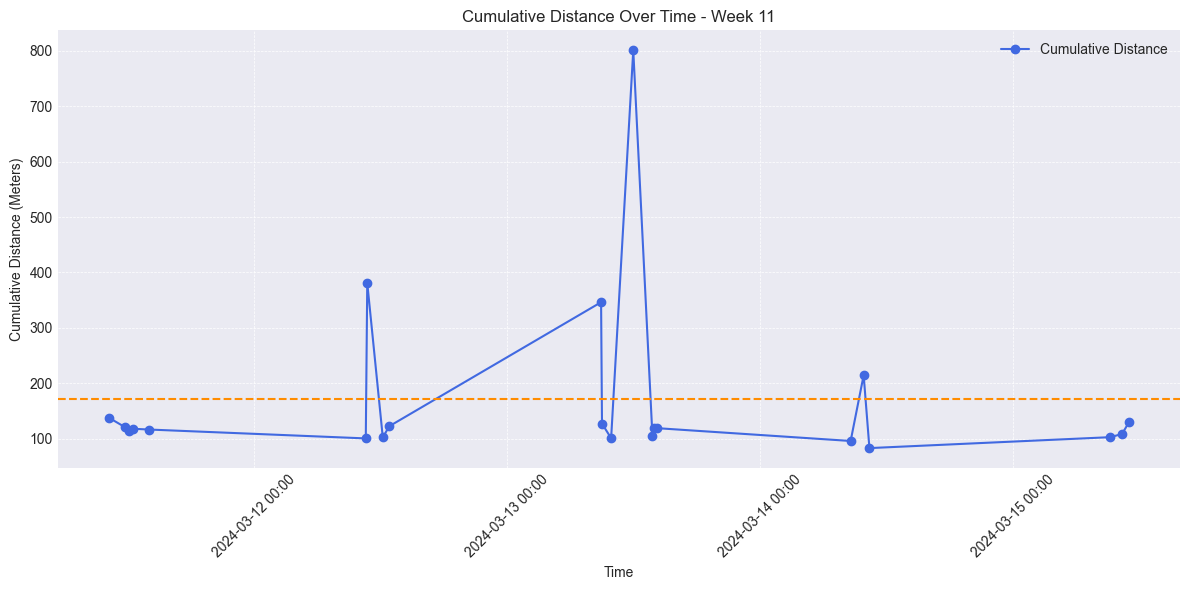

Cumulative Distance Values for Week 12:
creationDate
2024-03-18 10:19:20+01:00     88.8700
2024-03-18 10:56:38+01:00    129.8100
2024-03-18 11:22:55+01:00     85.3030
2024-03-18 11:43:27+01:00    105.1195
2024-03-18 12:11:30+01:00    150.3900
2024-03-18 12:34:21+01:00     83.6300
2024-03-18 14:13:08+01:00    149.6100
2024-03-18 14:58:12+01:00    132.8800
2024-03-18 15:52:27+01:00    126.5000
2024-03-19 11:55:25+01:00    104.6976
2024-03-19 12:10:33+01:00    384.2600
2024-03-19 13:02:00+01:00     82.9249
2024-03-19 14:06:12+01:00    146.6500
2024-03-20 10:13:08+01:00    119.5600
2024-03-20 11:44:31+01:00    102.5200
2024-03-20 12:49:13+01:00    418.2600
2024-03-20 13:38:10+01:00    211.7700
2024-03-20 14:00:13+01:00    142.9000
2024-03-20 14:21:19+01:00    143.0700
2024-03-21 09:11:10+01:00    161.1800
2024-03-21 09:44:23+01:00     98.4400
2024-03-21 11:17:19+01:00     83.5300
2024-03-21 13:31:24+01:00    106.9400
Name: cumulative_value, dtype: float64


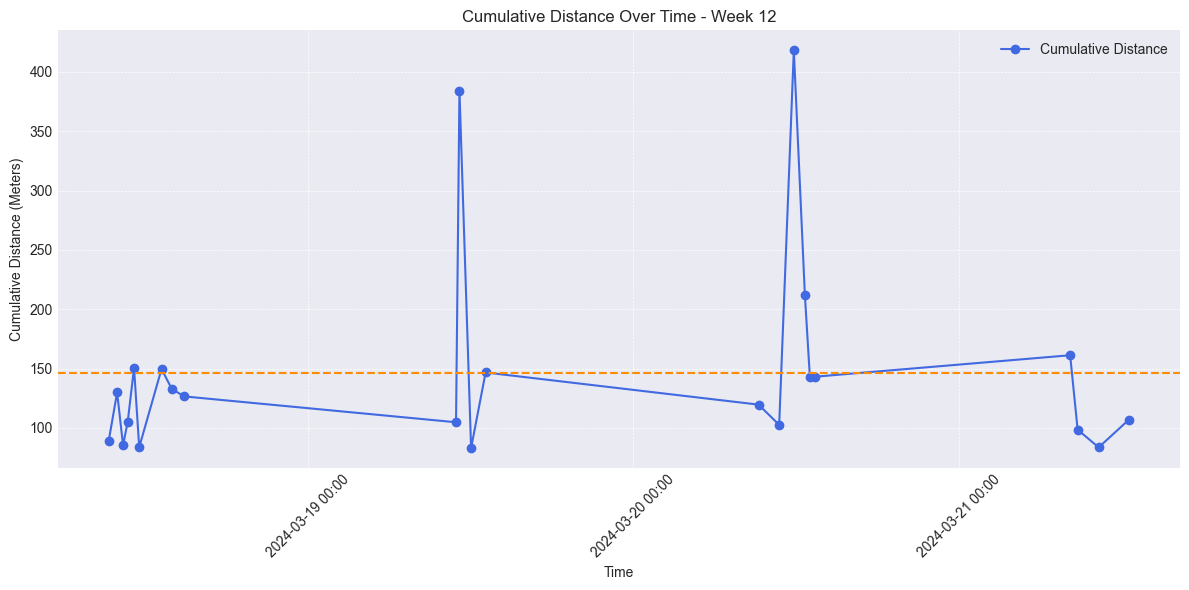

Cumulative Distance Values for Week 13:
creationDate
2024-03-25 10:36:12+01:00    102.43
2024-03-25 11:43:21+01:00    162.32
2024-03-25 12:01:16+01:00    179.04
Name: cumulative_value, dtype: float64


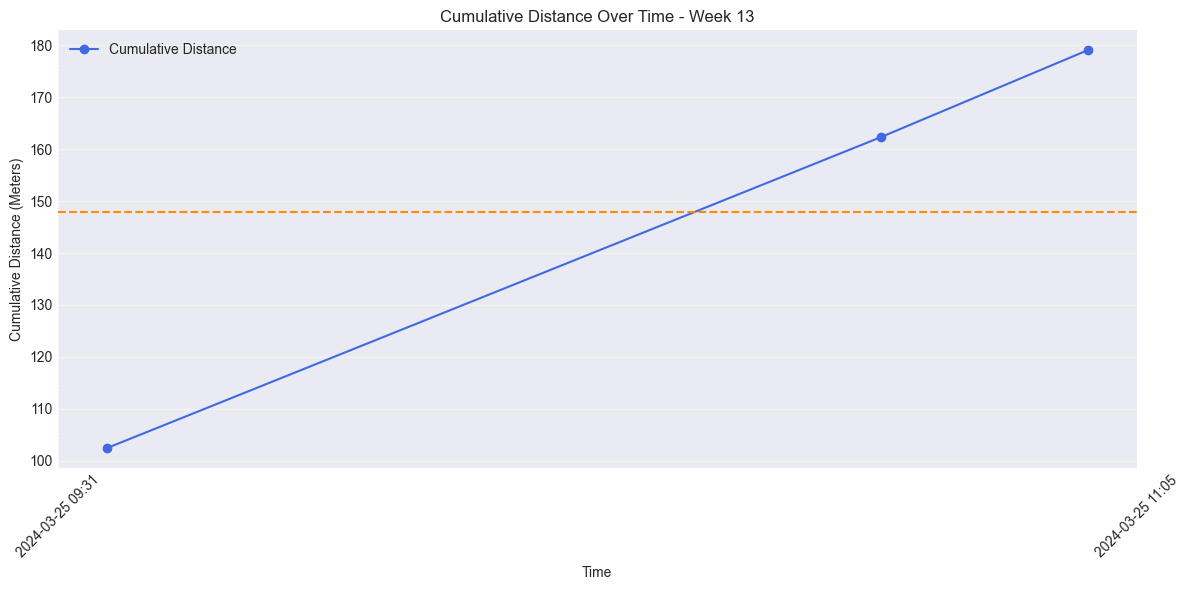

In [87]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/distance_>82.csv')
df['creationDate'] = pd.to_datetime(df['creationDate'])
df['week_number'] = df['creationDate'].dt.isocalendar().week

unique_weeks = df['week_number'].unique()

for week in unique_weeks:
    df_week = df[df['week_number'] == week]
    df_week.set_index('creationDate', inplace=True)
    
    # Berechne die Gesamtsumme von 'cumulative_value' für die aktuelle Woche
    total_cumulative_value = df_week['cumulative_value'].sum()

    # Überprüfe, ob die Gesamtsumme kleiner als 10 ist
    if total_cumulative_value < 10:
        continue

    print(f"Cumulative Distance Values for Week {week}:")
    print(df_week['cumulative_value'])
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_week.index, df_week['cumulative_value'], label='Cumulative Distance', marker='o', linestyle='-', color='royalblue')
    
    plt.xlabel('Time')
    plt.ylabel('Cumulative Distance (Meters)')
    plt.title(f'Cumulative Distance Over Time - Week {week}')
    plt.legend()
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.xticks(rotation=45)
    
    avg_distance = df_week['cumulative_value'].mean()
    plt.axhline(y=avg_distance, color='darkorange', linestyle='--', label='Average Distance')
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    
    plt.savefig(f'cumulative_distance_week_{week}.png')
    plt.show()

In [10]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/distance_original.csv')

df = df.drop_duplicates(subset='creationDate')

df['creationDate'] = pd.to_datetime(df['creationDate'])
print(df['creationDate'])

# Umwandeln der 'value' von km in Meter
df['value'] = df['value'] * 1000

# Sortiere den DataFrame nach 'creationDate'
df.sort_values('creationDate', inplace=True)

# Initialisiere eine neue Liste, um die Zeilen der neuen Tabelle zu speichern
new_rows = []

# Initialisiere Variablen für die kumulative Summation
cumulative_value = 0
start_creation_date = df.iloc[0]['creationDate']

# Durchlaufe den DataFrame
for i in range(len(df)):
    current_row = df.iloc[i]
    # Prüfe, ob dies der erste Durchlauf ist
    if i == 0:
        cumulative_value = current_row['value']
    else:
        # Berechne die Zeitdifferenz zum vorherigen Eintrag
        time_diff = current_row['creationDate'] - df.iloc[i-1]['creationDate']
        # Wenn die Differenz weniger als eine Minute beträgt, summiere die 'value'
        if time_diff < pd.Timedelta(minutes=3):
            cumulative_value += current_row['value']
        else:
            # Wenn die Differenz eine Minute oder mehr beträgt, speichere den bisherigen kumulierten Wert
            new_rows.append({'creationDate': start_creation_date, 'cumulative_value': cumulative_value})
            # Setze die Werte für den nächsten kumulativen Block
            start_creation_date = current_row['creationDate']
            cumulative_value = current_row['value']
            
# Vergiss nicht, den letzten kumulierten Wert hinzuzufügen
new_rows.append({'creationDate': start_creation_date, 'cumulative_value': cumulative_value})

# Erstelle einen neuen DataFrame aus den gesammelten Zeilen
df_new = pd.DataFrame(new_rows)

# Speichere den neuen DataFrame in einer CSV-Datei
#df_new.to_csv('sum_distances_new.csv', index=False)

print(df_new)

0       2024-03-25 12:14:18+01:00
1       2024-03-25 12:13:55+01:00
2       2024-03-25 12:13:51+01:00
3       2024-03-25 12:13:50+01:00
4       2024-03-25 12:12:13+01:00
                   ...           
14056   2024-02-15 17:08:28+01:00
14057   2024-02-15 07:21:37+01:00
14058   2024-02-14 21:04:35+01:00
14060   2024-02-14 19:09:58+01:00
14061   2024-02-14 18:38:57+01:00
Name: creationDate, Length: 13523, dtype: datetime64[ns, pytz.FixedOffset(60)]
                 creationDate  cumulative_value
0   2024-02-14 18:38:57+01:00           58.8100
1   2024-02-14 19:09:58+01:00           68.2300
2   2024-02-14 21:04:35+01:00           10.9220
3   2024-02-15 07:21:37+01:00           20.0710
4   2024-02-15 17:08:28+01:00           69.9300
..                        ...               ...
515 2024-03-25 11:35:52+01:00           15.5210
516 2024-03-25 11:41:56+01:00          756.1841
517 2024-03-25 11:54:59+01:00         1827.5255
518 2024-03-25 12:19:18+01:00          290.1900
519                

In [89]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/sum_distances.csv')

filtered_df = df[df['cumulative_value'] >= 0]

# Speichere die gefilterten Zeilen in eine neue CSV-Datei
filtered_df.to_csv('distance_all.csv', index=False)

In [90]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/apple_health_export_2024-03-29.csv')

filtered_df = df[df['type'] == 'DistanceWalkingRunning']

filtered_df.to_csv('distance_original.csv', index=False)


/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_54431/4245086237.py:1: DtypeWarning: Columns (0,1,3,4,5,6,7,8,11,12,13,14,17,18,19,20,28,29,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/apple_health_export_2024-03-29.csv')


In [59]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/data_FINAL_05.04.csv')

# Initialisiere eine Liste für die berechneten BMI-Werte
df['EffectiveTime'] = pd.to_datetime(df['endDate'])

# Stelle sicher, dass die Werte in der Spalte 'value' numerisch sind
df['MeasurementValue'] = pd.to_numeric(df['MeasurementValue'], errors='coerce')

df.insert(df.columns.get_loc('EffectiveTime') + 1, 'BMI_CDA', None)

# Gruppiere die Daten nach 'creationDate' und sortiere sie
grouped = df.groupby('EffectiveTime')

# Initialisiere eine Liste für die BMI-Werte, die der Tabelle hinzugefügt werden sollen
bmi_values = [None] * len(df)  # Erstelle eine Liste mit der gleichen Länge wie der DataFrame

# Gehe durch jede Gruppe
for name, group in grouped:
    if 'kg' in group['Unit'].values and 'cm' in group['Unit'].values:
        weight = group.loc[group['Unit'] == 'kg', 'MeasurementValue'].iloc[0]
        height = group.loc[group['Unit'] == 'cm', 'MeasurementValue'].iloc[0]
        height_m = height / 100  # Konvertiere cm in m
        bmi = weight / (height_m ** 2)
        bmi_values[group.index[0]] = bmi  # Setze den BMI-Wert nur für den ersten Eintrag der Gruppe

# Füge die BMI-Werte zum DataFrame hinzu
df['BMI_CDA'] = bmi_values

# Speichere den DataFrame mit der neuen 'BMI'-Spalte in einer CSV-Datei
df.to_csv('bmi_cda.csv', index=False)

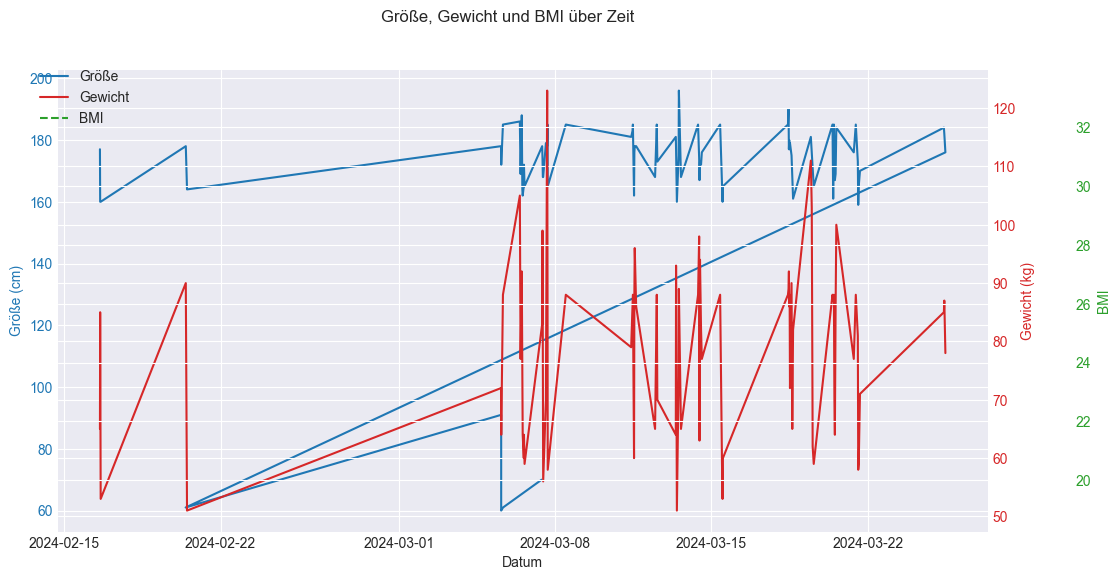

In [105]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/bmi_cda.csv')

# Konvertiere 'creationDate' in ein datetime-Format
df['creationDate'] = pd.to_datetime(df['creationDate'])

# Filtere die Daten, um nur die Zeilen zu behalten, die Größe und Gewicht enthalten
df_size = df[df['unit'] == 'cm']
df_weight = df[df['unit'] == 'kg']

# Plot-Erstellung
fig, ax1 = plt.subplots(figsize=(12, 6))

# Erste y-Achse für die Größe
color = 'tab:blue'
ax1.set_xlabel('Datum')
ax1.set_ylabel('Größe (cm)', color=color)
ax1.plot(df_size['creationDate'], df_size['value'], label='Größe', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Zweite y-Achse für das Gewicht
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Gewicht (kg)', color=color)
ax2.plot(df_weight['creationDate'], df_weight['value'], label='Gewicht', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Dritte Achse (x) für den BMI
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
color = 'tab:green'
ax3.set_ylabel('BMI', color=color)
ax3.plot(df_weight['creationDate'], df_weight['BMI'], label='BMI', color=color, linestyle='--')
ax3.tick_params(axis='y', labelcolor=color)

# Titel und Legende
fig.suptitle('Größe, Gewicht und BMI über Zeit')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Zeige den Plot
plt.show()

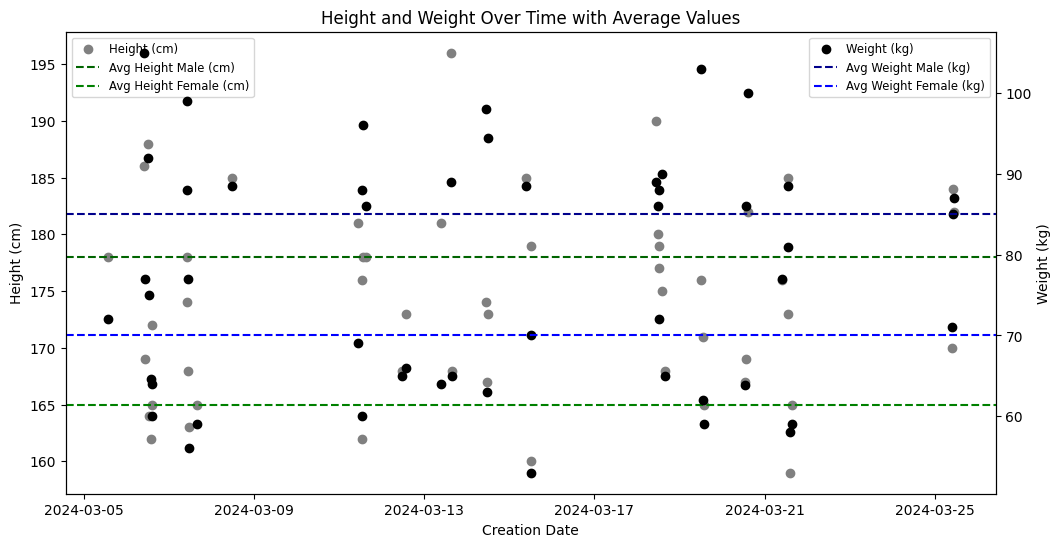

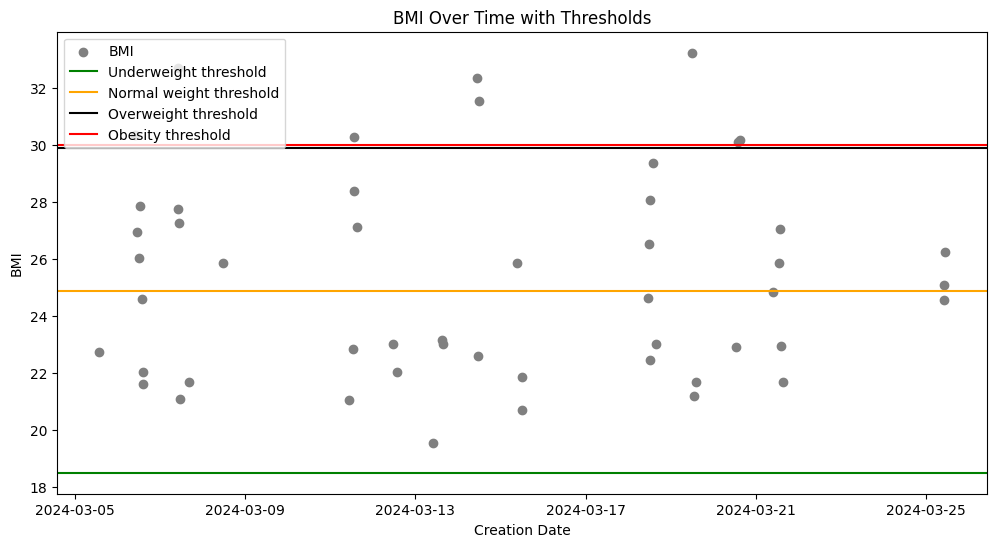

50


In [178]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/cleaneddata_with_bmi_flag.csv')

df['startDate'] = pd.to_datetime(df['startDate'])

avg_height_male = 178  # in cm
avg_weight_male = 85  # in kg
avg_height_female = 165  # in cm
avg_weight_female = 70  # in kg

# Erstelle den Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Scatter-Plot für Größe und Gewicht
ax1.scatter(df['startDate'], df['height (cm)'], label='Height (cm)', color='grey', marker='o')
ax2 = ax1.twinx()
ax2.scatter(df['startDate'], df['weight (kg)'], label='Weight (kg)', color='black', marker='o')

# Durchschnittswerte hinzufügen
ax1.axhline(y=avg_height_male, color='darkgreen', linestyle='--', label='Avg Height Male (cm)')
ax1.axhline(y=avg_height_female, color='green', linestyle='--', label='Avg Height Female (cm)')
ax2.axhline(y=avg_weight_male, color='darkblue', linestyle='--', label='Avg Weight Male (kg)')
ax2.axhline(y=avg_weight_female, color='blue', linestyle='--', label='Avg Weight Female (kg)')

ax1.legend(loc='upper left', fontsize='small')
ax2.legend(loc='upper right', fontsize='small')
ax1.set_xlabel('Creation Date')
ax1.set_ylabel('Height (cm)')
ax2.set_ylabel('Weight (kg)')
plt.title('Height and Weight Over Time with Average Values')
plt.savefig('weights&hights.png')

plt.show()

df = df.dropna(subset=['BMI'])

bmi_low_threshold = 18.5
bmi_high_threshold = 24.9
bmi_overweight_threshold = 29.9
bmi_obesity_threshold = 30

fig, ax = plt.subplots(figsize=(12, 6))

# Scatter-Plot für BMI
ax.scatter(df['startDate'], df['BMI'], label='BMI', color='grey', marker='o')

# Grenzen für BMI hinzufügen
ax.axhline(y=bmi_low_threshold, color='green', linestyle='-', label='Underweight threshold')
ax.axhline(y=bmi_high_threshold, color='orange', linestyle='-', label='Normal weight threshold')
ax.axhline(y=bmi_overweight_threshold, color='black', linestyle='-', label='Overweight threshold')
ax.axhline(y=bmi_obesity_threshold, color='red', linestyle='-', label='Obesity threshold')

# Legenden und Labels
ax.legend(loc='upper left')
ax.set_xlabel('Creation Date')
ax.set_ylabel('BMI')
plt.title('BMI Over Time with Thresholds')
plt.savefig('BMI.png')

plt.show()

print(df['BMI'].size)

In [192]:
path = '/Users/tanjazast/Desktop/jupyter_folder/csv/excel_6MWT_modified.csv'

df = pd.read_csv(path)
print(df.columns)

# Spaltenüberschriften basierend auf der Position in deinem Bildschirmfoto benennen
new_column_names = [
    'study ID', 'height (cm)', 'age (years)', 'weight (kg)', 'TimeStamp', 
    'leg Length (cm)', 'Subject/Patient', 'Distance (m)', 'Turns', 'Step Count', 'Step Count(After 6MWT)', 'Rounds', 'Distance (per round)', 'Counted Steps', 'Calculated m', 'Carrying location', 'Distance (km)', 'Steps (before)', 'Steps (after)','Steps'
]

df.columns = new_column_names

# Speichere den modifizierten DataFrame (Pfad nach Bedarf anpassen)
output_path = 'excel_6MWT_modified_2.csv'
df.to_csv(output_path, index=False)


Index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Calibration', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Classic 6MWT', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Mobile Devices', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19'],
      dtype='object')


In [200]:
import pandas as pd

import os

# Aktuelles Arbeitsverzeichnis ausgeben
print(os.getcwd())

path2 = '/Users/tanjazast/Desktop/jupyter_folder/csv/excel_6MWT_modified_2.csv'
path1 = '/Users/tanjazast/Desktop/jupyter_folder/csv/mapped_modified.csv'

df1 = pd.read_csv(path1, low_memory=False)
df2 = pd.read_csv(path2, low_memory=False)

result_df = pd.merge(df1, df2, left_on='endDate', right_on='TimeStamp', how='inner')
result_df.to_csv('data_FINAL.csv', index=False)

/Users/tanjazast/Desktop/jupyter_folder/xml


In [65]:
path2 = '/Users/tanjazast/Desktop/jupyter_folder/csv/excel_6MWT_modified_2.csv'
path1 = '/Users/tanjazast/Desktop/jupyter_folder/csv/mapped_modified.csv'

df1 = pd.read_csv(path1, low_memory=False)
df2 = pd.read_csv(path2, low_memory=False)

ergebnis_zeilen = pd.concat([df1, df2])

# Füge die DataFrames nebeneinander zusammen (spaltenweise)
ergebnis_spalten = pd.concat([df1, df2], axis=1)

ergebnis_spalten.to_csv('data_FINAL.csv', index=False)

In [18]:
import pandas as pd

path = '/Users/tanjazast/Desktop/jupyter_folder/csv/data_FINAL.csv'

df = pd.read_csv(path)

pattern = r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\+\d{2}:\d{2}$'

df['TimeStamp'] = df['TimeStamp'].where(df['TimeStamp'].str.match(pattern), 0)

df['endDate'] = pd.to_datetime(df['endDate'], errors='coerce')
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], errors='coerce')

# Erstelle einen temporären DataFrame für den Merge-Vorgang
temp_df = df[['endDate', 'age (years)']].copy()
temp_df.rename(columns={'endDate': 'TimeStamp'}, inplace=True)

# Führe einen inneren Join durch, basierend auf übereinstimmenden 'TimeStamp'
merged_df = pd.merge(df, temp_df, on='TimeStamp', how='inner')

# Die resultierende Spalte "age (years)_y" enthält die gesuchten Altersangaben an den übereinstimmenden Positionen
# Benenne diese Spalte um in "age" und entferne dann unnötige Spalten
merged_df.rename(columns={'age (years)_y': 'age'}, inplace=True)
merged_df.drop(columns=['age (years)_x'], inplace=True)

# Um die neue "age" Spalte in die ursprüngliche Position zwischen "endDate" und "study ID" zu bringen, müssen wir die Spaltenreihenfolge anpassen
# Hier wird angenommen, dass du die Spaltenreihenfolge kennst und anpassen kannst. Als Beispiel:
columns = list(merged_df.columns)
new_order = columns[:-2] + ['age'] + [columns[-2]]  # Beispielhafte Neueinsortierung, passe dies entsprechend an
merged_df = merged_df[new_order]
merged_df.to_csv('data_merge_age.csv', index=False)

In [ ]:
import pandas as pd

path = '/Users/tanjazast/Desktop/jupyter_folder/csv/data_FINAL.csv'
df = pd.read_csv(path)

# Stelle sicher, dass 'TimeStamp' und 'endDate' im datetime Format sind
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], errors='coerce')
df['endDate'] = pd.to_datetime(df['endDate'], errors='coerce')

# Erstelle ein Dictionary mit 'TimeStamp' als Schlüssel und 'age (years)' als Wert
timestamp_age_mapping = df.set_index('TimeStamp')['age (years)'].to_dict()

# Füge eine neue Spalte 'matched_age' hinzu, die die 'age (years)' Werte enthält, wenn 'endDate' und 'TimeStamp' übereinstimmen
df['matched_age'] = df['endDate'].map(timestamp_age_mapping)


# Speichere das Ergebnis
df.to_csv('data_adjusted.csv', index=False)

In [12]:
path = '/Users/tanjazast/Desktop/jupyter_folder/csv/data_FINAL.csv'
df = pd.read_csv(path)

# Stelle sicher, dass 'TimeStamp' und 'endDate' im datetime Format sind
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], errors='coerce')
df['endDate'] = pd.to_datetime(df['endDate'], errors='coerce')

# Erstelle ein Dictionary mit 'TimeStamp' als Schlüssel und 'age (years)' als Wert
timestamp_age_mapping = df.set_index('TimeStamp')['age (years)'].to_dict()

# Füge eine neue Spalte 'matched_age' hinzu, die die 'age (years)' Werte enthält, wenn 'endDate' und 'TimeStamp' übereinstimmen
df['matched_age'] = df['endDate'].map(timestamp_age_mapping)

# Bestimme die Indizes der relevanten Spalten
start_col_index = df.columns.get_loc("study ID")
end_col_index = df.columns.get_loc("Steps") + 1  # +1, da Bereichsende exklusiv ist

# Aktualisiere die Werte in den betroffenen Spalten, basierend auf 'matched_age'
for col in df.columns[start_col_index:end_col_index]:
    # Hier setzen wir den neuen Wert nur, wenn 'matched_age' nicht NaN ist
    df[col] = df.apply(lambda x: x['matched_age'] if pd.notna(x['matched_age']) else x[col], axis=1)

# Optional: 'matched_age' Spalte entfernen, falls nicht mehr benötigt
# df.drop(columns=['matched_age'], inplace=True)

# Speichere das Ergebnis
df.to_csv('data_adjusted.csv', index=False)

In [13]:

path = '/Users/tanjazast/Desktop/jupyter_folder/csv/data_FINAL.csv'

df = pd.read_csv(path)

# Bereinigung und Konvertierung von 'TimeStamp' und 'endDate' zu datetime
pattern = r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\+\d{2}:\d{2}$'
df['TimeStamp'] = df['TimeStamp'].where(df['TimeStamp'].str.match(pattern), None)
df['endDate'] = pd.to_datetime(df['endDate'], errors='coerce')
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], errors='coerce')

# Kopiere die Spalte 'age (years)' zum Mappen auf Basis der Übereinstimmungen
df['age_mapped'] = df['age (years)']

# Führe einen Merge innerhalb des DataFrame auf Basis der Übereinstimmungen zwischen 'endDate' und 'TimeStamp' durch
# Wir benutzen 'left' join, um sicherzustellen, dass alle ursprünglichen Zeilen aus df erhalten bleiben
merged_df = pd.merge(df, df[['TimeStamp', 'age_mapped']], left_on='endDate', right_on='TimeStamp', how='left', suffixes=('', '_matched'))

# Update 'age (years)' basierend auf den gefundenen Übereinstimmungen. Wenn keine Übereinstimmung gefunden wurde, behalte den ursprünglichen Wert bei
merged_df['age (years)'] = merged_df['age_mapped_matched'].fillna(merged_df['age (years)'])

# Entferne die temporären Spalten
merged_df.drop(columns=['TimeStamp_matched', 'age_mapped', 'age_mapped_matched'], inplace=True)

merged_df.to_csv('data_updated.csv', index=False)

In [15]:
path = '/Users/tanjazast/Desktop/jupyter_folder/csv/data_FINAL.csv'

df = pd.read_csv(path)

print(df.columns)

Index(['PatientID', 'Gender', 'BirthDate', 'ObservationID', 'ObservationType',
       'Code', 'DisplayName', 'MeasurementValue', 'Unit', 'EffectiveTime',
       'type', 'sourceName', 'value', 'unit', 'startDate', 'endDate',
       'study ID', 'height (cm)', 'age (years)', 'weight (kg)', 'TimeStamp',
       'leg Length (cm)', 'Subject/Patient', 'Distance (m)', 'Turns',
       'Step Count', 'Step Count(After 6MWT)', 'Rounds',
       'Distance (per round)', 'Counted Steps', 'Calculated m',
       'Carrying location', 'Distance (km)', 'Steps (before)', 'Steps (after)',
       'Steps'],
      dtype='object')


In [16]:
path = '/Users/tanjazast/Desktop/jupyter_folder/csv/data_FINAL.csv'

df = pd.read_csv(path)

# Bereinigung und Konvertierung von 'TimeStamp' und 'endDate' zu datetime
pattern = r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\+\d{2}:\d{2}$'
df['TimeStamp'] = df['TimeStamp'].where(df['TimeStamp'].str.match(pattern), None)
df['endDate'] = pd.to_datetime(df['endDate'], errors='coerce')
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], errors='coerce')

# Definiere die Spalten, die aktualisiert werden sollen. Beispiel: von "study ID" bis "Steps"
columns_to_update = ['study ID', 'height (cm)', 'age (years)', 'weight (kg)', 'TimeStamp',
       'leg Length (cm)', 'Subject/Patient', 'Distance (m)', 'Turns',
       'Step Count', 'Step Count(After 6MWT)', 'Rounds',
       'Distance (per round)', 'Counted Steps', 'Calculated m',
       'Carrying location', 'Distance (km)', 'Steps (before)', 'Steps (after)',
       'Steps']  # Hier müssen Sie die tatsächlichen Spaltennamen einfügen

# Führe einen Merge innerhalb des DataFrame auf Basis der Übereinstimmungen zwischen 'endDate' und 'TimeStamp' durch
# Wir benutzen 'left' join, um sicherzustellen, dass alle ursprünglichen Zeilen aus df erhalten bleiben
merged_df = pd.merge(df, df, left_on='endDate', right_on='TimeStamp', how='left', suffixes=('', '_matched'))

# Update der spezifizierten Spalten basierend auf den gefundenen Übereinstimmungen
for col in columns_to_update:
    merged_df[col] = merged_df[col + '_matched'].fillna(merged_df[col])

# Entferne die temporären Spalten, die durch den Merge hinzugefügt wurden
for col in df.columns:
    if col + '_matched' in merged_df:
        merged_df.drop(columns=[col + '_matched'], inplace=True)

merged_df.to_csv('data_updated.csv', index=False)

In [19]:
path = '/Users/tanjazast/Desktop/jupyter_folder/data_updated.csv'

# Lese die Daten in einen DataFrame
df = pd.read_csv(path)

# Finde die Indexe der Spalten "study ID" und "Steps"
# Dies setzt voraus, dass "study ID" vor "Steps" in Ihrem DataFrame steht
start_col_index = df.columns.get_loc("study ID")
end_col_index = df.columns.get_loc("Steps") + 1  # +1, weil die obere Grenze in Python exklusiv ist

# Lösche die Inhalte von Zeile 1 bis 22 (Python-Indexierung beachten) für die spezifizierten Spalten
df.iloc[0:22, start_col_index:end_col_index] = None  # Oder verwenden Sie np.nan für numerische Daten

# Speichere den modifizierten DataFrame zurück in eine CSV-Datei
df.to_csv('modified_data.csv', index=False)

In [21]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/data_FINAL_05.04.csv')

# Initialisiere eine Liste für die berechneten BMI-Werte
df['EffectiveTime'] = pd.to_datetime(df['endDate'])

# Stelle sicher, dass die Werte in der Spalte 'value' numerisch sind
df['MeasurementValue'] = pd.to_numeric(df['MeasurementValue'], errors='coerce')

df.insert(df.columns.get_loc('EffectiveTime') + 1, 'BMI_CDA', None)

# Gruppiere die Daten nach 'creationDate' und sortiere sie
grouped = df.groupby('EffectiveTime')

# Initialisiere eine Liste für die BMI-Werte, die der Tabelle hinzugefügt werden sollen
bmi_values = [None] * len(df)  # Erstelle eine Liste mit der gleichen Länge wie der DataFrame

# Gehe durch jede Gruppe
for name, group in grouped:
    if 'kg' in group['Unit'].values and 'cm' in group['Unit'].values:
        weight = group.loc[group['Unit'] == 'kg', 'MeasurementValue'].iloc[0]
        height = group.loc[group['Unit'] == 'cm', 'MeasurementValue'].iloc[0]
        height_m = height / 100  # Konvertiere cm in m
        bmi = weight / (height_m ** 2)
        bmi_values[group.index[0]] = bmi  # Setze den BMI-Wert nur für den ersten Eintrag der Gruppe

# Füge die BMI-Werte zum DataFrame hinzu
df['BMI_CDA'] = bmi_values

# Speichere den DataFrame mit der neuen 'BMI'-Spalte in einer CSV-Datei
df.to_csv('bmi_cda.csv', index=False)

In [3]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/data_adjusted.csv')

# Überprüfe, ob 'age' und 'weight (kg)' in den Spalten vorhanden sind
if 'matched_age' in df.columns and 'weight (kg)' in df.columns:
    # Speichere die 'age' Spalte in einer temporären Variable
    age_column = df['matched_age']
    
    # Entferne die 'age' Spalte aus dem DataFrame
    df.drop('matched_age', axis=1, inplace=True)
    
    # Bestimme die Position der 'weight (kg)' Spalte
    weight_position = df.columns.get_loc('weight (kg)')
    
    # Füge die 'age' Spalte nach 'weight (kg)' wieder ein
    df.insert(weight_position + 1, 'age', age_column)
    
    # Zeige das Ergebnis an oder speichere es
    print(df.head())
    # Optional: Speichere den modifizierten DataFrame in einer neuen Datei
    df.to_csv('FINAL_data.csv', index=False)
else:
    print("Die Spalten 'age' und/oder 'weight (kg)' existieren nicht im DataFrame.")

               PatientID Gender  BirthDate  \
0  2.16.840.1.113883.4.6      M   19520819   
1  2.16.840.1.113883.4.6      M   19520819   
2  2.16.840.1.113883.4.6      M   19520819   
3  2.16.840.1.113883.4.6      M   19520819   
4  2.16.840.1.113883.4.6      M   19520819   

                          ObservationID ObservationType    Code  \
0  c6f88321-67ad-11db-bd13-0800200c9a66     Vital signs  8302-2   
1  c6f88321-67ad-11db-bd13-0800200c9a66     Vital signs  8302-2   
2  c6f88321-67ad-11db-bd13-0800200c9a66     Vital signs  3141-9   
3  c6f88321-67ad-11db-bd13-0800200c9a66     Vital signs  3141-9   
4  c6f88321-67ad-11db-bd13-0800200c9a66     Vital signs  8302-2   

            DisplayName  MeasurementValue Unit        EffectiveTime  ...  \
0                Height             177.0   cm  20240216141256+0100  ...   
1                Height             177.0   cm  20240216141256+0100  ...   
2  Body weight Measured              65.0   kg  20240216141256+0100  ...   
3  Body weight M

# Lets try some ML #

In [184]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

In [185]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/final_updated_data_23.05.csv')

In [186]:
# NaN-Werte in der Spalte 'RR_before_systolic' entfernen
df.dropna(subset=['RR_before_systolic'], inplace=True)

# Ersetzen von 'male' mit 0 und 'female' mit 1 in der Spalte 'gender'
df['gender'] = df['gender'].replace({'male': 0, 'female': 1})
print(df['gender'])

df['Subject/Patient'] = df['Subject/Patient'].str.replace('S', 's').str.replace('P', 'p').str.strip().str.lower()
df['Subject/Patient'] = df['Subject/Patient'].replace({'subject': 0, 'patient': 1})
print(df['Subject/Patient'])


#df['Calculated m'] = df['Calculated m'].str.replace(',', '.').astype(float)
df['Distance (km)'] = df['Distance (km)'].str.replace(',', '.').astype(float)
#df['BMI_CDA'] = df['BMI_CDA'].str.replace(',', '.').astype(float)

# Features und Zielvariable definieren

features =  df[['Heart rate 40', 'Heart rate 39', 'Heart rate 38', 'Heart rate 37', 'Heart rate 36',
        'Heart rate 35', 'Heart rate 34', 'Heart rate 33', 'Heart rate 32', 'Heart rate 31',
        'Heart rate 30', 'Heart rate 29', 'Heart rate 28', 'Heart rate 27', 'Heart rate 26',
        'Heart rate 25', 'Heart rate 24', 'Heart rate 23', 'Heart rate 22', 'Heart rate 21',
        'Heart rate 20', 'Heart rate 19', 'Heart rate 18', 'Heart rate 17', 'Heart rate 16',
        'Heart rate 15', 'Heart rate 14', 'Heart rate 13', 'Heart rate 12', 'Heart rate 11',
        'Heart rate 10', 'Heart rate 9', 'Heart rate 8', 'Heart rate 7', 'Heart rate 6',
        'Heart rate 5', 'Heart rate 4', 'Heart rate 3', 'Heart rate 2', 'Heart rate 1',
        'HR_before', 'HR_after', 'height (cm)', 'weight (kg)',
        'leg Length (cm)', 'Distance (m)','Distance (km)', 'real_Distance', 
        'RR_before_systolic', 'RR_before_diastolic',
        'RR_after_systolic', 'RR_after_diastolic',
        'RR_before_category_num', 'RR_after_category_num', 'BMI_Over_25', 'Subject/Patient']]

feature = df[['Heart rate 40', 'Heart rate 39', 'Heart rate 38', 'Heart rate 37', 'Heart rate 36',
        'Heart rate 35', 'Heart rate 34', 'Heart rate 33', 'Heart rate 32', 'Heart rate 31',
        'Heart rate 30', 'Heart rate 29', 'Heart rate 28', 'Heart rate 27', 'Heart rate 26',
        'Heart rate 25', 'Heart rate 24', 'Heart rate 23', 'Heart rate 22', 'Heart rate 21',
        'Heart rate 20', 'Heart rate 19', 'Heart rate 18', 'Heart rate 17', 'Heart rate 16',
        'Heart rate 15', 'Heart rate 14', 'Heart rate 13', 'Heart rate 12', 'Heart rate 11',
        'Heart rate 10', 'Heart rate 9', 'Heart rate 8', 'Heart rate 7', 'Heart rate 6',
        'Heart rate 5', 'Heart rate 4', 'Heart rate 3', 'Heart rate 2', 'Heart rate 1',
        'study ID', 'HR_before', 'HR_after', 'gender', 'height (cm)', 'weight (kg)',
        'leg Length (cm)','BMI', 'Distance (m)', 'Turns', 'Step Count',
        'Step Count(After 6MWT)', 'Distance (km)', 'real_Distance', 'Steps (before)',
        'Steps (after)', 'Steps', 'BMI_Over_25', 'RR_before_systolic', 'RR_before_diastolic',
        'RR_after_systolic', 'RR_after_diastolic',
        'RR_before_category_num', 'RR_after_category_num']]

X = features
y = df['age (years)']

# Aufteilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modell trainieren
model = LinearRegression()
model.fit(X_train, y_train)

# Vorhersagen machen
y_pred = model.predict(X_test)

0     0
1     1
2     0
3     0
4     0
5     1
6     1
7     1
8     1
9     0
10    0
11    0
12    1
13    0
14    0
15    1
16    0
17    0
18    1
19    1
20    0
21    0
22    1
23    0
24    0
25    0
26    1
27    1
28    1
29    0
30    1
31    1
32    0
33    0
34    0
35    0
Name: gender, dtype: int64
0     0
1     0
2     0
3     1
4     1
5     1
6     0
7     1
8     0
9     0
10    1
11    1
12    1
13    1
14    1
15    0
16    1
17    1
18    0
19    0
20    1
21    0
22    0
23    1
24    1
25    1
26    0
27    0
28    0
29    1
30    1
31    1
32    0
33    0
34    1
35    0
Name: Subject/Patient, dtype: int64


In [187]:
model = LinearRegression()
model.fit(X_train, y_train)

# Vorhersage auf dem Testset
y_pred = model.predict(X_test)

# Modellbewertung
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 20.871336949637616


In [173]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

# CSV-Datei laden
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/merged_and_updated_final_data-20.07.csv')

# Ersetzen von 'male' mit 0 und 'female' mit 1 in der Spalte 'gender'
df['gender'] = df['gender'].replace({'male': 0, 'female': 1})

df['Subject/Patient'] = df['Subject/Patient'].str.replace('S', 's').str.replace('P', 'p').str.strip().str.lower()
df['Subject/Patient'] = df['Subject/Patient'].replace({'subject': 0, 'patient': 1})

# Umwandeln von Spalten in numerische Werte, falls erforderlich
df['Distance (km)'] = df['Distance (km)'].str.replace(',', '.').astype(float)
df['weight (kg)'] = df['weight (kg)'].str.replace(',', '.').astype(float)

heart_rate_features = df.filter(like='HeartR')

#additional_heart_rate_features = df[['HR_before', 'HR_after', 'RR_before_systolic', 'RR_before_diastolic',
                                     #'RR_after_systolic', 'RR_after_diastolic', 'RR_before_category_num', 'RR_after_category_num']]

# Kombinieren der Heart Rate Features mit zusätzlichen Features
#heart_rate_features = pd.concat([heart_rate_features, additional_heart_rate_features], axis=1)

other_features = df[['Distance (km)', 'age (years)', 'height (cm)', 'weight (kg)']]

#heart_rate_features = heart_rate_features.T.apply(lambda x: x.fillna(x.mean())).T
#other_features = other_features.T.apply(lambda x: x.fillna(x.mean())).T

features = pd.concat([heart_rate_features, other_features], axis=1)


# NaN-Werte durch den Mittelwert der jeweiligen Spalte ersetzen
features.fillna(0, inplace=True)

X = features
y = df['gender']

# Gewichte definieren (Herzfrequenzdaten stärker gewichten)
weights = np.ones(len(X))
for col in heart_rate_features.columns:
    weights += (X[col] > 0).astype(int) * 10  # Herzfrequenzdaten stärker gewichten

# Daten aufteilen
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)
print(y_train)

# Modell trainieren
model = LinearRegression()
model.fit(X_train, y_train, sample_weight=weights_train)

# Vorhersagen machen
y_pred = model.predict(X_test)

# Modellbewertung
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = model.score(X_test, y_test)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R^2 Score:", r2)

# Cross-Validation Score
cross_val_scores = cross_val_score(model, X, y, cv=5)
print("Cross-Validation Scores:", cross_val_scores)
print("Mean Cross-Validation Score:", cross_val_scores.mean())

43    1
26    0
8     1
17    0
6     1
4     0
40    0
19    1
36    1
48    0
37    1
53    0
15    0
9     1
16    1
24    1
33    0
54    0
52    0
25    0
11    0
32    0
50    0
49    0
29    0
41    0
1     0
21    1
2     0
44    0
39    1
35    1
23    0
46    0
10    0
22    0
18    0
56    0
20    0
7     0
42    0
14    0
28    0
51    0
38    1
Name: gender, dtype: int64
Mean Squared Error: 0.6248588163714842
Root Mean Squared Error: 0.7904801176319897
R^2 Score: -1.5708477016426778
Cross-Validation Scores: [-2.27804645 -1.62580551 -1.68141545 -0.86481142 -0.90721135]
Mean Cross-Validation Score: -1.471458035749907


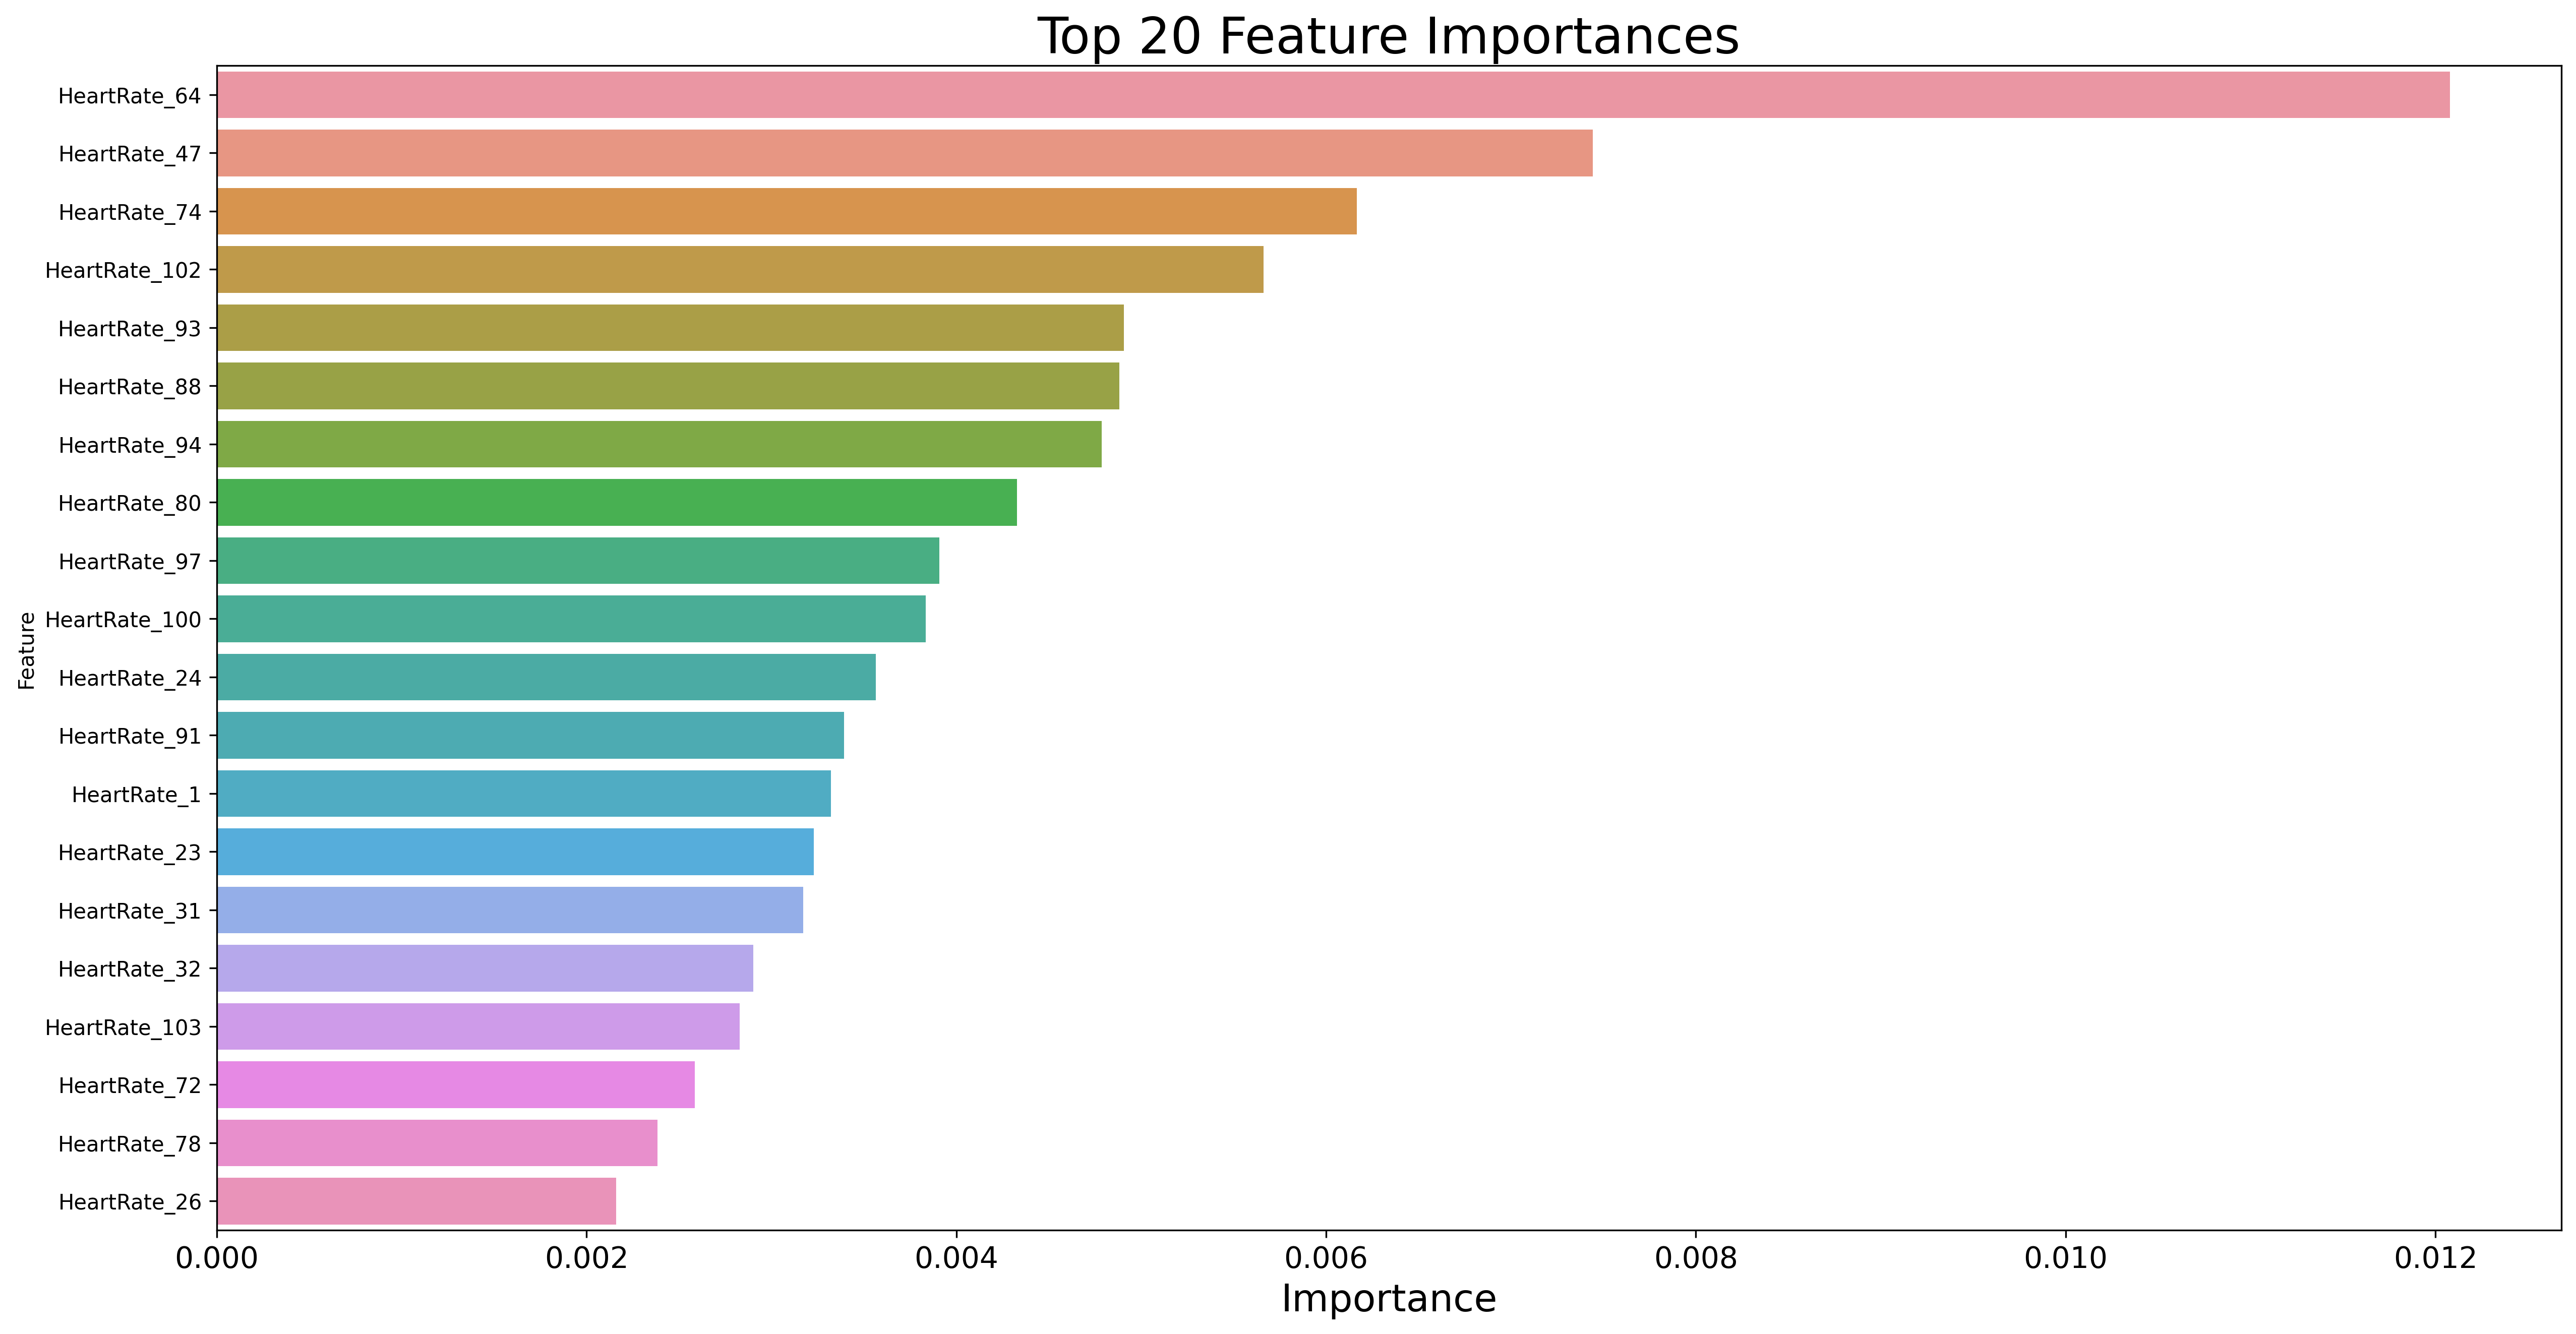

In [172]:
importance = model.coef_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
top_20_features = importance_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(20, 10), dpi=300)  # Increase dpi for higher quality
sns.barplot(x='Importance', y='Feature', data=top_20_features)
plt.title('Top 20 Feature Importances', fontsize=24)
plt.xlabel('Importance', fontsize=18)
plt.xticks(fontsize=14)
plt.savefig('Top_20_Importance_basalEnergy.png', dpi=300)  # Ensure high resolution
plt.show()

In [175]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# CSV-Datei laden
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/merged_and_updated_final_data-20.07.csv')

# Ersetzen von 'male' mit 0 und 'female' mit 1 in der Spalte 'gender'
df['gender'] = df['gender'].replace({'male': 0, 'female': 1})

df['Subject/Patient'] = df['Subject/Patient'].str.replace('S', 's').str.replace('P', 'p').str.strip().str.lower()
df['Subject/Patient'] = df['Subject/Patient'].replace({'subject': 0, 'patient': 1})

df['Distance (km)'] = df['Distance (km)'].str.replace(',', '.').astype(float)
df['weight (kg)'] = df['weight (kg)'].str.replace(',', '.').astype(float)

heart_rate_features = df.filter(like='HeartR')

# Zusätzliche Herzfrequenzmerkmale auswählen
#additional_heart_rate_features = df[['HR_before', 'HR_after', 'RR_before_systolic', 'RR_before_diastolic',
                                     #'RR_after_systolic', 'RR_after_diastolic', 'RR_before_category_num', 'RR_after_category_num']]

# Kombinieren der Herzfrequenzmerkmale mit den zusätzlichen Merkmalen
#heart_rate_features = pd.concat([heart_rate_features, additional_heart_rate_features], axis=1)

# Auswahl der anderen Merkmale
other_features = df[['Distance (km)', 'age (years)', 'height (cm)', 'Sum_ActiveEnergyBurned','Sum_BasalEnergyBurned']]

#heart_rate_features = heart_rate_features.T.apply(lambda x: x.fillna(x.mean())).T
#other_features = other_features.T.apply(lambda x: x.fillna(x.mean())).T

heart_rate_features.fillna(0, inplace=True)
other_features.fillna(0, inplace=True)

# PCA auf Herzfrequenzmerkmale anwenden
pca = PCA(n_components=5)  # Reduzieren der Herzfrequenzdaten auf die wichtigsten Komponenten
heart_rate_pca = pca.fit_transform(heart_rate_features)

# Erstellen eines DataFrames aus den PCA-Komponenten
heart_rate_pca_df = pd.DataFrame(heart_rate_pca, columns=[f'PC{i+1}' for i in range(heart_rate_pca.shape[1])])

# Kombinieren der PCA-Komponenten mit den anderen Merkmalen
features = pd.concat([heart_rate_pca_df, other_features.reset_index(drop=True)], axis=1)

# Zielvariable definieren
X = features
y = df['gender']

# Daten skalieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Daten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Gewichte definieren (Herzfrequenzdaten stärker gewichten)
weights = np.ones(len(X_train))
for col in heart_rate_pca_df.columns:
    weights += (X_train[:, heart_rate_pca_df.columns.get_loc(col)] > 0).astype(int) * 10  # Herzfrequenzdaten stärker gewichten

# Modell trainieren mit Ridge Regression
model = Ridge(alpha=1.0)
model.fit(X_train, y_train, sample_weight=weights)

# Vorhersagen machen
y_pred = model.predict(X_test)

# Modellbewertung
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = model.score(X_test, y_test)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R^2 Score:", r2)

Mean Squared Error: 0.5695512733720233
Root Mean Squared Error: 0.7546862085476475
R^2 Score: -1.3432966675877527


/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_90338/4159688592.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heart_rate_features.fillna(0, inplace=True)
/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_90338/4159688592.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_features.fillna(0, inplace=True)


In [177]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# CSV-Datei laden
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/merged_and_updated_final_data-20.07.csv')

# Ersetzen von 'male' mit 0 und 'female' mit 1 in der Spalte 'gender'
df['gender'] = df['gender'].replace({'male': 0, 'female': 1})

# Ersetzen von 'Subject' mit 0 und 'Patient' mit 1 in der Spalte 'Subject/Patient'
df['Subject/Patient'] = df['Subject/Patient'].str.replace('S', 's').str.replace('P', 'p').str.strip().str.lower()
df['Subject/Patient'] = df['Subject/Patient'].replace({'subject': 0, 'patient': 1})

df['Distance (km)'] = df['Distance (km)'].str.replace(',', '.').astype(float)
df['weight (kg)'] = df['weight (kg)'].str.replace(',', '.').astype(float)

heart_rate_features = df.filter(like='HeartR')

# Zusätzliche Herzfrequenzmerkmale auswählen
#additional_heart_rate_features = df[['HR_before', 'HR_after', 'RR_before_systolic', 'RR_before_diastolic',
                                     #'RR_after_systolic', 'RR_after_diastolic', 'RR_before_category_num', 'RR_after_category_num']]

# Kombinieren der Herzfrequenzmerkmale mit den zusätzlichen Merkmalen
#heart_rate_features = pd.concat([heart_rate_features, additional_heart_rate_features], axis=1)

# Auswahl der anderen Merkmale
other_features = df[['weight (kg)', 'Distance (km)', 'age (years)', 'Sum_ActiveEnergyBurned','Sum_BasalEnergyBurned', 'height (cm)']]

heart_rate_features.fillna(0, inplace=True)
other_features.fillna(0, inplace=True)

#heart_rate_features = heart_rate_features.T.apply(lambda x: x.fillna(x.mean())).T
#other_features = other_features.T.apply(lambda x: x.fillna(x.mean())).T

#print(heart_rate_features)
#print(other_features)

pca = PCA(n_components=5) 
heart_rate_pca = pca.fit_transform(heart_rate_features)

heart_rate_pca_df = pd.DataFrame(heart_rate_pca, columns=[f'PC{i+1}' for i in range(heart_rate_pca.shape[1])])
features = pd.concat([heart_rate_pca_df, other_features.reset_index(drop=True)], axis=1)

print(features)
X = features
y = df['gender']

#X = X.apply(pd.to_numeric, errors='coerce')
#X.dropna(inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
#print(X_test)

# Ridge Regression 
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# pred
y_pred = ridge_model.predict(X_test)

print("Ridge Regression Coefficients:", ridge_model.coef_)
print("Ridge Regression Intercept:", ridge_model.intercept_)
print("Ridge Regression R^2 on test set:", ridge_model.score(X_test, y_test))

from sklearn.model_selection import cross_val_score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Cross-Validation Score calc
scores = cross_val_score(ridge_model, X_scaled, y, cv=5)  # 5-fache Cross-Validation
print("Cross-Validation Scores:", scores)
print("Mean Cross-Validation Score:", scores.mean())

           PC1         PC2         PC3         PC4         PC5  weight (kg)  \
0   257.115870 -252.805945  195.622968  -13.684968  -53.583485         59.0   
1   580.924119  192.887312    0.990324  164.379073  229.227387         62.0   
2  -291.720013 -396.856346  -72.234096    5.376578   68.270515        103.0   
3   247.524559  -43.759269  -45.123057  -70.630920   39.612824         82.0   
4  -468.994028  119.677560  178.466368  -53.359995   63.386530         65.0   
5    44.207467  -97.997818 -104.485348  -16.197812   33.392070         90.0   
6   395.314925  -40.284763  103.293033   -0.858302  -47.434189         72.0   
7   196.540476  -92.974277  -38.127445  -85.311091   28.851837         86.0   
8  -259.674970  171.702190   85.030894  -18.284441    6.953442         89.0   
9   382.883065 -169.283564  247.128656  169.959253  -46.516755         53.0   
10 -272.864505  -79.344477 -108.562975   91.307985  -52.841308         59.0   
11  422.652245  -79.086826  187.745940  147.817930  

/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_90338/1474536744.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heart_rate_features.fillna(0, inplace=True)
/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_90338/1474536744.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_features.fillna(0, inplace=True)


In [224]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error

# Autograph deaktivieren
tf.config.experimental_run_functions_eagerly(True)

# CSV-Datei laden
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/final_data_07.06.csv')

# Ersetzen von 'male' mit 0 und 'female' mit 1 in der Spalte 'gender'
df['gender'] = df['gender'].replace({'male': 0, 'female': 1})

# Ersetzen von 'Subject' mit 0 und 'Patient' mit 1 in der Spalte 'Subject/Patient'
df['Subject/Patient'] = df['Subject/Patient'].str.replace('S', 's').str.replace('P', 'p').str.strip().str.lower()
df['Subject/Patient'] = df['Subject/Patient'].replace({'subject': 0, 'patient': 1})

df['Distance (km)'] = df['Distance (km)'].str.replace(',', '.').astype(float)
df['weight (kg)'] = df['weight (kg)'].str.replace(',', '.').astype(float)

# Auswahl der Herzfrequenzmerkmale
heart_rate_features = df.filter(like='HeartR')

# Zusätzliche Herzfrequenzmerkmale auswählen
additional_heart_rate_features = df[['HR_before', 'HR_after', 'RR_before_systolic', 'RR_before_diastolic',
                                     'RR_after_systolic', 'RR_after_diastolic', 'RR_before_category_num', 'RR_after_category_num']]

# Kombinieren der Herzfrequenzmerkmale mit den zusätzlichen Merkmalen
heart_rate_features = pd.concat([heart_rate_features, additional_heart_rate_features], axis=1)

# Auswahl der anderen Merkmale
other_features = df[['BMI_Over_25', 'age (years)', 'leg Length (cm)', 'BMI', 'Distance (m)',
                     'Distance (km)', 'Subject/Patient', 'height (cm)', 'real_Distance', 'Sum_ActiveEnergyBurned','Sum_BasalEnergyBurned']]

heart_rate_features.fillna(0, inplace=True)
other_features.fillna(0, inplace=True)

# NaN-Werte durch den Mittelwert der jeweiligen Zeile ersetzen
#heart_rate_features = heart_rate_features.T.apply(lambda x: x.fillna(x.mean())).T
#other_features = other_features.T.apply(lambda x: x.fillna(x.mean())).T

# PCA auf Herzfrequenzmerkmale anwenden
pca = PCA(n_components=20) 
heart_rate_pca = pca.fit_transform(heart_rate_features)

heart_rate_pca_df = pd.DataFrame(heart_rate_pca, columns=[f'PC{i+1}' for i in range(heart_rate_pca.shape[1])])
features = other_features.reset_index(drop=True)

X = features
y = df['weight (kg)']

X = X.apply(pd.to_numeric, errors='coerce')
X.dropna(inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

def create_model():
    model = Sequential()
    model.add(Dense(256, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Wrap the model using KerasRegressor
nn_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model, epochs=3000, batch_size=32, verbose=1)

# Fit the model
nn_model.fit(X_train, y_train)

# Predict on the test set
y_pred = nn_model.predict(X_test)

# Calculate the R^2 score on the test set
r2_score = nn_model.score(X_test, y_test)
print("Neural Network R^2 on test set:", r2_score)

# Calculate the Mean Squared Error on the test set
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on test set:", mse)

# Calculate RMSE for better interpretation
rmse = np.sqrt(mse)
print("Root Mean Squared Error on test set:", rmse)

Epoch 1/3000


/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_59963/2049885776.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_features.fillna(0, inplace=True)
/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_59963/2049885776.py:80: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model, epochs=3000, batch_size=32, verbose=1)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not ap

2/2 [==============================] - 0s 40ms/step - loss: 5897.6816
Epoch 2/3000
2/2 [==============================] - 0s 50ms/step - loss: 5841.4229
Epoch 3/3000
2/2 [==============================] - 0s 57ms/step - loss: 5790.6250
Epoch 4/3000
2/2 [==============================] - 0s 63ms/step - loss: 5728.1543
Epoch 5/3000
2/2 [==============================] - 0s 64ms/step - loss: 5667.5718
Epoch 6/3000
2/2 [==============================] - 0s 50ms/step - loss: 5567.7393
Epoch 7/3000
2/2 [==============================] - 0s 63ms/step - loss: 5492.0591
Epoch 8/3000
2/2 [==============================] - 0s 54ms/step - loss: 5391.3975
Epoch 9/3000
2/2 [==============================] - 0s 48ms/step - loss: 5265.8145
Epoch 10/3000
2/2 [==============================] - 0s 46ms/step - loss: 5138.5107
Epoch 11/3000
2/2 [==============================] - 0s 55ms/step - loss: 4953.7129
Epoch 12/3000
2/2 [==============================] - 0s 61ms/step - loss: 4774.6021
Epoch 13/3000


In [225]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# CSV-Datei laden
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/final_data_07.06.csv')

# Ersetzen von 'male' mit 0 und 'female' mit 1 in der Spalte 'gender'
df['gender'] = df['gender'].replace({'male': 0, 'female': 1})

# Ersetzen von 'Subject' mit 0 und 'Patient' mit 1 in der Spalte 'Subject/Patient'
df['Subject/Patient'] = df['Subject/Patient'].str.replace('S', 's').str.replace('P', 'p').str.strip().str.lower()
df['Subject/Patient'] = df['Subject/Patient'].replace({'subject': 0, 'patient': 1})

df['Distance (km)'] = df['Distance (km)'].str.replace(',', '.').astype(float)
df['weight (kg)'] = df['weight (kg)'].str.replace(',', '.').astype(float)

# Auswahl der Herzfrequenzmerkmale
heart_rate_features = df.filter(like='HeartR')

# Zusätzliche Herzfrequenzmerkmale auswählen
additional_heart_rate_features = df[['HR_before', 'HR_after', 'RR_before_systolic', 'RR_before_diastolic',
                                     'RR_after_systolic', 'RR_after_diastolic', 'RR_before_category_num', 'RR_after_category_num']]

# Kombinieren der Herzfrequenzmerkmale mit den zusätzlichen Merkmalen
heart_rate_features = pd.concat([heart_rate_features, additional_heart_rate_features], axis=1)

# Auswahl der anderen Merkmale
other_features = df[['BMI_Over_25', 'age (years)', 'leg Length (cm)', 'BMI', 'Distance (m)',
                     'Distance (km)', 'height (cm)', 'real_Distance', 'Sum_ActiveEnergyBurned','Sum_BasalEnergyBurned']]

heart_rate_features.fillna(0, inplace=True)
other_features.fillna(0, inplace=True)

# PCA auf Herzfrequenzmerkmale anwenden
pca = PCA(n_components=10)  # Reduzieren auf 10 Komponenten
heart_rate_pca = pca.fit_transform(heart_rate_features)

heart_rate_pca_df = pd.DataFrame(heart_rate_pca, columns=[f'PC{i+1}' for i in range(heart_rate_pca.shape[1])])
features = pd.concat([heart_rate_pca_df, other_features.reset_index(drop=True)], axis=1)

X = features
y = df['Subject/Patient']

X = X.apply(pd.to_numeric, errors='coerce')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define a new neural network model
def create_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification for Subject/Patient
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
model = create_model()
history = model.fit(X_train, y_train, epochs=3000, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

# Calculate the R^2 score on the test set (not typically used for classification, but included for consistency)
r2_score = model.evaluate(X_test, y_test, verbose=0)
print("Neural Network R^2 on test set (accuracy):", r2_score[1])

# Calculate the Mean Squared Error on the test set
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on test set:", mse)

# Calculate RMSE for better interpretation
rmse = np.sqrt(mse)
print("Root Mean Squared Error on test set:", rmse)

/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_59963/3007053527.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_features.fillna(0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/3000
1/1 [==============================] - 0s 419ms/step - loss: 0.8002 - accuracy: 0.4286 - val_loss: 0.6796 - val_accuracy: 0.5000
Epoch 2/3000
1/1 [==============================] - 0s 105ms/step - loss: 0.7960 - accuracy: 0.4643 - val_loss: 0.6676 - val_accuracy: 0.5000
Epoch 3/3000
1/1 [==============================] - 0s 123ms/step - loss: 0.7432 - accuracy: 0.4643 - val_loss: 0.6580 - val_accuracy: 0.6250
Epoch 4/3000
1/1 [==============================] - 0s 119ms/step - loss: 0.8225 - accuracy: 0.4643 - val_loss: 0.6492 - val_accuracy: 0.6250
Epoch 5/3000
1/1 [==============================] - 0s 134ms/step - loss: 0.7335 - accuracy: 0.5000 - val_loss: 0.6429 - val_accuracy: 0.6250
Epoch 6/3000
1/1 [==============================] - 0s 128ms/step - loss: 0.7275 - accuracy: 0.4286 - val_loss: 0.6383 - val_accuracy: 0.6250
Epoch 7/3000
1/1 [==============================] - 0s 111ms/step - loss: 0.6825 - accuracy: 0.5357 - val_loss: 0.6343 - val_accuracy: 0.7500
Epoch 

In [197]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Random Forest Regressor initialisieren
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Cross-Validation Score berechnen
rf_scores = cross_val_score(rf_model, X_scaled, y, cv=5)

print("Random Forest Cross-Validation Scores:", rf_scores)
print("Mean Random Forest Cross-Validation Score:", rf_scores.mean())

Random Forest Cross-Validation Scores: [-2.12574753 -0.28797897  0.         -0.9411997  -1.06931724]
Mean Random Forest Cross-Validation Score: -0.8848486883048153


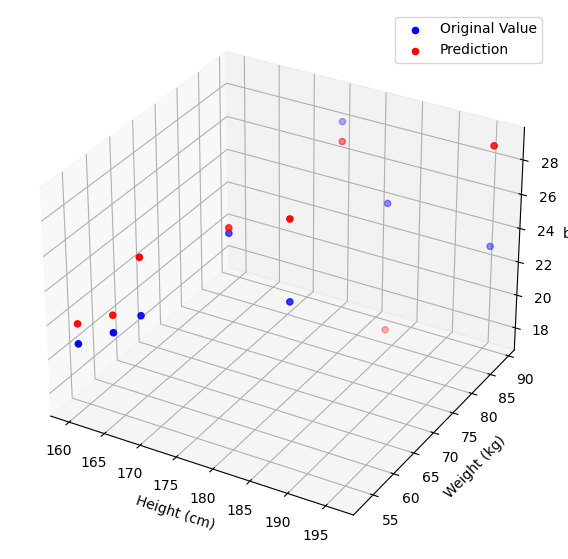

In [132]:
# Plot erstellen
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Tatsächliche Datenpunkte
ax.scatter(X_test['height (cm)'], X_test['weight (kg)'], y_test, color='blue', label='Original Value')

# Vorhersagen
ax.scatter(X_test['height (cm)'], X_test['weight (kg)'], y_pred, color='red', label='Prediction')

# Beschriftungen
ax.set_xlabel('Height (cm)')
ax.set_ylabel('Weight (kg)')
ax.set_zlabel('bmi')
ax.legend()
plt.savefig('prediction_bmi.png')

plt.show()

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import numpy as np

df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/cleaneddata_with_bmi_flag.csv')

df['Subject/Patient'] = df['Subject/Patient'].str.replace('S', 's').str.replace('P', 'p').str.strip().str.lower()

# Entferne Zeilen, in denen 'Subject/Patient' NaN ist
df = df.dropna(subset=['Subject/Patient'])

df['Distance (km)'] = df['Distance (km)'].str.replace(',', '.').astype(float)

# Sicherstellen, dass nur die erwarteten einzigartigen Werte vorhanden sind
print(df['Subject/Patient'].unique())

# Label Encoding auf die bereinigte Spalte anwenden
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df['Subject/Patient'])
print(y_encoded)

# Preparing features and labels
features = ['MeasurementValue', 'Heart rate 2', 'Distance (km)', 'age (years)']
X = df[features]
y = y_encoded

# Splitting data into training and test sets
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(X_train)
print(X_test)


['subject' 'patient']
[1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0
 1 0 1 0 0 1 0 0 0 0 0 0 1]
    MeasurementValue  Heart rate 2  Distance (km)  age (years)
12              79.0          93.0           0.32         59.0
4               67.0         130.0           0.58         63.0
37              80.0         126.0           0.60         59.0
8               74.0         111.0           0.48         26.0
3               83.0         137.0           0.61         60.0
6               84.0         111.0           0.51         78.0
41              61.0         114.0           0.49         84.0
46              63.0         116.0           0.69         59.0
47              72.0         132.0           0.66         51.0
15             115.0         120.0           0.47         88.0
9               75.0         140.0           0.60         21.0
16              76.0         117.0           0.58         22.0
24              70.0         109.0           0.52       

In [45]:
df.head()

Unnamed: 0              PatientID Gender  BirthDate  \
0        1332  2.16.840.1.113883.4.6      M   19520819   
1           2  2.16.840.1.113883.4.6      M   19520819   
2         679  2.16.840.1.113883.4.6      M   19520819   
3         255  2.16.840.1.113883.4.6      M   19520819   
4         314  2.16.840.1.113883.4.6      M   19520819   

                          ObservationID ObservationType    Code DisplayName  \
0  c6f88321-67ad-11db-bd13-0800200c9a66     Vital signs  8867-4  Heart rate   
1  c6f88321-67ad-11db-bd13-0800200c9a66     Vital signs  8867-4  Heart rate   
2  c6f88321-67ad-11db-bd13-0800200c9a66     Vital signs  8867-4  Heart rate   
3  c6f88321-67ad-11db-bd13-0800200c9a66     Vital signs  8867-4  Heart rate   
4  c6f88321-67ad-11db-bd13-0800200c9a66     Vital signs  8867-4  Heart rate   

   MeasurementValue  Heart rate 2  ... Rounds Distance (per round)  \
0              82.0         144.0  ...  24,95                   20   
1              71.0         103.0  ...   37,2                15,00   
2              61.0         124.0  ...   37,5                15,00   
3              83.0         137.0  ...   27,7                20,00   
4              67.0         130.0  ...     29                20,00   

  Counted Steps Calculated m  Carrying location Distance (km) real_Distance  \
0             -       499,00         left wrist          0.47       0.55980   
1             -       558,00         left wrist          0.61       0.61683   
2             -       562,50         left wrist          0.56       0.51840   
3             -       554,00         left wrist          0.61       0.56700   
4        676,00       580,00         left wrist          0.58       0.52875   

  Steps (before)  Steps (after)  Steps  
0          439.0         1061.0  622.0  
1         2543.0         3252.0  709.0  
2         7401.0         8041.0  640.0  
3         1750.0         2450.0  700.0  
4         2839.0         3544.0  705.0  

[5 rows x 41 columns]

In [46]:
model = LinearRegression()
model.fit(X_train, y_train_encoded)

# Prediction on the test set
y_pred = model.predict(X_test)

# Calculating RMSE
mse = mean_squared_error(y_test_encoded, y_pred)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 0.2976056004484027


In [47]:
model = LogisticRegression()
model.fit(X_train, y_train_encoded)

# Prediction on the test set
y_pred = model.predict(X_test)

# Model evaluation using accuracy and classification report
accuracy = accuracy_score(y_test_encoded, y_pred)
report = classification_report(y_test_encoded, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.8
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.60      1.00      0.75         3

    accuracy                           0.80        10
   macro avg       0.80      0.86      0.79        10
weighted avg       0.88      0.80      0.81        10



In [48]:
print(len(X_test['MeasurementValue']))
print(len(X_test['age (years)']))
print(len(y_test_encoded))
print(len(y_pred))

10
10
10
10


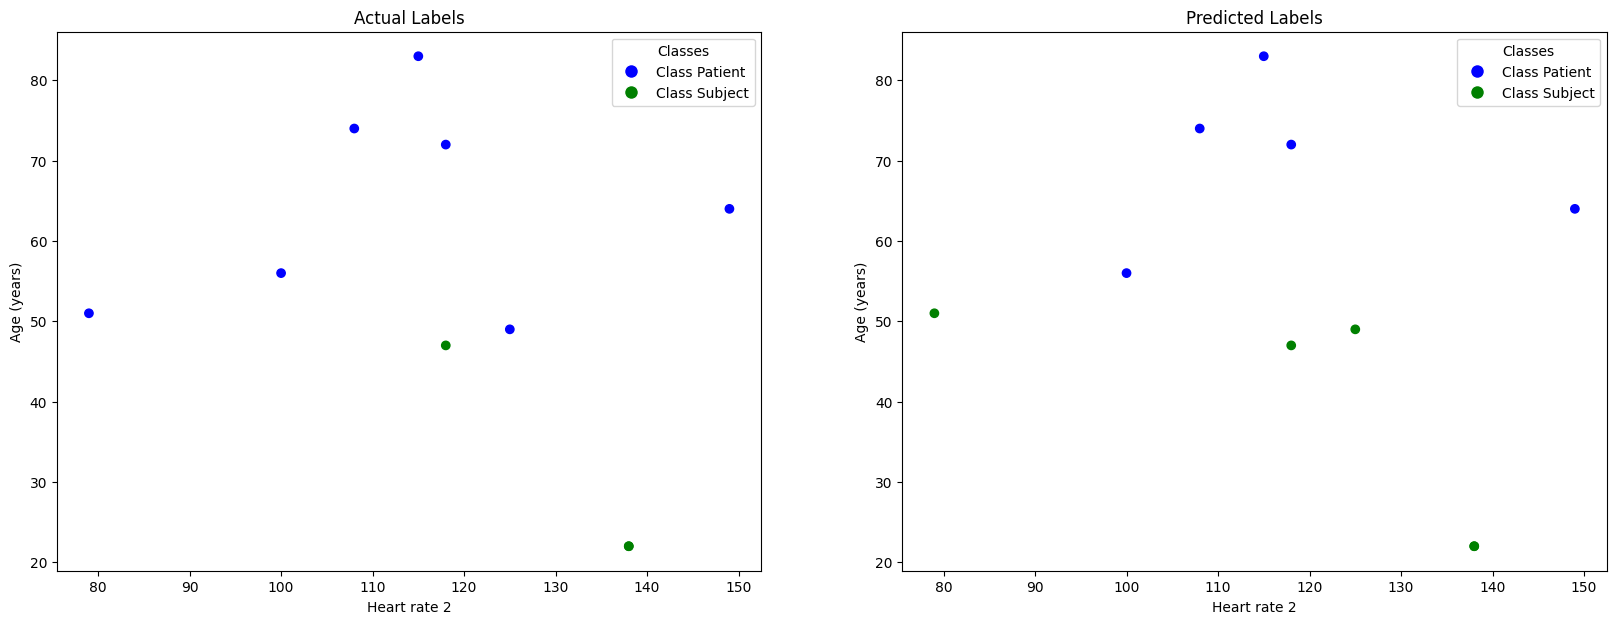

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))  # 1 Zeile, 2 Spalten für Subplots

# Farbkarten für die Klassen
cmap = {0: 'blue', 1: 'green'}
labels = {0: 'Class Patient', 1: 'Class Subject'}

# Tatsächliche Datenpunkte plotten
scatter1 = ax[0].scatter(X_test['Heart rate 2'], X_test['age (years)'], c=[cmap[label] for label in y_test_encoded], label='Original Value')
ax[0].set_title('Actual Labels')
ax[0].set_xlabel('Heart rate 2')
ax[0].set_ylabel('Age (years)')

# Legende für den ersten Plot
handles1 = [plt.Line2D([0], [0], marker='o', color='w', label=labels[i], markersize=10, markerfacecolor=cmap[i]) for i in cmap]
ax[0].legend(handles=handles1, title="Classes")

# Vorhersagen plotten
scatter2 = ax[1].scatter(X_test['Heart rate 2'], X_test['age (years)'], c=[cmap[label] for label in y_pred], label='Prediction')
ax[1].set_title('Predicted Labels')
ax[1].set_xlabel('Heart rate 2')
ax[1].set_ylabel('Age (years)')

# Legende für den zweiten Plot
handles2 = [plt.Line2D([0], [0], marker='o', color='w', label=labels[i], markersize=10, markerfacecolor=cmap[i]) for i in cmap]
ax[1].legend(handles=handles2, title="Classes")

# Speichern der Figur
plt.savefig('prediction_subjectpatient.png')

# Anzeigen des Plots
plt.show()

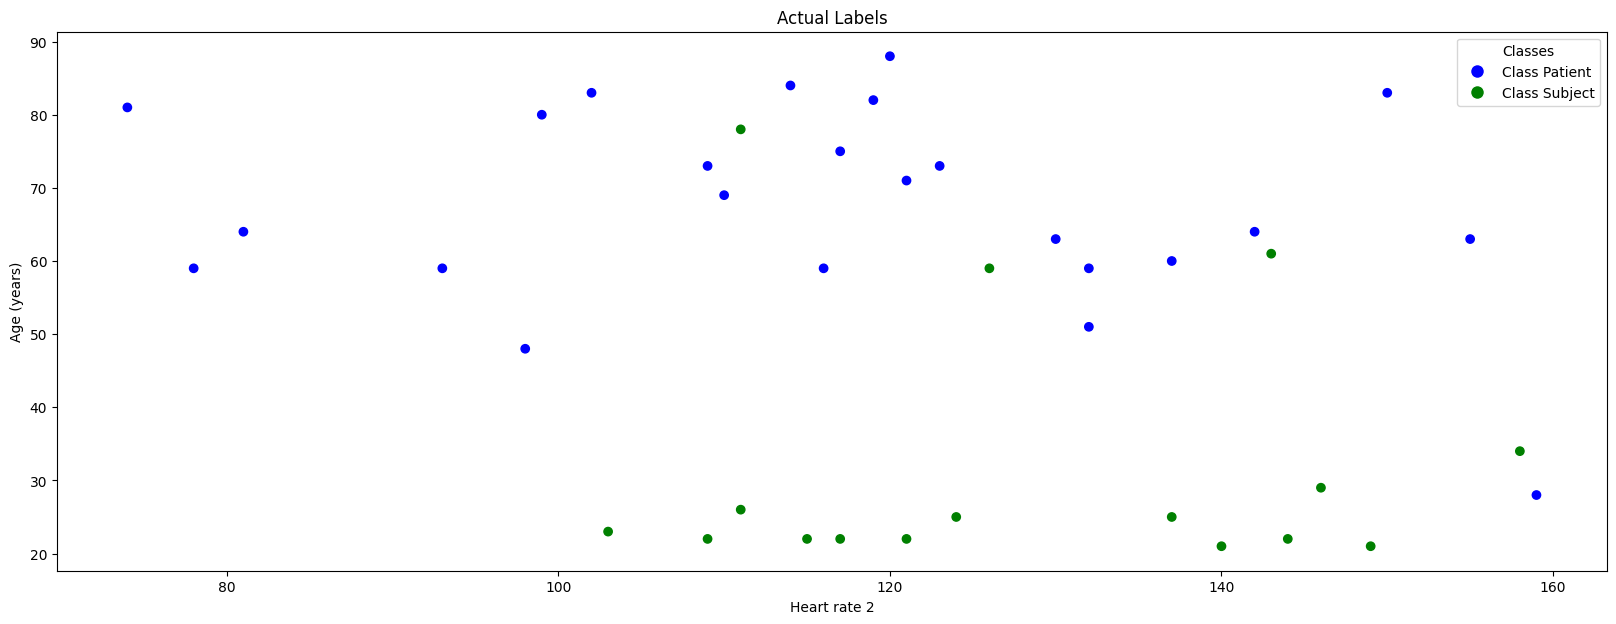

In [51]:
colors = [
    'blue', 'green', 'red', 'cyan', 'magenta', 'orange', 'purple', 'brown', 'pink', 'grey',
    'navy', 'darkgreen', 'crimson', 'teal', 'fuchsia', 'darkorange', 'indigo', 'chocolate', 'lightpink', 'darkgrey',
    'royalblue', 'limegreen', 'firebrick', 'cadetblue', 'violet', 'sandybrown', 'darkviolet', 'peru', 'thistle', 'slategrey',
    'cornflowerblue', 'mediumseagreen', 'tomato', 'steelblue', 'orchid', 'goldenrod', 'mediumpurple', 'sienna', 'plum', 'lightslategrey'
]

# Mapping von y_train_encoded zu Farben
unique_labels = np.unique(y_train_encoded)
if len(unique_labels) > len(colors):
    raise ValueError("Es gibt mehr Klassen als verfügbare Farben. Bitte füge mehr Farben zur Liste hinzu.")

label_color_map = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}
mapped_colors = [label_color_map[label] for label in y_train_encoded]

fig, ax = plt.subplots(1, 1, figsize=(20, 7))

# Tatsächliche Datenpunkte
ax.scatter(X_train['Heart rate 2'], X_train['age (years)'], c=mapped_colors)
ax.set_title('Actual Labels')
ax.set_xlabel('Heart rate 2')
ax.set_ylabel('Age (years)')

# Legende hinzufügen
handles = [plt.Line2D([0], [0], marker='o', color='w', label='Class Patient' if i == 0 else 'Class Subject', 
                      markersize=10, markerfacecolor=label_color_map[i]) for i in unique_labels]
ax.legend(handles=handles, title="Classes")

# Speichern der Figur
plt.savefig('dataset_overview.png')

# Anzeigen des Plots
plt.show()

# zweiter Versuch

In [217]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/cleaneddata_with_bmi_flag.csv')

In [218]:
df['Distance (km)'] = df['Distance (km)'].replace('-', '0')

# Ersetzen von Kommas durch Punkte und Umwandlung in Floats
#df['weight (kg)'] = df['weight (kg)'].str.replace(',', '.').astype(float)
df['Distance (km)'] = df['Distance (km)'].str.replace(',', '.').astype(float)

# Überprüfe, ob das 'age' Feld auch konvertiert werden muss
if df['age (years)'].dtype == object:
    df['age (years)'] = df['age (years)'].str.replace(',', '.').astype(float)
    
df.dropna(subset=['leg Length (cm)', 'Distance (km)' , 'age (years)'], inplace=True)

# Features und Zielvariable definieren
X = df[['leg Length (cm)', 'Distance (km)' ]]  # Unabhängige Variablen
y = df['age (years)']  # Abhängige Variable

# Daten in Trainings- und Testset aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [219]:
model = LinearRegression()
model.fit(X_train, y_train)

# Vorhersage auf dem Testset
y_pred = model.predict(X_test)

# Modellbewertung
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 21.717638668346577


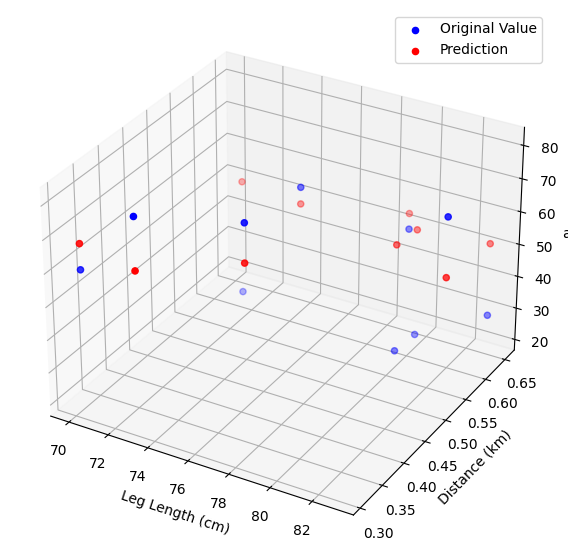

In [220]:
# Plot erstellen
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Tatsächliche Datenpunkte
ax.scatter(X_test['leg Length (cm)'], X_test['Distance (km)'], y_test, color='blue', label='Original Value')

# Vorhersagen
ax.scatter(X_test['leg Length (cm)'], X_test['Distance (km)'], y_pred, color='red', label='Prediction')

# Beschriftungen
ax.set_xlabel('Leg Length (cm)')
ax.set_ylabel('Distance (km)')
ax.set_zlabel('age')
ax.legend()
plt.savefig('prediction2.png')

plt.show()

# dritter Versuch

In [225]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Für 3D-Plots

In [226]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/cleaneddata_with_bmi_flag.csv')

df.dropna(subset=['height (cm)', 'weight (kg)', 'age (years)'], inplace=True)

#df['height (cm)'] = df['height (cm)'].str.replace(',', '.').astype(float)
#df['weight (kg)'] = df['weight (kg)'].str.replace(',', '.').astype(float)
# Überprüfe, ob das 'age' Feld auch konvertiert werden muss
if df['age (years)'].dtype == object:
    df['age (years)'] = df['age (years)'].str.replace(',', '.').astype(float)

# Daten vorbereiten (Annahme, dass fehlende Werte bereits behandelt wurden)
X = df[['age (years)', 'weight (kg)', 'height (cm)']]  # Features
y = df['age (years)']  # Zielvariable

# Aufteilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modell trainieren
model = LinearRegression()
model.fit(X_train, y_train)

# Vorhersagen machen
y_pred = model.predict(X_test)

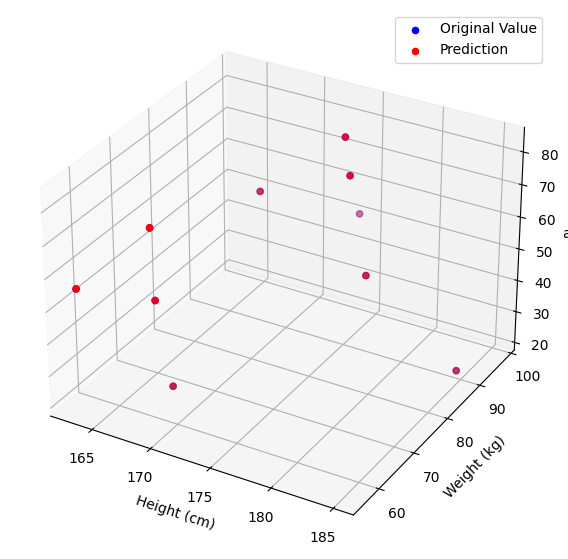

In [227]:
# Plot erstellen
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Tatsächliche Datenpunkte
ax.scatter(X_test['height (cm)'], X_test['weight (kg)'], y_test, color='blue', label='Original Value')

# Vorhersagen
ax.scatter(X_test['height (cm)'], X_test['weight (kg)'], y_pred, color='red', label='Prediction')

# Beschriftungen
ax.set_xlabel('Height (cm)')
ax.set_ylabel('Weight (kg)')
ax.set_zlabel('age')
ax.legend()
plt.savefig('prediction1.png')

plt.show()

# Heart Rate zuweisung zu Alter usw

In [28]:
import pandas as pd

# Angenommen, deine Tabelle heißt 'data.csv'
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/bmi_cda.csv')

# Konvertiere 'TimeStamp' und 'EffectiveTime' zu datetime
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
df['EffectiveTime'] = pd.to_datetime(df['EffectiveTime'])

# Definiere das Ende des DataFrame, um es in Vergleichen zu nutzen
end_time = pd.Timestamp('2099-12-31')  # Ein zukünftiges Datum als Endpunkt

# Kopiere den gesamten DataFrame, um alle Daten zu behalten
result_df = df.copy()

# Iteriere über die TimeStamp-Zeilen von 23 bis 350 für die Definition der Zeitintervalle
for i in range(22, min(350, len(df) - 1)):  # Verhindere das Überlaufen
    start_time = df.loc[i, 'TimeStamp']
    end_time = df.loc[i + 1, 'TimeStamp'] if i + 1 < 350 else end_time

    # Finde Zeilen ab 351, die im aktuellen Intervall liegen
    mask = (df.index >= 351) & (df['EffectiveTime'] >= start_time) & (df['EffectiveTime'] < end_time)
    
    # Aktualisiere die Daten für Zeilen, die den Bedingungen entsprechen
    if mask.any():
        # Erweitere die Liste der zu aktualisierenden Spalten um 'BMI_CDA'
        cols_to_update = df.columns[df.columns.get_loc('study ID'):df.columns.get_loc('Steps')+1].tolist() + ['BMI_CDA']
        for col in cols_to_update:
            result_df.loc[mask, col] = df.loc[i, col]

# Speichere die resultierende Tabelle
result_df.to_csv('final_result_table.csv', index=False)

In [34]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/final_result_table_07.04.csv')

df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])

# Schritt 2: Einzigartige TimeStamps und BMI_CDA-Werte erfassen
unique_time_bmi_pairs = df.iloc[22:350].drop_duplicates(subset=['TimeStamp'], keep='first')[['TimeStamp', 'BMI_CDA']]

# Schritt 3 & 4: Durchgehen der einzigartigen TimeStamp-Werte und Aktualisieren der BMI_CDA-Werte
for _, row in unique_time_bmi_pairs.iterrows():
    timestamp, bmi_cda_value = row['TimeStamp'], row['BMI_CDA']
    # Setze den BMI_CDA-Wert für alle übereinstimmenden TimeStamps ab Zeile 1996
    match_indices = df.index[(df['TimeStamp'] == timestamp) & (df.index >= 1995)]
    df.loc[match_indices, 'BMI_CDA'] = bmi_cda_value

# Schritt 5: Speichere das Ergebnis in einer neuen Tabelle
df.to_csv('updated_data.csv', index=False)  # Passe den Pfad entsprechend an

In [66]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/cleaned_data.csv')

# Konvertiere 'endDate' zu datetime, um sicherzustellen, dass die Vergleiche korrekt sind
df['EffectiveTime'] = pd.to_datetime(df['EffectiveTime'])

# Wir arbeiten nur mit dem spezifischen Bereich von Zeilen
df_subset = df.iloc[1753:11138].copy()  # Python-Indizes starten bei 0, daher 22 statt 23

# Entferne Duplikate basierend auf 'endDate' innerhalb des Bereichs
df_subset.drop_duplicates(subset='EffectiveTime', keep='first', inplace=True)

# Jetzt müssen wir diesen bereinigten Subset in den originalen DataFrame reintegrieren
# Zuerst entfernen wir den alten Bereich aus dem originalen DataFrame
df = pd.concat([df.iloc[:1753], df.iloc[11138:]]).reset_index(drop=True)

# Dann fügen wir den bereinigten Subset in den DataFrame ein, direkt vor dem Index 22
df = pd.concat([df.iloc[:1753], df_subset, df.iloc[1753:]]).reset_index(drop=True)

# Speichere das Ergebnis in einer neuen Tabelle
df.to_csv('cleaned_data.csv', index=False)


In [68]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/cleaned_data.csv')

df['BMI_CDA'] = df['BMI_CDA'].where(df['BMI_CDA'] != df['BMI_CDA'].shift(), np.nan)

df.to_csv('cleaned_data_FINAL.csv', index=False)

# ML mit Heart Rate

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Für 3D-Plots

In [18]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/cleaneddata_with_bmi_flag.csv')
df.dropna(subset=['BMI'], inplace=True)
print(df['BMI'])

0     25.858291
1     22.724403
2     21.633315
3     30.350330
4     26.959840
5     26.029878
6     27.885187
7     24.615150
8     22.038567
9     21.671258
10    27.774271
11    32.699168
12    27.281746
13    21.077195
14    21.847009
15    21.061628
16    22.862369
17    28.409091
18    30.299205
19    27.143037
20    23.030045
21    22.052190
22    19.535423
23    23.167430
24    23.030045
25    32.368873
26    22.589551
27    31.541314
28    20.703125
29    22.942130
30    30.110991
31    22.471209
32    25.858291
33    24.567474
34    21.671258
35    25.858291
36    26.264944
37    24.653740
38    25.106333
39    23.030045
40    27.064052
41    26.543210
42    21.671258
43    28.088991
44    30.189591
45    22.912259
46    24.857955
47    21.203105
48    29.387755
49    33.251550
Name: BMI, dtype: float64


In [19]:

if df['BMI'].dtype == object:
    df['BMI'] = df['BMI'].str.replace(',', '.').astype(float)

X = df['MeasurementValue']  # Features
y = df['BMI']  # Zielvariable

# Aufteilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modell trainieren
model = LinearRegression()
# Wichtig: X_train und X_test müssen als 2D-array übergeben werden
model.fit(X_train.values.reshape(-1, 1), y_train)

# Vorhersagen machen
y_pred = model.predict(X_test.values.reshape(-1, 1))

# Modellbewertung
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 3.6387453806413244


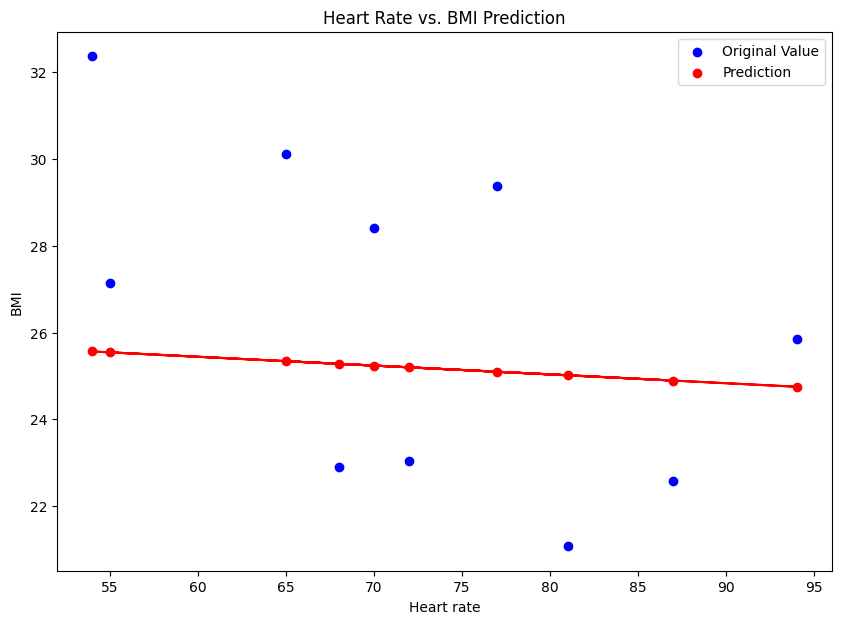

In [24]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 7))

# Tatsächliche Datenpunkte
plt.scatter(X_test, y_test, color='blue', label='Original Value')

# Vorhersagen
plt.scatter(X_test, y_pred, color='red', label='Prediction')

# Linie durch die roten Punkte (Vorhersagen)
plt.plot(X_test, y_pred, color='red')

# Beschriftungen
plt.xlabel('Heart rate')
plt.ylabel('BMI')
plt.title('Heart Rate vs. BMI Prediction')
plt.legend()

plt.savefig('prediction_BMI.png')
plt.show()

In [2]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv//final_updated_data_modified.csv')

print(df.columns)

# Konvertiere nun die Werte, nachdem die DataFrames zusammengeführt wurden
#df['weight (kg)'] = df['weight (kg)'].str.replace(',', '.').astype(float)
if df['BMI'].dtype == object:
    df['BMI'] = df['BMI'].str.replace(',', '.').astype(float)

X = df[['MeasurementValue','Heart rate 2', 'weight (kg)']]  # Features
y = df['BMI']  # Zielvariable

# Aufteilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modell trainieren
model = LinearRegression()
model.fit(X_train, y_train)

# Vorhersagen machen
y_pred = model.predict(X_test)

Index(['Unnamed: 0', 'PatientID', 'Gender', 'BirthDate', 'ObservationID',
       'ObservationType', 'Code', 'DisplayName', 'Heart rate 10',
       'Heart rate 9', 'Heart rate 8', 'Heart rate 7', 'Heart rate 6',
       'Heart rate 5', 'Heart rate 4', 'Heart rate 3', 'Heart rate 2',
       'Heart rate 1', 'Unit', 'EffectiveTime', 'BMI', 'BMI_Over_25', 'type',
       'sourceName', 'value', 'unit', 'startDate', 'endDate', 'study ID',
       'HR_before', 'HR_after', 'RR_before', 'RR_after', 'gender',
       'height (cm)', 'age (years)', 'weight (kg)', 'TimeStamp',
       'leg Length (cm)', 'Subject/Patient', 'Distance (m)', 'Turns',
       'Step Count', 'Step Count(After 6MWT)', 'Rounds',
       'Distance (per round)', 'Counted Steps', 'Calculated m',
       'Carrying location', 'Distance (km)', 'Steps (before)', 'Steps (after)',
       'Steps', 'RR_before_systolic', 'RR_before_diastolic',
       'RR_after_systolic', 'RR_after_diastolic', 'RR_before_category',
       'RR_after_category', 'R

KeyError: "['MeasurementValue'] not in index"

In [303]:
model = LinearRegression()
model.fit(X_train, y_train)

# Vorhersage auf dem Testset
y_pred = model.predict(X_test)

# Modellbewertung
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 1.5721321532803403


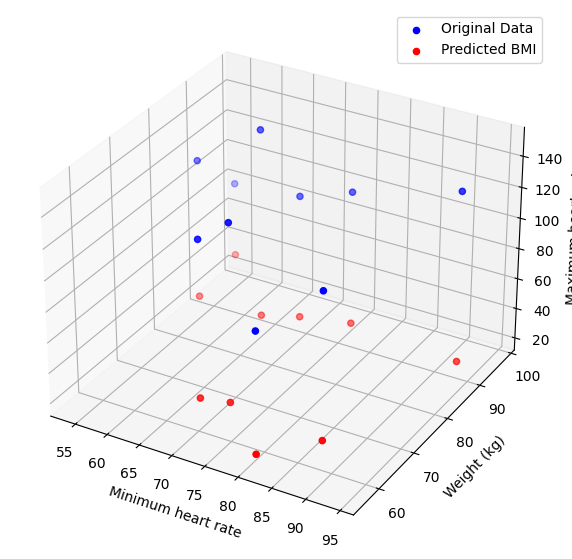

In [305]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Tatsächliche Datenpunkte
ax.scatter(X_test['MeasurementValue'], X_test['weight (kg)'], X_test['Heart rate 2'], color='blue', label='Original Data')

# Vorhersagen als Punkte
ax.scatter(X_test['MeasurementValue'], X_test['weight (kg)'], y_pred, color='red', label='Predicted BMI')

# Beschriftungen
ax.set_xlabel('Minimum heart rate')
ax.set_ylabel('Weight (kg)')
ax.set_zlabel('Maximum heart rate')
ax.legend()

# Speichern und Anzeigen des Plots
plt.savefig('bmi_prediction.png')
plt.show()

In [265]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/cleaneddata_with_bmi_flag.csv')

print(df.columns)

Index(['Unnamed: 0', 'PatientID', 'Gender', 'BirthDate', 'ObservationID',
       'ObservationType', 'Code', 'DisplayName', 'MeasurementValue',
       'Heart rate 2', 'Unit', 'EffectiveTime', 'type', 'sourceName', 'value',
       'unit', 'startDate', 'endDate', 'study ID', 'height (cm)',
       'age (years)', 'weight (kg)', 'BMI', 'BMI_Over_25', 'TimeStamp',
       'leg Length (cm)', 'Subject/Patient', 'Distance (m)', 'Turns',
       'Step Count', 'Step Count(After 6MWT)', 'Rounds',
       'Distance (per round)', 'Counted Steps', 'Calculated m',
       'Carrying location', 'Distance (km)', 'Steps (before)', 'Steps (after)',
       'Steps'],
      dtype='object')


In [269]:

#df['Distance (km)'] = df['Distance (km)'].str.replace(',', '.').astype(float)
#df['Heart rate 2'] = df['Heart rate 2'].str.replace(',', '.').astype(float)

X = df[['age (years)', 'Distance (km)', 'MeasurementValue']]  # Features
y = df['Heart rate 2']  # Zielvariable

# Aufteilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modell trainieren
model = LinearRegression()
model.fit(X_train, y_train)

# Vorhersagen machen
y_pred = model.predict(X_test)

In [270]:
model = LinearRegression()
model.fit(X_train, y_train)

# Vorhersage auf dem Testset
y_pred = model.predict(X_test)

# Modellbewertung
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 19.417070060452346


In [28]:
file_path = '/Users/tanjazast/Desktop/jupyter_folder/csv/updated_data_with_gender.csv'

df = pd.read_csv(file_path)

df['gender_number'] = df['gender'].map({'male': 0, 'female': 1})

new_file_path = 'updated_data_with_gender_number.csv'
df.to_csv(new_file_path, index=False)


In [174]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/updated_data_with_numerical_BP_categories_23.05.csv')
df = df.dropna()

print(df['RR_before_category_num'])

0     3
1     1
2     4
3     4
4     3
5     3
6     3
7     1
8     2
9     4
10    1
11    1
12    3
13    1
14    3
15    3
16    4
17    4
19    3
20    3
21    1
22    3
23    3
24    1
25    4
26    3
27    3
28    2
29    4
30    3
32    3
33    4
34    3
35    2
36    1
37    3
Name: RR_before_category_num, dtype: int64


In [175]:
df['Subject/Patient'] = df['Subject/Patient'].str.replace('S', 's').str.replace('P', 'p').str.strip().str.lower()

# Entferne Zeilen, in denen 'Subject/Patient' NaN ist
df = df.dropna(subset=['Subject/Patient'])

# Sicherstellen, dass nur die erwarteten einzigartigen Werte vorhanden sind
print(df['Subject/Patient'].unique())

['subject' 'patient']


In [176]:
# Definiere die Mapping-Funktion für die Spalte "Subject/Patient"
subject_patient_mapping = {
    'subject': 0,
    'patient': 1
}

# Wende das Mapping auf die Spalte "Subject/Patient" an
df['Subject_Patient_Number'] = df['Subject/Patient'].map(subject_patient_mapping)

# Überprüfe auf fehlende Werte oder Missverständnisse in der Spalte, die nicht abgebildet wurden
if df['Subject_Patient_Number'].isnull().any():
    print("Es gibt Einträge in 'Subject/Patient', die nicht korrekt zugeordnet wurden.")

df = df.dropna()
# Speichere den aktualisierten DataFrame
new_file_path = 'final_updated_data.csv'
df.to_csv(new_file_path, index=False)


In [32]:
X = df[['Heart rate 1', 'Heart rate 2', 'Heart rate 3', 'Heart rate 4', 'Heart rate 5', 'Heart rate 6', 'Heart rate 7', 'Heart rate 8', 'Heart rate 9', 'Heart rate 10', 'weight (kg)', 'height (cm)', 'age (years)', 'RR_before_category_num', 'RR_after_category_num', 'HR_after', 'HR_before']] 
y = df['Subject_Patient_Number']  

# Aufteilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modell trainieren
model = LinearRegression()
model.fit(X_train, y_train)

# Vorhersagen machen
y_pred = model.predict(X_test)

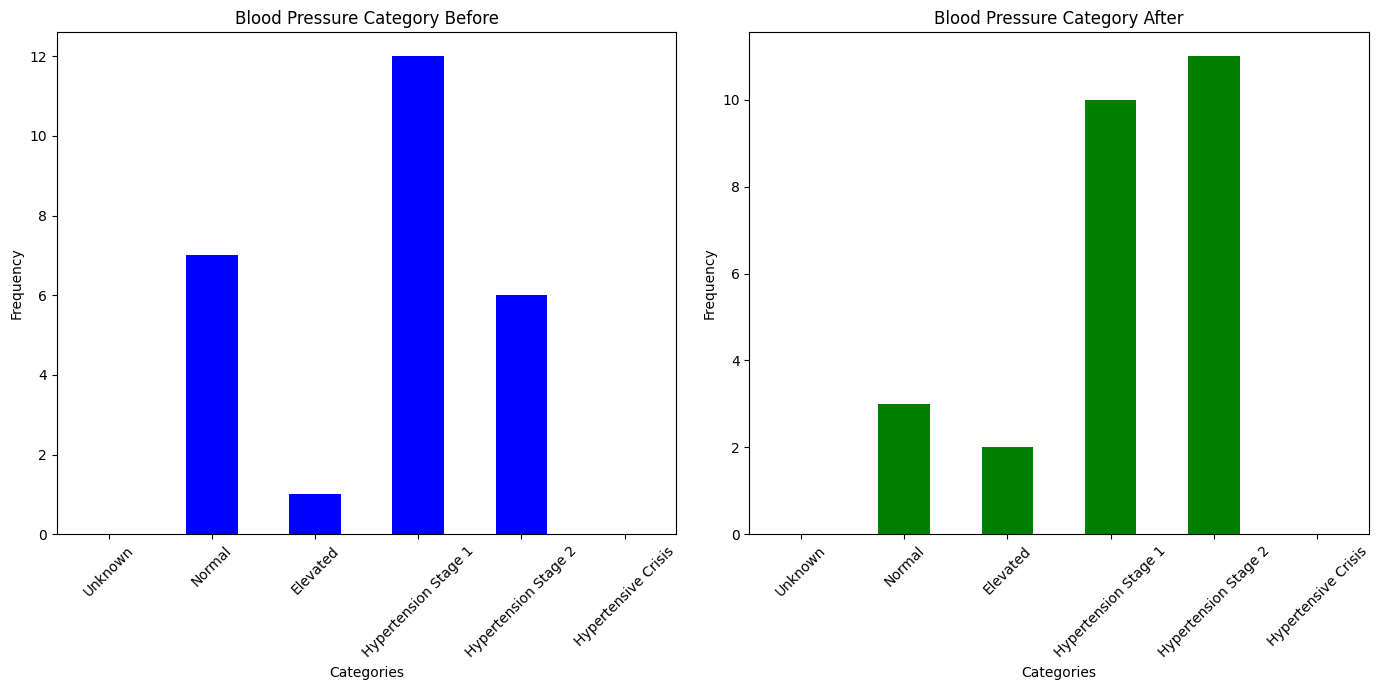

In [44]:
categories = {
    0: 'Unknown',
    1: 'Normal',
    2: 'Elevated',
    3: 'Hypertension Stage 1',
    4: 'Hypertension Stage 2',
    5: 'Hypertensive Crisis'
}

df['RR_before_category'] = df['RR_before_category_num'].map(categories)
df['RR_after_category'] = df['RR_after_category_num'].map(categories)

# Plotting
plt.figure(figsize=(14, 7))

# Subplot 1 for RR_before_category_num
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
df['RR_before_category'].value_counts().reindex(categories.values()).plot(kind='bar', color='blue')
plt.title('Blood Pressure Category Before')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Subplot 2 for RR_after_category_num
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
df['RR_after_category'].value_counts().reindex(categories.values()).plot(kind='bar', color='green')
plt.title('Blood Pressure Category After')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.tight_layout()

plt.savefig('BloodPressure.png')
plt.show()

In [33]:
model = LinearRegression()
model.fit(X_train, y_train)

# Vorhersage auf dem Testset
y_pred = model.predict(X_test)

# Modellbewertung
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 0.62591576880899


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Annahme: X_train, y_train, X_test, y_test sind bereits definiert und angemessen vorverarbeitet

# Modelle initialisieren
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
cat_model = CatBoostRegressor(n_estimators=100, learning_rate=0.1, depth=3, random_state=42, verbose=0)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Voting Regressor erstellen
voting_model = VotingRegressor([('xgb', xgb_model), ('cat', cat_model), ('rf', rf_model)])

# Voting Regressor trainieren
voting_model.fit(X_train, y_train)

# Vorhersagen machen
y_pred_ensemble = voting_model.predict(X_test)

# Modellbewertung
rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
print("RMSE for Ensemble Model:", rmse_ensemble)

RMSE for Ensemble Model: 0.24457868813134295


In [35]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Annahme: X_train, y_train, X_test, y_test sind bereits definiert und angemessen vorverarbeitet

# Modell initialisieren
cat_model = CatBoostRegressor(n_estimators=100, learning_rate=0.1, depth=3, random_state=42, verbose=0)

# Modell trainieren
cat_model.fit(X_train, y_train)

# Vorhersagen machen
y_pred_cat = cat_model.predict(X_test)

# Modellbewertung
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))
print("RMSE for CatBoost Model:", rmse_cat)

RMSE for CatBoost Model: 0.3607142169085551


In [36]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Assuming X_train, y_train, X_test, y_test are already defined and preprocessed appropriately

# Initialize the model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Model evaluation
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("RMSE for XGBoost Model:", rmse_xgb)

RMSE for XGBoost Model: 0.15511387706567975


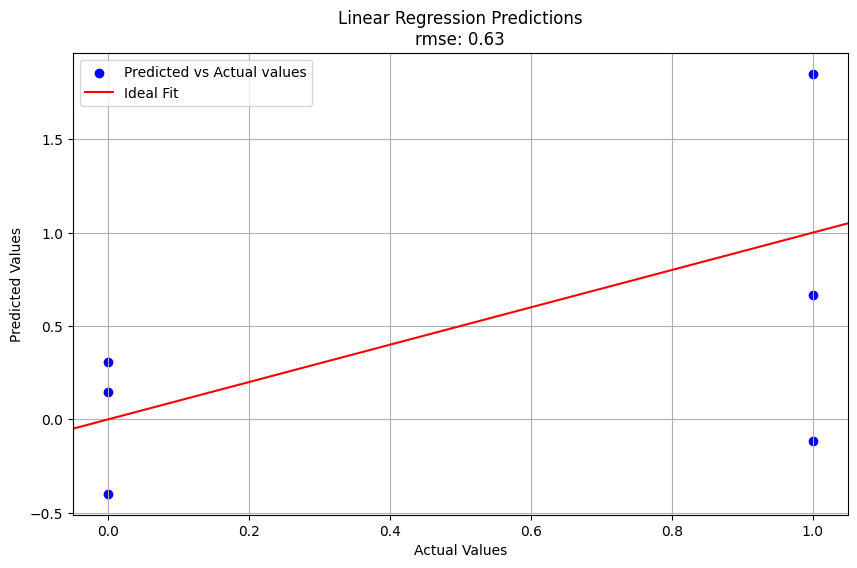

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual values')
plt.axline((y.min(), y.min()), (y.max(), y.max()), color='red', label='Ideal Fit')
plt.title(f'Linear Regression Predictions\nrmse: {rmse:.2f}')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.savefig('linReg_bloodPressure.png')
plt.show()

In [36]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

# Modell initialisieren
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Kreuzvalidierung durchführen
scores = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Mittleren RMSE berechnen
rmse_scores = np.sqrt(-scores)
print("RMSE: %0.2f (+/- %0.2f)" % (rmse_scores.mean(), rmse_scores.std() * 2))

# Modell trainieren und testen
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)

RMSE: 0.54 (+/- 0.34)


In [9]:
dateipfad = '/Users/tanjazast/Desktop/jupyter_folder/csv/cleaned_data_FINAL.csv'

spaltennamen = pd.read_csv(dateipfad, nrows=0).columns

# Lese die Daten ab Zeile 1754, unter Beibehaltung der Spaltennamen
# Beachte, dass skiprows auf 1753 gesetzt ist, um die ersten 1753 Zeilen zu überspringen
# und ab der 1754. Zeile zu beginnen
df = pd.read_csv(dateipfad, skiprows=range(1, 1753), names=spaltennamen, header=0)

df.to_csv('cleaneddata.csv')

In [362]:
import pandas as pd

# Lade die Tabelle
dateipfad = '/Users/tanjazast/Desktop/jupyter_folder/csv/cleaneddata.csv'
df = pd.read_csv(dateipfad)

# Bereinige die Daten, um sicherzustellen, dass keine NaN-Werte in den relevanten Spalten sind
df_clean = df.dropna(subset=['DisplayName', 'MeasurementValue'])

# Filtere nur die Herzfrequenzdaten
heart_rate_data = df_clean[df_clean['DisplayName'] == 'Heart rate']

# Gruppiere nach 'study ID', sortiere innerhalb jeder Gruppe und nimm die ersten zwei und letzten zwei Werte
def get_extreme_values(sub_df):
    sub_df = sub_df.sort_values(by='MeasurementValue')
    return pd.concat([sub_df.head(1), sub_df.tail(1)])

extreme_values = heart_rate_data.groupby('study ID').apply(get_extreme_values).reset_index(level=0, drop=True)

# Speichere den bereinigten DataFrame in einer neuen CSV-Datei
extreme_values.to_csv('try.csv', index=False)

In [366]:
import pandas as pd
import numpy as np

# Lade die Tabelle
dateipfad = '/Users/tanjazast/Desktop/jupyter_folder/csv/cleaneddata.csv'
df = pd.read_csv(dateipfad)

# Bereinige die Daten, um sicherzustellen, dass keine NaN-Werte in den relevanten Spalten sind
df_clean = df.dropna(subset=['BMI_CDA', 'DisplayName', 'MeasurementValue'])

# Finde Indizes, wo BMI_CDA keine NaN-Werte hat
bmi_indices = df_clean.index[df_clean['BMI_CDA'].notna()]

# Zu entfernende Indizes
to_remove_indices = []

# Gehe durch jeden BMI_CDA-Wert und finde das Intervall bis zum nächsten Wert
for start, end in zip(bmi_indices, bmi_indices[1:].to_list() + [np.inf]):
    # Selektiere die Intervall Daten
    interval_data = df_clean.loc[start:end]
    heart_rate_interval_data = interval_data[interval_data['DisplayName'] == 'Heart rate']
    
    # Falls weniger als 2 Herzfrequenzwerte im Intervall vorhanden sind, mache nichts
    if len(heart_rate_interval_data) <= 2:
        continue
    
    # Finde den minimalen und maximalen Herzfrequenzwert
    min_hr = heart_rate_interval_data['MeasurementValue'].min()
    max_hr = heart_rate_interval_data['MeasurementValue'].max()
    
    # Füge alle Indizes außer den minimalen und maximalen zum Entfernen hinzu
    to_remove = heart_rate_interval_data.index[(heart_rate_interval_data['MeasurementValue'] != min_hr) & 
                                              (heart_rate_interval_data['MeasurementValue'] != max_hr)]
    to_remove_indices.extend(to_remove)

# Entferne alle Herzfrequenzdaten, die nicht min oder max sind
df_cleaned_heart_rates = df_clean.drop(to_remove_indices)

# Speichere den bereinigten DataFrame in einer neuen CSV-Datei
df_cleaned_heart_rates.to_csv('cleaned_heart_rate_intervals.csv', index=False)

In [378]:
import pandas as pd

dateipfad = '/Users/tanjazast/Desktop/jupyter_folder/csv/cleaned_random_heart_rate_data.csv'
df = pd.read_csv(dateipfad)

# Finde den Spaltenindex von 'BMI_CDA'
bmi_cda_index = df.columns.get_loc('BMI_CDA') + 1

# Füge die neue Spalte 'BMI_Over_25' hinzu, setze Werte nur, wenn 'BMI_CDA' nicht NaN ist
df.insert(bmi_cda_index, 'BMI_Over_25', np.where(df['BMI_CDA'].notna(), (df['BMI_CDA'] > 25).astype(int), np.nan))

# Speichere die modifizierte Tabelle in einer neuen CSV-Datei
neuer_dateipfad = 'cleaneddata_with_bmi_flag.csv'
df.to_csv(neuer_dateipfad, index=False)

In [256]:
dateipfad= '/Users/tanjazast/Desktop/jupyter_folder/filtered_apple_health_export.csv'
df = pd.read_csv(dateipfad)

print(df[df['type'] == 'ActiveEnergyBurned'])


                    type               sourceName  value  unit  \
14    ActiveEnergyBurned  Apple Watch von Rüdiger  0.062  kcal   
19    ActiveEnergyBurned  Apple Watch von Rüdiger  0.479  kcal   
21    ActiveEnergyBurned  Apple Watch von Rüdiger  0.479  kcal   
23    ActiveEnergyBurned  Apple Watch von Rüdiger  0.479  kcal   
25    ActiveEnergyBurned  Apple Watch von Rüdiger  0.479  kcal   
...                  ...                      ...    ...   ...   
7716  ActiveEnergyBurned  Apple Watch von Rüdiger  0.053  kcal   
7719  ActiveEnergyBurned  Apple Watch von Rüdiger   0.04  kcal   
7720  ActiveEnergyBurned  Apple Watch von Rüdiger  0.073  kcal   
7730  ActiveEnergyBurned  Apple Watch von Rüdiger  1.035  kcal   
7741  ActiveEnergyBurned  Apple Watch von Rüdiger  0.376  kcal   

                      startDate                    endDate  \
14    2024-07-17 14:15:56+02:00  2024-07-17 14:15:59 +0200   
19    2024-07-17 14:15:54+02:00  2024-07-17 14:15:56 +0200   
21    2024-07-17 14:1

In [260]:
#19.07 und 21.07

import pandas as pd

dateipfad = '/Users/tanjazast/Desktop/jupyter_folder/filtered_apple_health_export.csv'
df = pd.read_csv(dateipfad)

df['startDate'] = pd.to_datetime(df['startDate'])

# Konvertieren der 'value'-Spalte in numerische Werte
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# Überprüfen, ob die 'value'-Spalte erfolgreich in numerische Werte konvertiert wurde
print(df['value'].head(20))  # Überprüfen Sie die ersten 20 Zeilen

# Typen, die aufsummiert werden sollen
types_to_sum = [
    'StepCount', 'AppleExerciseTime', 'PhysicalEffort', 'WalkingAsymmetryPercentage',
    'WalkingDoubleSupportPercentage', 'WalkingSpeed', 'WalkingStepLength', 'OxygenSaturation', 
    'ActiveEnergyBurned', 'BasalEnergyBurned', 'DistanceWalkingRunning'
]

# Typen, die direkt übernommen werden sollen
types_to_keep = ['Height', 'BodyMass']

# Initialisierungen für die neuen Spalten und die Summen
for k in range(1, 101):
    df[f'HeartRate_{k}'] = pd.NA
sums = {type_name: 0 for type_name in types_to_sum}
kept_values = {type_name: None for type_name in types_to_keep}
heart_rate_values = []

# Einlesen der kleinen Tabelle und Konvertieren des Datums und der Uhrzeit in das gewünschte Format
small_df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/bereinigte_datei.csv')
small_df['Datum'] = small_df['Datum'].str.strip() + ' 2024'
small_df['DateTime'] = pd.to_datetime(small_df['Datum'] + ' ' + small_df['Uhrzeit'], format='%d.%m. %Y %H:%M')
small_df['DateTime'] = small_df['DateTime'].dt.tz_localize('Europe/Berlin')

# Liste für die Intervalle erstellen
intervals = []

# Erstellen der Intervalle (4 Minuten davor und 10 Minuten danach)
for dt in small_df['DateTime']:
    start_interval = dt - timedelta(minutes=4)
    end_interval = dt + timedelta(minutes=10)
    intervals.append((start_interval, end_interval))

# DataFrame für die Summen pro Intervall vorbereiten
sum_df = pd.DataFrame()

# Funktion zum Speichern der Summen und Zurücksetzen
def save_interval_sums(interval_start, interval_end, interval_sums, interval_kept, heart_rates):
    global sum_df
    interval_data = df[(df['startDate'] >= interval_start) & (df['startDate'] <= interval_end)]
    interval_sums_df = pd.DataFrame([interval_sums])
    interval_kept_df = pd.DataFrame([interval_kept])
    
    # Erstellen von DataFrames für die Listen
    heart_rate_df = pd.DataFrame([heart_rates], columns=[f'HeartRate_{i+1}' for i in range(len(heart_rates))])
    
    # Behalte alle Spalten ab 'type' bis 'creationDate'
    columns_to_keep = df.columns[df.columns.get_loc('type'):df.columns.get_loc('creationDate')+1]
    interval_sums_df = pd.concat([
        interval_sums_df, interval_kept_df, heart_rate_df,
        interval_data[columns_to_keep].iloc[0:1].reset_index(drop=True)
    ], axis=1)
    
    sum_df = pd.concat([sum_df, interval_sums_df], ignore_index=True)
    for key in interval_sums.keys():
        interval_sums[key] = 0
    for key in interval_kept.keys():
        interval_kept[key] = None
    heart_rates.clear()

# Durch die Intervalle iterieren und Summen berechnen
for start_interval, end_interval in intervals:
    interval_data = df[(df['startDate'] >= start_interval) & (df['startDate'] <= end_interval)]
    
    # Debug: Zeige alle Zeilen im aktuellen Intervall
    print(f"Intervall: {start_interval} - {end_interval}")
    print(interval_data[['type', 'value']])
    
    heart_rates = interval_data[interval_data['type'] == 'HeartRate']['value'].tolist()

    # Sicherstellen, dass es mindestens 100 Heart Rates gibt
    if len(heart_rates) < 100:
        heart_rates.extend([pd.NA] * (100 - len(heart_rates)))

    # Heart Rates in neue Spalten schreiben
    if not interval_data.empty:
        for j in range(100):
            df.loc[interval_data.index[0], f'HeartRate_{j+1}'] = heart_rates[j]
        
        # Summieren der Werte für die definierten Typen
        for _, row in interval_data.iterrows():
            if row['type'] in types_to_sum:
                value = row['value']
                if pd.notna(value):
                    sums[row['type']] += value
                else:
                    print(f"Skipping NaN value for type: {row['type']}")
            if row['type'] in types_to_keep:
                kept_values[row['type']] = row['value']
        
        # Debug-Ausgaben
        for key in sums.keys():
            print(f"Summe für {key}: {sums[key]}")

        # Speichern der Summen für das Intervall
        save_interval_sums(start_interval, end_interval, sums, kept_values, heart_rates)

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'cleaned_data_with_heart_rates_and_sums-21.07.csv'
sum_df.to_csv(output_path, index=False)


0      67.000
1       4.500
2       0.297
3       0.000
4     127.000
5     127.000
6     125.000
7     125.000
8     125.000
9     124.000
10    124.000
11    123.000
12    131.000
13    132.000
14      0.062
15      0.100
16      0.100
17      2.400
18    135.000
19      0.479
Name: value, dtype: float64
Intervall: 2024-07-10 13:59:00+02:00 - 2024-07-10 14:13:00+02:00
                    type   value
7073  ActiveEnergyBurned   0.053
7074   BasalEnergyBurned   0.230
7075           HeartRate  78.000
7076  ActiveEnergyBurned   0.053
7077   BasalEnergyBurned   0.230
...                  ...     ...
7737      AppleStandHour     NaN
7738   BasalEnergyBurned   0.230
7739      AppleStandTime   1.000
7740   BasalEnergyBurned   0.230
7741  ActiveEnergyBurned   0.376

[669 rows x 2 columns]
Skipping NaN value for type: DistanceWalkingRunning
Skipping NaN value for type: BasalEnergyBurned
Skipping NaN value for type: ActiveEnergyBurned
Summe für StepCount: 1100.0
Summe für AppleExerciseTime: 7.0

/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_90338/718528352.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'HeartRate_{k}'] = pd.NA
/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_90338/718528352.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'HeartRate_{k}'] = pd.NA
/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_90338/718528352.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

Skipping NaN value for type: ActiveEnergyBurned
Skipping NaN value for type: BasalEnergyBurned
Skipping NaN value for type: DistanceWalkingRunning
Summe für StepCount: 790.0
Summe für AppleExerciseTime: 7.0
Summe für PhysicalEffort: 58.00000000000001
Summe für WalkingAsymmetryPercentage: 0.03
Summe für WalkingDoubleSupportPercentage: 1.17
Summe für WalkingSpeed: 15.732
Summe für WalkingStepLength: 256.0
Summe für OxygenSaturation: 0
Summe für ActiveEnergyBurned: 31.785000000000032
Summe für BasalEnergyBurned: 25.429999999999993
Summe für DistanceWalkingRunning: 0.7926774999999997
Intervall: 2024-07-11 10:26:00+02:00 - 2024-07-11 10:40:00+02:00
                        type      value
5724          AppleStandTime   1.000000
5725  DistanceWalkingRunning   0.088893
5726      ActiveEnergyBurned   5.832000
5727       BasalEnergyBurned  22.546000
5728       BasalEnergyBurned   0.085000
...                      ...        ...
6320       StairDescentSpeed   0.381895
6321  DistanceWalkingRunning

In [112]:
#19.07
dateipfad = '/Users/tanjazast/Desktop/jupyter_folder/cleaned_data_with_heart_rates.csv'
df = pd.read_csv(dateipfad)

# Identifizieren der Zeilen, in denen 'HeartRate_1' einen Wert enthält
heart_rate_indices = df.index[df['HeartRate_1'].notna()].tolist()

# Initialisieren einer Liste, um die zu behaltenden Indizes zu speichern
indices_to_keep = set()

# Durch die identifizierten Indizes gehen und die vorhergehenden und nachfolgenden Zeilen hinzufügen
for idx in heart_rate_indices:
    indices_to_keep.add(idx)
    if idx > 0:
        indices_to_keep.add(idx - 1)
    if idx < len(df) - 1:
        indices_to_keep.add(idx + 1)

# Erstellen eines gefilterten DataFrames mit den zu behaltenden Indizes
filtered_df = df.loc[sorted(indices_to_keep)]

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'filtered_heart_rate_data.csv'
filtered_df.to_csv(output_path, index=False)

In [113]:
#19.07
dateipfad = '/Users/tanjazast/Desktop/jupyter_folder/filtered_heart_rate_data.csv'
df = pd.read_csv(dateipfad)

# Neue Spalten für Height und BodyMass hinzufügen
df['Height_value'] = pd.NA
df['Height_unit'] = pd.NA
df['BodyMass_value'] = pd.NA
df['BodyMass_unit'] = pd.NA

# Initialisierung des Index, um die Intervalle zu verfolgen
interval_start_index = None

# Durch den DataFrame iterieren und Intervalle identifizieren
for i in range(len(df) - 1):
    if (df.loc[i, 'type'] == 'Height' and df.loc[i + 1, 'type'] == 'BodyMass') or \
       (df.loc[i, 'type'] == 'BodyMass' and df.loc[i + 1, 'type'] == 'Height'):
        
        # Speichere die Werte und Einheiten der beiden aufeinanderfolgenden Einträge
        if df.loc[i, 'type'] == 'Height':
            df.loc[i, 'Height_value'] = df.loc[i, 'value']
            df.loc[i, 'Height_unit'] = df.loc[i, 'unit']
            df.loc[i, 'BodyMass_value'] = df.loc[i + 1, 'value']
            df.loc[i, 'BodyMass_unit'] = df.loc[i + 1, 'unit']
        else:
            df.loc[i, 'BodyMass_value'] = df.loc[i, 'value']
            df.loc[i, 'BodyMass_unit'] = df.loc[i, 'unit']
            df.loc[i, 'Height_value'] = df.loc[i + 1, 'value']
            df.loc[i, 'Height_unit'] = df.loc[i + 1, 'unit']

        # Markiere die nächste Zeile als bereits verarbeitet
        df.loc[i + 1, 'processed'] = True

# Entferne die Spalte 'processed', die wir zur Markierung verwendet haben
if 'processed' in df.columns:
    df = df.drop(columns=['processed'])

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'height_bodymass_nebeneinander.csv'
df.to_csv(output_path, index=False)

In [121]:
#19.07
dateipfad = '/Users/tanjazast/Desktop/jupyter_folder/shifted_values.csv'
df = pd.read_csv(dateipfad)

filtered_df = df[df['HeartRate_1'].notna()]

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'filtered_heart_rate_and_height_non_empty_2.csv'
filtered_df.to_csv(output_path, index=False)

In [123]:
#20.07
dateipfad = '/Users/tanjazast/Desktop/jupyter_folder/filtered_heart_rate_and_height_non_empty_2.csv'
df = pd.read_csv(dateipfad)

gender_values = ['female', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'male']
age_values = [24, 54, 24, 57, 72, 72, 63, 43, 71, 59, 59, 89]

# Überprüfen, ob die Länge der Werte der Länge des DataFrames entspricht
if len(gender_values) != len(df) or len(age_values) != len(df):
    raise ValueError("Die Länge der gender- oder age-Werte stimmt nicht mit der Länge des DataFrames überein.")

# Neue Spalten hinzufügen
df.insert(loc=df.columns.get_loc('Height_value'), column='gender', value=gender_values)
df.insert(loc=df.columns.get_loc('Height_value') + 1, column='age (years)', value=age_values)

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'enhanced_table_with_gender_and_age.csv'
df.to_csv(output_path, index=False)

In [261]:
#21.07

dateipfad = '/Users/tanjazast/Desktop/jupyter_folder/cleaned_data_with_heart_rates_and_sums-21.07.csv'
df = pd.read_csv(dateipfad)

# Werte für Height und BodyMass in den spezifischen Zeilen
height_bodymass_values = {
    0: {'Height': 163, 'BodyMass': 62},
    1: {'Height': 163, 'BodyMass': 63},
    5: {'Height': 181, 'BodyMass': 103},
    7: {'Height': 177, 'BodyMass': 100},
    10: {'Height': 176, 'BodyMass': 97}
}

# Aktualisieren der spezifischen Zeilen mit den Werten
for index, values in height_bodymass_values.items():
    df.loc[index, 'Height'] = values['Height']
    df.loc[index, 'BodyMass'] = values['BodyMass']

# Werte für gender und age
gender_values = ['male', 'female', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'male']
age_values = [89, 59, 59, 43, 71, 63, 72, 72, 57, 24, 31, 54]

# Überprüfen, ob die Länge der Werte der Länge des DataFrames entspricht
if len(gender_values) != len(df) or len(age_values) != len(df):
    raise ValueError("Die Länge der gender- oder age-Werte stimmt nicht mit der Länge des DataFrames überein.")

# Neue Spalten hinzufügen
df.insert(loc=df.columns.get_loc('Height'), column='gender', value=gender_values)
df.insert(loc=df.columns.get_loc('Height') + 1, column='age (years)', value=age_values)

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'enhanced_table_with_gender_and_age.csv'
df.to_csv(output_path, index=False)

In [119]:
#20.07
dateipfad = '/Users/tanjazast/Desktop/jupyter_folder/filtered_heart_rate_and_height_non_empty.csv'
df = pd.read_csv(dateipfad)

# Definieren der zu verschiebenden Zeilenpaare
row_pairs = [(4, 5), (6, 7), (8, 9), (10, 11), (14, 15), (16, 17)]

# Spalten, die verschoben werden sollen
columns_to_shift = ['Height_value', 'Height_unit', 'BodyMass_value', 'BodyMass_unit']

# Verschieben der Werte
for src, dst in row_pairs:
    if src < len(df) and dst < len(df):
        df.loc[dst, columns_to_shift] = df.loc[src, columns_to_shift]
        df.loc[src, columns_to_shift] = pd.NA

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'shifted_values.csv'
df.to_csv(output_path, index=False)

In [300]:
path = '/Users/tanjazast/Desktop/jupyter_folder/enhanced_data_with_bmi.csv'
df = pd.read_csv(path)

# Alle Spalten ausgeben
print("Spaltennamen der Tabelle:")
print(df.columns)

Spaltennamen der Tabelle:
Index(['StepCount', 'AppleExerciseTime', 'PhysicalEffort',
       'WalkingAsymmetryPercentage', 'WalkingDoubleSupportPercentage',
       'WalkingSpeed', 'WalkingStepLength', 'OxygenSaturation', 'HeartRate_1',
       'HeartRate_2',
       ...
       'RR_after_category_num', 'Subject_Patient_Number', 'RR_before',
       'RR_after', 'HR_before', 'HR_after', 'gender', 'real_Distance', 'BMI',
       'BMI_Over_25'],
      dtype='object', length=157)


In [263]:
#20.07 und 21.07

final_data_path = '/Users/tanjazast/Desktop/jupyter_folder/csv/final_data_07.06.csv'
second_table_path = '/Users/tanjazast/Desktop/jupyter_folder/enhanced_table_with_gender_and_age-21.07.csv'

final_df = pd.read_csv(final_data_path)
second_df = pd.read_csv(second_table_path)

# Bereinigung der ersten Tabelle: Löschen der Spalten von 'AppleExerciseTime' bis einschließlich 'end_index'
columns_to_delete = final_df.loc[:, 'start_index':'end_index'].columns
final_df.drop(columns=columns_to_delete, inplace=True)

# Formatieren der 'creationDate'-Spalte in der zweiten Tabelle
second_df['creationDate'] = pd.to_datetime(second_df['creationDate']).dt.strftime('%Y-%m-%d %H:%M:%S%z')

# Umbenennen der Spalten in der zweiten Tabelle
second_df.rename(columns={
    'creationDate': 'TimeStamp',
    'ActiveEnergyBurned': 'Sum_ActiveEnergyBurned',
    'DistanceWalkingRunning': 'Sum_DistanceWalkingRunning',
    'BasalEnergyBurned': 'Sum_BasalEnergyBurned',
    'Height': 'height (cm)',
    'BodyMass': 'weight (kg)',
    'age (years)': 'age (years)', 
    'StepCount': 'StepCount', 
    'AppleExerciseTime': 'AppleExerciseTime', 
    'PhysicalEffort': 'PhysicalEffort',
    'WalkingAsymmetryPercentage': 'WalkingAsymmetryPercentage', 
    'WalkingDoubleSupportPercentage': 'WalkingDoubleSupportPercentage',
    'WalkingSpeed': 'WalkingSpeed', 
    'WalkingStepLength': 'WalkingStepLength', 
    'OxygenSaturation': 'OxygenSaturation'
    
}, inplace=True)

# Sicherstellen, dass alle benötigten Spalten in der ersten Tabelle vorhanden sind
required_columns = [
    'TimeStamp', 'Sum_ActiveEnergyBurned', 'Sum_DistanceWalkingRunning', 'Sum_BasalEnergyBurned',
    'gender', 'height (cm)', 'weight (kg)', 'age (years)','StepCount', 'AppleExerciseTime', 'PhysicalEffort',
       'WalkingAsymmetryPercentage', 'WalkingDoubleSupportPercentage',
       'WalkingSpeed', 'WalkingStepLength', 'OxygenSaturation'
] + [f'HeartRate_{i}' for i in range(1, 101)]

for col in required_columns:
    if col not in final_df.columns:
        final_df[col] = pd.NA

# Erstellen eines neuen DataFrames, um die Daten der zweiten Tabelle in das richtige Format zu bringen
new_data = pd.DataFrame(columns=final_df.columns)

# Hinzufügen der Werte aus der zweiten Tabelle zur neuen Tabelle
for col in second_df.columns:
    if col in new_data.columns:
        new_data[col] = second_df[col]

# Anhängen der neuen Daten an die erste Tabelle
merged_df = pd.concat([final_df, new_data], ignore_index=True)

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'merged_final_data-21.07.csv'
merged_df.to_csv(output_path, index=False)


In [264]:
#21.07

dateipfad = '/Users/tanjazast/Desktop/jupyter_folder/merged_final_data-21.07.csv'
df = pd.read_csv(dateipfad)

# Sicherstellen, dass die Spalten 'height (cm)' und 'weight (kg)' numerisch sind
df['height (cm)'] = pd.to_numeric(df['height (cm)'], errors='coerce')
df['weight (kg)'] = pd.to_numeric(df['weight (kg)'], errors='coerce')

# BMI berechnen
df['BMI'] = df['weight (kg)'] / (df['height (cm)'] / 100) ** 2

# Spalte 'BMI_Over_25' hinzufügen
df['BMI_Over_25'] = (df['BMI'] > 25).astype(int)

# Bereinigtes DataFrame in eine neue CSV-Datei speichern
output_path = 'enhanced_data_with_bmi.csv'
df.to_csv(output_path, index=False)


In [145]:
#20.07
dateipfad = '/Users/tanjazast/Desktop/jupyter_folder/csv/6MWT_Ergebnisse_mit_Kommentar_19.07.csv'
df = pd.read_csv(dateipfad)

df.loc[0] = ['10.07.', '14:03', 151, 0.32, '', "20'59''/km", 89, '66-91', "Keine Schlusskalibrierung, da zu k.o., dafür von letzter Runde Schrittanzahl verwendet Handy Hosentasche hinten", 5.58]
df.loc[4] = ['11.07.', '10:56', 2157, 0.49, 2776, "13'18''/km", 106, '102-108', "Mit FFP2 Maske losgelaufen, nach 2 min abgesetzt, erste Kalibrierung schlecht geschätzt, da zu viel Ablenkung. 40 eingegeben aber Schrittlänge von 1m eher unrealistisch", 12.33]
df.loc[7] = ['15.07.', '9:22', 0, 0.45, 749, "15'13''/km", 105, '99-115', "Unrealistisch, hat es aber so angezeigt", 9.65]

# Korrektur des Datums in Zeile 11
df.loc[10, 'Datum'] = '17.07.'
df.loc[8, 'Runden'] = '11.38'

# Speichern der bereinigten Datei
output_path = 'bereinigte_datei.csv'
df.to_csv(output_path, index=False)

In [150]:
#20.07

main_table_path = '/Users/tanjazast/Desktop/jupyter_folder/merged_final_data.csv'
additional_table_path = '/Users/tanjazast/Desktop/jupyter_folder/bereinigte_datei.csv'

main_df = pd.read_csv(main_table_path)
additional_df = pd.read_csv(additional_table_path)

# Zuordnen der Zeilen aus der zusätzlichen Tabelle zu den entsprechenden Zeilen in der Haupttabelle
row_mapping = {
    45: 12, 46: 11, 47: 10, 48: 9, 49: 8, 50: 7, 51: 6, 
    52: 4, 53: 5, 54: 3, 55: 2, 56: 1
}

# Mapping der Spaltennamen
column_mapping = {
    'Schrittanzahl vorher': 'Steps (before)',
    'Gesamtstrecke (km)': 'Distance (km)',
    'Schritte danach': 'Steps (after)',
    'Runden': 'Rounds'
}

# Übertragen der Daten von der zusätzlichen Tabelle zur Haupttabelle
for main_index, add_index in row_mapping.items():
    for add_col, main_col in column_mapping.items():
        main_df.loc[main_index, main_col] = additional_df.loc[add_index - 1, add_col]  # substracting 1 for zero-based indexing

output_path = 'merged_and_updated_final_data-20.07.csv'
main_df.to_csv(output_path, index=False)

In [179]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/merged_and_updated_final_data-20.07.csv')

# Identifizieren der Herzfrequenzspalten
heart_rate_columns = [col for col in df.columns if col.startswith('HeartRate_')]

# Umkehren der Herzfrequenzspalten ab Zeile 46
for idx in range(45, len(df)):
    heart_rate_values = df.loc[idx, heart_rate_columns].dropna().values
    df.loc[idx, heart_rate_columns[:len(heart_rate_values)]] = heart_rate_values[::-1]
    df.loc[idx, heart_rate_columns[len(heart_rate_values):]] = pd.NA

# Speichern der bereinigten Datei
output_path = 'merged_and_updated_final_data-20.07_reversed.csv'
df.to_csv(output_path, index=False)

In [152]:
import pandas as pd

dateipfad = '/Users/tanjazast/Desktop/jupyter_folder/csv/cleaneddata.csv'
df = pd.read_csv(dateipfad)

# Sicherstellen, dass keine NaN-Werte in den relevanten Spalten sind
df_clean = df.dropna(subset=['study ID', 'DisplayName', 'MeasurementValue'])

# Gruppieren nach 'study ID' und finden von Intervallen
grouped = df_clean.groupby('study ID')

# Zu behaltende Indizes
to_keep_indices = []

# Gehe durch jede Gruppe, definiert durch gleiche 'study ID'
for _, group in grouped:
    heart_rate_data = group[group['DisplayName'] == 'Heart rate']

    # Falls weniger als 50 Herzfrequenzwerte in der Gruppe vorhanden sind, behalte alle
    if len(heart_rate_data) <= 50:
        to_keep_indices.extend(heart_rate_data.index)
    else:
        # Wähle die ersten 50 Indizes aus den Herzfrequenzdaten der Gruppe
        first_indices = list(heart_rate_data.index)[:50]
        to_keep_indices.extend(first_indices)

# Behalte nur die relevanten Herzfrequenzdaten
df_cleaned_heart_rates = df_clean.loc[to_keep_indices]

# Speichere den bereinigten DataFrame in einer neuen CSV-Datei
df_cleaned_heart_rates.to_csv('cleaned_first_heart_rate_data_50Values.csv', index=False)

In [153]:
dateipfad = 'cleaned_first_heart_rate_data_50Values.csv'
df = pd.read_csv(dateipfad)

# Sicherstellen, dass die Spalte 'Effective Time' als Datetime-Objekt interpretiert wird
df['EffectiveTime'] = pd.to_datetime(df['EffectiveTime'])

# Tabelle nach der Spalte 'Effective Time' aufsteigend sortieren
df_sorted = df.sort_values(by='EffectiveTime')

# Optional: Index zurücksetzen
df_sorted = df_sorted.reset_index(drop=True)

# Sortierte Tabelle in einer neuen CSV-Datei speichern
df_sorted.to_csv('sorted_heart_rate_data.csv', index=False)


In [145]:
dateipfad = '/Users/tanjazast/Desktop/jupyter_folder/modified_cleaned_data_full_100Values.csv'
df = pd.read_csv(dateipfad)

# Finde Duplikate basierend auf 'study ID'
duplicate_mask = df['study ID'].duplicated(keep='first')

# Ersetze die Inhalte der Zeilen von 'study ID' bis 'Steps', wenn ein Duplikat gefunden wurde
columns_to_clear = df.loc[:, 'study ID':'Steps'].columns
df.loc[duplicate_mask, columns_to_clear] = pd.NA  # pd.NA setzt die Werte auf NA (Pandas' Not Available)

# Speichere die modifizierte Tabelle in einer neuen CSV-Datei
neuer_dateipfad = 'cleaneddata_with_cleared_duplicates_100Values.csv'
df.to_csv(neuer_dateipfad, index=False)

In [138]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/cleaneddata_with_cleared_duplicates.csv')

index_of_measurement_value = df.columns.get_loc('MeasurementValue')
df.insert(index_of_measurement_value + 1, 'Heart rate 2', np.nan)

# Jeden zweiten Wert aus "MeasurementValue" extrahieren und in "Heart rate 2" einsetzen, beginnend bei Index 1
df['Heart rate 2'].iloc[0::2] = df['MeasurementValue'].iloc[1::2].values

# Das Ergebnis in einer neuen CSV-Datei speichern
df.to_csv('modified_cleaned_data.csv', index=False)

/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_1780/1983595650.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Heart rate 2'].iloc[0::2] = df['MeasurementValue'].iloc[1::2].values


In [140]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/modified_cleaned_data.csv')

# Jede zweite Zeile löschen
df = df.iloc[0::2]

# Das Ergebnis in einer neuen CSV-Datei speichern
df.to_csv('modified_cleaned_data_every_second_row_removed.csv', index=False)

In [154]:
import pandas as pd
import numpy as np

df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/sorted_heart_rate_data.csv')

# Anzahl der Herzfrequenzdaten pro Zeile festlegen
num_values_per_row = 50

# Namen der neuen Spalten definieren
new_columns = [f'Heart rate {i+1}' for i in range(num_values_per_row)]

# Neue Spalten im DataFrame initialisieren
for col in new_columns:
    df.insert(df.columns.get_loc('MeasurementValue') + 1, col, np.nan)

# Die "MeasurementValue" Daten in die neuen Spalten verteilen
for i in range(0, len(df), num_values_per_row):
    # Überprüfen, ob genügend Daten für eine vollständige Zeile vorhanden sind
    end_index = i + num_values_per_row
    if end_index <= len(df):
        df.loc[i, new_columns] = df.loc[i:end_index - 1, 'MeasurementValue'].values
    else:
        # Wenn weniger als 10 Werte am Ende übrig sind, fülle so viele wie möglich
        remaining_values = len(df) - i
        df.loc[i, new_columns[:remaining_values]] = df.loc[i:len(df) - 1, 'MeasurementValue'].values

# Das Ergebnis in einer neuen CSV-Datei speichern
df.to_csv('modified_cleaned_data_full_50Values.csv', index=False)

In [155]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/modified_cleaned_data_full_50Values.csv')

In [156]:
print(df['Heart rate 1'])

0       89.0
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
2371     NaN
2372     NaN
2373     NaN
2374     NaN
2375     NaN
Name: Heart rate 1, Length: 2376, dtype: float64


In [157]:
if 'Heart rate 1' in df.columns:
    df.dropna(subset=['Heart rate 1'], inplace=True, axis=0)

# Das Ergebnis in einer neuen CSV-Datei speichern
df.to_csv('modified_cleaned_data_full_no_measurement_100Values.csv', index=False)

In [35]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/modified_cleaned_data_full_no_measurement_40Values.csv')

In [36]:
# Spalte 'BMI_CDA' zu 'BMI' umbenennen
df.rename(columns={'BMI_CDA': 'BMI'}, inplace=True)

df['weight (kg)'] = df['weight (kg)'].str.replace(',', '.').astype(float)

# BMI neu berechnen: BMI = weight / (height in m)^2
# Beachten: height (cm) muss zu height (m) konvertiert werden: height / 100
df['BMI'] = df['weight (kg)'] / ((df['height (cm)'] / 100) ** 2)

# Neue Spalte 'BMI_Over_25' hinzufügen und berechnen
df['BMI_Over_25'] = (df['BMI'] > 25).astype(int)

# Das Ergebnis in einer neuen CSV-Datei speichern
df.to_csv('updated_cleaned_data_with_BMI.csv', index=False)

# ML with random forest

In [270]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [282]:
# CSV-Datei einlesen
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/enhanced_data_with_bmi.csv')

# Ersetzen von 'male' mit 0 und 'female' mit 1 in der Spalte 'gender'
#df['gender'] = df['gender'].replace({'male': 0, 'female': 1})

print("Verteilung der Klassen im gesamten Datensatz:")
print(df['gender'].value_counts())

df['Subject/Patient'] = df['Subject/Patient'].str.replace('S', 's').str.replace('P', 'p').str.strip().str.lower()
df['Subject/Patient'] = df['Subject/Patient'].replace({'subject': 0, 'patient': 1})

# Umwandeln von Spalten in numerische Werte, falls erforderlich
df['Distance (km)'] = df['Distance (km)'].str.replace(',', '.').astype(float)

heart_rate_features = df.filter(like='HeartR')

other_features = df[['height (cm)', 'weight (kg)', 'Distance (km)', 'age (years)']]

features = pd.concat([heart_rate_features, other_features], axis=1)

# NaN-Werte durch 0 ersetzen
features.fillna(0, inplace=True)

X = features
y = df['gender']

# Aufteilen der Daten in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Verteilung der Klassen im gesamten Datensatz:
male      40
female    17
Name: gender, dtype: int64


In [283]:
print("Verteilung der Klassen in den Trainingsdaten:")
print(y_train.value_counts())
print("Verteilung der Klassen in den Testdaten:")
print(y_test.value_counts())

# Initialisieren und Trainieren des Modells mit class_weight='balanced'
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_clf.fit(X_train, y_train)

# Vorhersagen machen
y_pred = rf_clf.predict(X_test)
print("The prediction is", y_pred)

# Modellbewertung
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

print("The report is", report)

# Konvertieren des Klassifikationsberichts in ein DataFrame und dann in eine LaTeX-Tabelle
report_df = pd.DataFrame(report).transpose()
latex_table = report_df.to_latex()

print("Accuracy:", accuracy)
print("\nLaTeX table for Classification Report:\n", latex_table)

Verteilung der Klassen in den Trainingsdaten:
male      30
female    15
Name: gender, dtype: int64
Verteilung der Klassen in den Testdaten:
male      10
female     2
Name: gender, dtype: int64
The prediction is ['female' 'male' 'male' 'female' 'male' 'male' 'male' 'male' 'male' 'male'
 'male' 'male']
The report is {'female': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, 'male': {'precision': 0.8, 'recall': 0.8, 'f1-score': 0.8000000000000002, 'support': 10}, 'accuracy': 0.6666666666666666, 'macro avg': {'precision': 0.4, 'recall': 0.4, 'f1-score': 0.4000000000000001, 'support': 12}, 'weighted avg': {'precision': 0.6666666666666666, 'recall': 0.6666666666666666, 'f1-score': 0.6666666666666669, 'support': 12}}
Accuracy: 0.6666666666666666

LaTeX table for Classification Report:
 \begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &    support \\
\midrule
female       &   0.000000 &  0.000000 &  0.000000 &   2.000000 \\
male         &   0.800000 &  

/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_90338/884980730.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = report_df.to_latex()


In [284]:
print("Erste Zeilen der Features:")
print(features.head())

print("Erste Zeilen der Zielvariable:")
print(y.head())

Erste Zeilen der Features:
   HeartRate_1  HeartRate_2  HeartRate_3  HeartRate_4  HeartRate_5  \
0        132.0        131.0        130.0        128.0        125.0   
1        131.0        132.0        126.0        129.0        130.0   
2        132.0        135.0        133.0        138.0        139.0   
3         95.0         95.0         95.0         95.0         94.0   
4        102.0        101.0        101.0        110.0        111.0   

   HeartRate_6  HeartRate_7  HeartRate_8  HeartRate_9  HeartRate_10  ...  \
0        125.0        124.0        124.0        126.0         126.0  ...   
1        129.0        130.0        131.0        132.0         131.0  ...   
2        139.0        141.0        142.0        147.0         153.0  ...   
3         94.0         94.0         94.0         94.0          93.0  ...   
4        119.0        119.0        121.0        120.0         122.0  ...   

   HeartRate_104  HeartRate_105  HeartRate_106  HeartRate_107  HeartRate_108  \
0            0.

In [285]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

# Überprüfen Sie die ersten Zeilen der Trainingsdaten
print("Erste Zeilen der Trainingsdaten:")
print(X_train.head())

print("Erste Zeilen der Zielvariable im Training:")
print(y_train.head())

Shape of X_train: (45, 113)
Shape of y_train: (45,)
Erste Zeilen der Trainingsdaten:
    HeartRate_1  HeartRate_2  HeartRate_3  HeartRate_4  HeartRate_5  \
43         98.0         97.0         97.0         97.0         97.0   
26         81.0         72.0         71.0         73.0         74.0   
8          85.0         85.0         87.0         89.0         81.0   
17        115.0        118.0        117.0        120.0        116.0   
6          98.0         97.0         97.0         99.0         99.0   

    HeartRate_6  HeartRate_7  HeartRate_8  HeartRate_9  HeartRate_10  ...  \
43         92.0         90.0         93.0         92.0          93.0  ...   
26         82.0         83.0         87.0        101.0         108.0  ...   
8          82.0         83.0         78.0         80.0          80.0  ...   
17        116.0        117.0        114.0        115.0         122.0  ...   
6          97.0         97.0         95.0         95.0          95.0  ...   

    HeartRate_104  HeartR

In [286]:
print("Feature Importances:")
print(rf_clf.feature_importances_)

print("Predictions for the test set:")
print(y_pred)

print("True labels for the test set:")
print(y_test.values)

Feature Importances:
[0.00708974 0.00164099 0.01031787 0.00306587 0.00775035 0.0139647
 0.02800579 0.02039177 0.03186675 0.0203848  0.01947548 0.00930395
 0.00808419 0.00713019 0.00564323 0.00679666 0.00511918 0.0132748
 0.00822295 0.00361676 0.01142806 0.00610646 0.00320173 0.0169295
 0.0020823  0.01678353 0.00289044 0.01202521 0.00955789 0.00871354
 0.00820223 0.01241282 0.00722385 0.00658831 0.00019735 0.01122173
 0.00556587 0.00880878 0.00615965 0.00608754 0.01265736 0.00826141
 0.01076562 0.01144886 0.00293454 0.00565739 0.01807249 0.00883117
 0.01800553 0.01001936 0.00626775 0.00312724 0.00571681 0.01355281
 0.00730813 0.00930522 0.01644039 0.01676172 0.01431465 0.01110311
 0.01349632 0.0135245  0.00904799 0.02164828 0.00929902 0.00381157
 0.00332101 0.00374485 0.00016132 0.00270226 0.00519161 0.00424355
 0.00243177 0.00325098 0.00481949 0.00467561 0.0117539  0.00738102
 0.00776191 0.00238242 0.00085751 0.00289746 0.00375018 0.0037999
 0.00421209 0.01784224 0.0063707  0.00505573 

In [291]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/enhanced_data_with_bmi.csv')

# Ersetzen von 'male' mit 0 und 'female' mit 1 in der Spalte 'gender'
df['gender'] = df['gender'].replace({'male': 0, 'female': 1})

print("Verteilung der Klassen im gesamten Datensatz:")
print(df['gender'].value_counts())

df['Subject/Patient'] = df['Subject/Patient'].str.replace('S', 's').str.replace('P', 'p').str.strip().str.lower()
df['Subject/Patient'] = df['Subject/Patient'].replace({'subject': 0, 'patient': 1})

# Umwandeln von Spalten in numerische Werte, falls erforderlich
df['Distance (km)'] = df['Distance (km)'].str.replace(',', '.').astype(float)

heart_rate_features = df.filter(like='HeartR')

other_features = df[['height (cm)', 'weight (kg)', 'Distance (km)', 'age (years)']]

features = pd.concat([heart_rate_features, other_features], axis=1)

# NaN-Werte durch 0 ersetzen
features.fillna(0, inplace=True)

X = features
y = df['gender']

# Aufteilen der Daten in Trainings- und Testdaten mit Stratified Sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Verteilung der Klassen in den Trainingsdaten:")
print(y_train.value_counts())
print("Verteilung der Klassen in den Testdaten:")
print(y_test.value_counts())

# Initialisieren und Trainieren des Modells mit class_weight='balanced'
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_clf.fit(X_train, y_train)

# Vorhersagen machen
y_pred = rf_clf.predict(X_test)
print("The prediction is", y_pred)

# Modellbewertung
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

print("The report is", report)

# Konvertieren des Klassifikationsberichts in ein DataFrame und dann in eine LaTeX-Tabelle
report_df = pd.DataFrame(report).transpose()
latex_table = report_df.to_latex()

print("Accuracy:", accuracy)
print("\nLaTeX table for Classification Report:\n", latex_table)

Verteilung der Klassen im gesamten Datensatz:
0    40
1    17
Name: gender, dtype: int64
Verteilung der Klassen in den Trainingsdaten:
0    32
1    13
Name: gender, dtype: int64
Verteilung der Klassen in den Testdaten:
0    8
1    4
Name: gender, dtype: int64
The prediction is [0 0 0 0 0 0 1 0 0 0 0 1]
The report is {'0': {'precision': 0.7, 'recall': 0.875, 'f1-score': 0.7777777777777777, 'support': 8}, '1': {'precision': 0.5, 'recall': 0.25, 'f1-score': 0.3333333333333333, 'support': 4}, 'accuracy': 0.6666666666666666, 'macro avg': {'precision': 0.6, 'recall': 0.5625, 'f1-score': 0.5555555555555555, 'support': 12}, 'weighted avg': {'precision': 0.6333333333333333, 'recall': 0.6666666666666666, 'f1-score': 0.6296296296296295, 'support': 12}}
Accuracy: 0.6666666666666666

LaTeX table for Classification Report:
 \begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &    support \\
\midrule
0            &   0.700000 &  0.875000 &  0.777778 &   8.000000 \\
1            & 

/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_90338/4023911376.py:51: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = report_df.to_latex()


In [292]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# CSV-Datei einlesen
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/enhanced_data_with_bmi.csv')

# Ersetzen von 'male' mit 0 und 'female' mit 1 in der Spalte 'gender'
df['gender'] = df['gender'].replace({'male': 0, 'female': 1})

print("Verteilung der Klassen im gesamten Datensatz:")
print(df['gender'].value_counts())

df['Subject/Patient'] = df['Subject/Patient'].str.replace('S', 's').str.replace('P', 'p').str.strip().str.lower()
df['Subject/Patient'] = df['Subject/Patient'].replace({'subject': 0, 'patient': 1})

# Umwandeln von Spalten in numerische Werte, falls erforderlich
df['Distance (km)'] = df['Distance (km)'].str.replace(',', '.').astype(float)

heart_rate_features = df.filter(like='HeartR')

other_features = df[['height (cm)', 'weight (kg)', 'Distance (km)', 'age (years)']]

features = pd.concat([heart_rate_features, other_features], axis=1)

# NaN-Werte durch 0 ersetzen
features.fillna(0, inplace=True)

X = features
y = df['gender']

# Initialisieren des Modells mit class_weight='balanced'
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_clf, X, y, cv=skf, scoring='accuracy')

print("Cross-validated scores:", scores)
print("Mean accuracy:", scores.mean())


Verteilung der Klassen im gesamten Datensatz:
0    40
1    17
Name: gender, dtype: int64
Cross-validated scores: [0.66666667 0.75       0.72727273 0.81818182 0.81818182]
Mean accuracy: 0.7560606060606061


In [328]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# CSV-Datei einlesen
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/enhanced_data_with_bmi.csv')

# Ersetzen von 'male' mit 0 und 'female' mit 1 in der Spalte 'gender'
df['gender'] = df['gender'].replace({'male': 0, 'female': 1})

df['Subject/Patient'] = df['Subject/Patient'].str.replace('S', 's').str.replace('P', 'p').str.strip().str.lower()
#df['Subject/Patient'] = df['Subject/Patient'].replace({'subject': 0, 'patient': 1})

# Umwandeln von Spalten in numerische Werte, falls erforderlich
df['Distance (km)'] = df['Distance (km)'].str.replace(',', '.').astype(float)

heart_rate_features = df.filter(like='HeartR')
other_features = df[['real_Distance','Sum_ActiveEnergyBurned','Sum_BasalEnergyBurned']]

features = pd.concat([heart_rate_features, other_features], axis=1)

# NaN-Werte durch 0 ersetzen
features.fillna(0, inplace=True)

X = features
y = df['Subject/Patient']

# Aufteilen der Daten in Trainings- und Testdaten mit Stratified Sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Verteilung der Klassen in den Trainingsdaten:")
print(y_train.value_counts())
print("Verteilung der Klassen in den Testdaten:")
print(y_test.value_counts())

# SMOTE anwenden, um das Ungleichgewicht zu korrigieren
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Verteilung der Klassen in den resampelten Trainingsdaten:")
print(y_train_res.value_counts())

# Hyperparameter-Tuning mit GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)

# GridSearchCV anpassen
grid_search.fit(X_train_res, y_train_res)

# Beste Parameter und bestes Modell ausgeben
print("Beste Parameter:", grid_search.best_params_)
best_rf_clf = grid_search.best_estimator_

# Vorhersagen machen
y_pred = best_rf_clf.predict(X_test)
print("The prediction is", y_pred)

# Modellbewertung
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

print("The report is", report)

# Konvertieren des Klassifikationsberichts in ein DataFrame und dann in eine LaTeX-Tabelle
report_df = pd.DataFrame(report).transpose()
latex_table = report_df.to_latex()

print("Accuracy:", accuracy)
print("\nLaTeX table for Classification Report:\n", latex_table)

Verteilung der Klassen in den Trainingsdaten:
patient    24
subject    21
Name: Subject/Patient, dtype: int64
Verteilung der Klassen in den Testdaten:
subject    6
patient    6
Name: Subject/Patient, dtype: int64
Verteilung der Klassen in den resampelten Trainingsdaten:
subject    24
patient    24
Name: Subject/Patient, dtype: int64
Beste Parameter: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
The prediction is ['subject' 'patient' 'patient' 'patient' 'patient' 'subject' 'subject'
 'patient' 'subject' 'subject' 'patient' 'patient']
The report is {'patient': {'precision': 0.8571428571428571, 'recall': 1.0, 'f1-score': 0.923076923076923, 'support': 6}, 'subject': {'precision': 1.0, 'recall': 0.8333333333333334, 'f1-score': 0.9090909090909091, 'support': 6}, 'accuracy': 0.9166666666666666, 'macro avg': {'precision': 0.9285714285714286, 'recall': 0.9166666666666667, 'f1-score': 0.916083916083916, 'support': 12}, 'weighted

/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_90338/4201769869.py:76: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = report_df.to_latex()


In [317]:
from sklearn.model_selection import train_test_split, GridSearchCV

# CSV-Datei einlesen
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/enhanced_data_with_bmi.csv')

# Ersetzen von 'male' mit 0 und 'female' mit 1 in der Spalte 'gender'
df['gender'] = df['gender'].replace({'male': 0, 'female': 1})

df['Subject/Patient'] = df['Subject/Patient'].str.replace('S', 's').str.replace('P', 'p').str.strip().str.lower()
df['Subject/Patient'] = df['Subject/Patient'].replace({'subject': 0, 'patient': 1})

# Umwandeln von Spalten in numerische Werte, falls erforderlich
df['Distance (km)'] = df['Distance (km)'].str.replace(',', '.').astype(float)

# BMI berechnen und hinzufügen
#df['BMI'] = df['weight (kg)'] / (df['height (cm)'] / 100) ** 2

heart_rate_features = df.filter(like='HeartR')
#other_features = df[['height (cm)', 'weight (kg)', 'age (years)', 'BMI', 'real_Distance']]

#features = pd.concat([heart_rate_features, other_features], axis=1)
features = heart_rate_features
# NaN-Werte durch 0 ersetzen
features.fillna(0, inplace=True)

X = features
y = df['Subject/Patient']

# Aufteilen der Daten in Trainings- und Testdaten mit Stratified Sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Verteilung der Klassen in den Trainingsdaten:")
print(y_train.value_counts())
print("Verteilung der Klassen in den Testdaten:")
print(y_test.value_counts())

# Hyperparameter-Tuning mit GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)

# GridSearchCV anpassen
grid_search.fit(X_train, y_train)

# Beste Parameter und bestes Modell ausgeben
print("Beste Parameter:", grid_search.best_params_)
best_rf_clf = grid_search.best_estimator_

# Vorhersagen machen
y_pred = best_rf_clf.predict(X_test)
print("The prediction is", y_pred)

# Modellbewertung
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

print("The report is", report)

# Konvertieren des Klassifikationsberichts in ein DataFrame und dann in eine LaTeX-Tabelle
report_df = pd.DataFrame(report).transpose()
latex_table = report_df.to_latex()

print("Accuracy:", accuracy)
print("\nLaTeX table for Classification Report:\n", latex_table)

Verteilung der Klassen in den Trainingsdaten:
1    24
0    21
Name: Subject/Patient, dtype: int64
Verteilung der Klassen in den Testdaten:
1    6
0    6
Name: Subject/Patient, dtype: int64


/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_90338/1539579841.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(0, inplace=True)


Beste Parameter: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
The prediction is [1 0 1 0 1 1 1 0 1 0 0 0]
The report is {'0': {'precision': 0.6666666666666666, 'recall': 0.6666666666666666, 'f1-score': 0.6666666666666666, 'support': 6}, '1': {'precision': 0.6666666666666666, 'recall': 0.6666666666666666, 'f1-score': 0.6666666666666666, 'support': 6}, 'accuracy': 0.6666666666666666, 'macro avg': {'precision': 0.6666666666666666, 'recall': 0.6666666666666666, 'f1-score': 0.6666666666666666, 'support': 12}, 'weighted avg': {'precision': 0.6666666666666666, 'recall': 0.6666666666666666, 'f1-score': 0.6666666666666666, 'support': 12}}
Accuracy: 0.6666666666666666

LaTeX table for Classification Report:
 \begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &    support \\
\midrule
0            &   0.666667 &  0.666667 &  0.666667 &   6.000000 \\
1            &   0.666667 &  0.666667 &  0.666667 &   6.0000

/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_90338/1539579841.py:71: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = report_df.to_latex()


In [307]:
#21.07
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np

# Einlesen der CSV-Datei
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/enhanced_data_with_bmi.csv')

def prepare_and_split_data(df_segment):
    # Ersetzen von 'male' mit 0 und 'female' mit 1 in der Spalte 'gender'
    df_segment['gender'] = df_segment['gender'].replace({'male': 0, 'female': 1})

    # Ersetzen von 'subject' mit 0 und 'patient' mit 1 in der Spalte 'Subject/Patient'
    df_segment['Subject/Patient'] = df_segment['Subject/Patient'].str.replace('S', 's').str.replace('P', 'p').str.strip().str.lower()
    df_segment['Subject/Patient'] = df_segment['Subject/Patient'].replace({'subject': 0, 'patient': 1})

    # Umwandeln von Spalten in numerische Werte, falls erforderlich
    df_segment['Distance (km)'] = df_segment['Distance (km)'].str.replace(',', '.').astype(float)
    #df_segment['weight (kg)'] = df_segment['weight (kg)'].str.replace(',', '.').astype(float)

    # Herzfrequenzspalten identifizieren
    heart_rate_columns = [col for col in df_segment.columns if col.startswith('HeartRate_')]

    # Filtern der Herzfrequenzspalten
    heart_rate_features = df_segment[heart_rate_columns]

    # Zusätzliche Features
    other_features = df_segment[['height (cm)', 'weight (kg)', 'Distance (km)', 'age (years)','gender', 'real_Distance', 'BMI']]

    # Kombinieren der Heart Rate Features mit zusätzlichen Features
    features = pd.concat([heart_rate_features, other_features], axis=1)

    # NaN-Werte durch 0 ersetzen
    features.fillna(0, inplace=True)

    X = features
    y = df_segment['Subject/Patient']

    weights = np.ones(len(X))

    # Berechnung der Gewichte basierend auf der Anzahl der nicht-Null-Werte in den Herzfrequenzspalten
    for i, row in enumerate(heart_rate_features.iterrows()):
        weights[i] += (row[1] > 0).sum() * 10

    # Aufteilen der Daten in Trainings- und Testdaten
    X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, weights_train, weights_test

# Segment 1: Zeilen 0 bis 44
df_segment_1 = df.iloc[:45]
X_train_1, X_test_1, y_train_1, y_test_1, weights_train_1, weights_test_1 = prepare_and_split_data(df_segment_1)

# Segment 2: Zeilen 45 bis 56
df_segment_2 = df.iloc[45:57]
X_train_2, X_test_2, y_train_2, y_test_2, weights_train_2, weights_test_2 = prepare_and_split_data(df_segment_2)

# Funktion zum Trainieren und Evaluieren des Modells

/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_90338/195329287.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segment['gender'] = df_segment['gender'].replace({'male': 0, 'female': 1})
/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_90338/195329287.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segment['Subject/Patient'] = df_segment['Subject/Patient'].str.replace('S', 's').str.replace('P', 'p').str.strip().str.lower()
/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T

In [308]:
#21.07

def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    # Initialize and train the model
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_clf.predict(X_test)

    # Model evaluation
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Convert the classification report into a DataFrame and then to a LaTeX table
    report_df = pd.DataFrame(report).transpose()
    latex_table = report_df.to_latex()

    return accuracy, latex_table, report_df

# Trainieren und Evaluieren des Modells für Segment 1
accuracy_1, latex_table_1, report_df_1 = train_and_evaluate_model(X_train_1, X_test_1, y_train_1, y_test_1)
print("Segment 1 - Accuracy:", accuracy_1)
print("\nLaTeX table for Segment 1 Classification Report:\n", latex_table_1)

# Trainieren und Evaluieren des Modells für Segment 2
accuracy_2, latex_table_2, report_df_2 = train_and_evaluate_model(X_train_2, X_test_2, y_train_2, y_test_2)
print("Segment 2 - Accuracy:", accuracy_2)
print("\nLaTeX table for Segment 2 Classification Report:\n", latex_table_2)

Segment 1 - Accuracy: 1.0

LaTeX table for Segment 1 Classification Report:
 \begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
0            &        1.0 &     1.0 &       1.0 &      6.0 \\
1            &        1.0 &     1.0 &       1.0 &      3.0 \\
accuracy     &        1.0 &     1.0 &       1.0 &      1.0 \\
macro avg    &        1.0 &     1.0 &       1.0 &      9.0 \\
weighted avg &        1.0 &     1.0 &       1.0 &      9.0 \\
\bottomrule
\end{tabular}

Segment 2 - Accuracy: 0.3333333333333333

LaTeX table for Segment 2 Classification Report:
 \begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &   support \\
\midrule
0            &   0.000000 &  0.000000 &  0.000000 &  2.000000 \\
1            &   0.333333 &  1.000000 &  0.500000 &  1.000000 \\
accuracy     &   0.333333 &  0.333333 &  0.333333 &  0.333333 \\
macro avg    &   0.166667 &  0.500000 &  0.250000 &  3.000000 \\
weighted avg &   0.111111 &  0.333333 &  0.16

/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_90338/404163362.py:17: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = report_df.to_latex()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pr

In [304]:
file_path = 'enhanced_data_with_bmi.csv'
df = pd.read_csv(file_path)

# Werte, die eingefügt werden sollen
subject_patient_values = ['Patient'] * 9 + ['Subject'] * 2 + ['Patient']
real_distance_values = [0.32, 0.46, 0.73, 0.65, 0.49, 0.47, 0.45, 0.45, 0.57, 0.64, 0.62, 0.73]

# Update der Spalte "Subject/Patient" ab Zeile 45
df.loc[45:56, 'Subject/Patient'] = subject_patient_values

# Update der Spalte "real_Distance" ab Zeile 45
df.loc[45:56, 'real_Distance'] = real_distance_values

# Speichere die Änderungen zurück in die CSV-Datei
df.to_csv(file_path, index=False)

In [220]:
#21.07

small_df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/bereinigte_datei.csv')
large_df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/apple_health_export_2024-07-19.csv')

small_df['Datum'] = small_df['Datum'].str.strip() + ' 2024'
small_df['DateTime'] = pd.to_datetime(small_df['Datum'] + ' ' + small_df['Uhrzeit'], format='%d.%m. %Y %H:%M')

# Konvertieren der 'startDate'-Spalte der großen Tabelle in datetime-Format
large_df['startDate'] = pd.to_datetime(large_df['startDate'])

# Konvertieren der 'DateTime'-Spalte in der kleinen Tabelle in tz-aware datetime
small_df['DateTime'] = small_df['DateTime'].dt.tz_localize('Europe/Berlin')

# Liste für die Intervalle erstellen
intervals = []

# Erstellen der Intervalle (4 Minuten davor und 10 Minuten danach)
for dt in small_df['DateTime']:
    start_interval = dt - timedelta(minutes=4)
    end_interval = dt + timedelta(minutes=10)
    intervals.append((start_interval, end_interval))

# Funktion zum Überprüfen, ob ein Zeitstempel in einem der Intervalle liegt
def in_intervals(timestamp, intervals):
    for start, end in intervals:
        if start <= timestamp <= end:
            return True
    return False

# Filtern der großen Tabelle, um nur die Zeilen zu behalten, deren 'startDate' in einem der Intervalle liegt
filtered_large_df = large_df[large_df['startDate'].apply(lambda x: in_intervals(x, intervals))]

additional_filter = large_df[
    (large_df['type'].isin(['Height', 'BodyMass'])) & 
    (large_df['startDate'] >= '2024-07-10') & 
    (large_df['startDate'] <= '2024-07-17')
]

# Zusammenführen der gefilterten DataFrames
final_filtered_df = pd.concat([filtered_large_df, additional_filter]).drop_duplicates()

# Speichern der bereinigten großen Tabelle in einer neuen CSV-Datei
output_path = 'filtered_apple_health_export.csv'
final_filtered_df.to_csv(output_path, index=False)

/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_90338/2621456234.py:4: DtypeWarning: Columns (0,1,3,4,5,6,7,10,11,12,14,17,19,20,21,23,25,27,28,31,33) have mixed types. Specify dtype option on import or set low_memory=False.
  large_df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/apple_health_export_2024-07-19.csv')


In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score

param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.8055555555555556


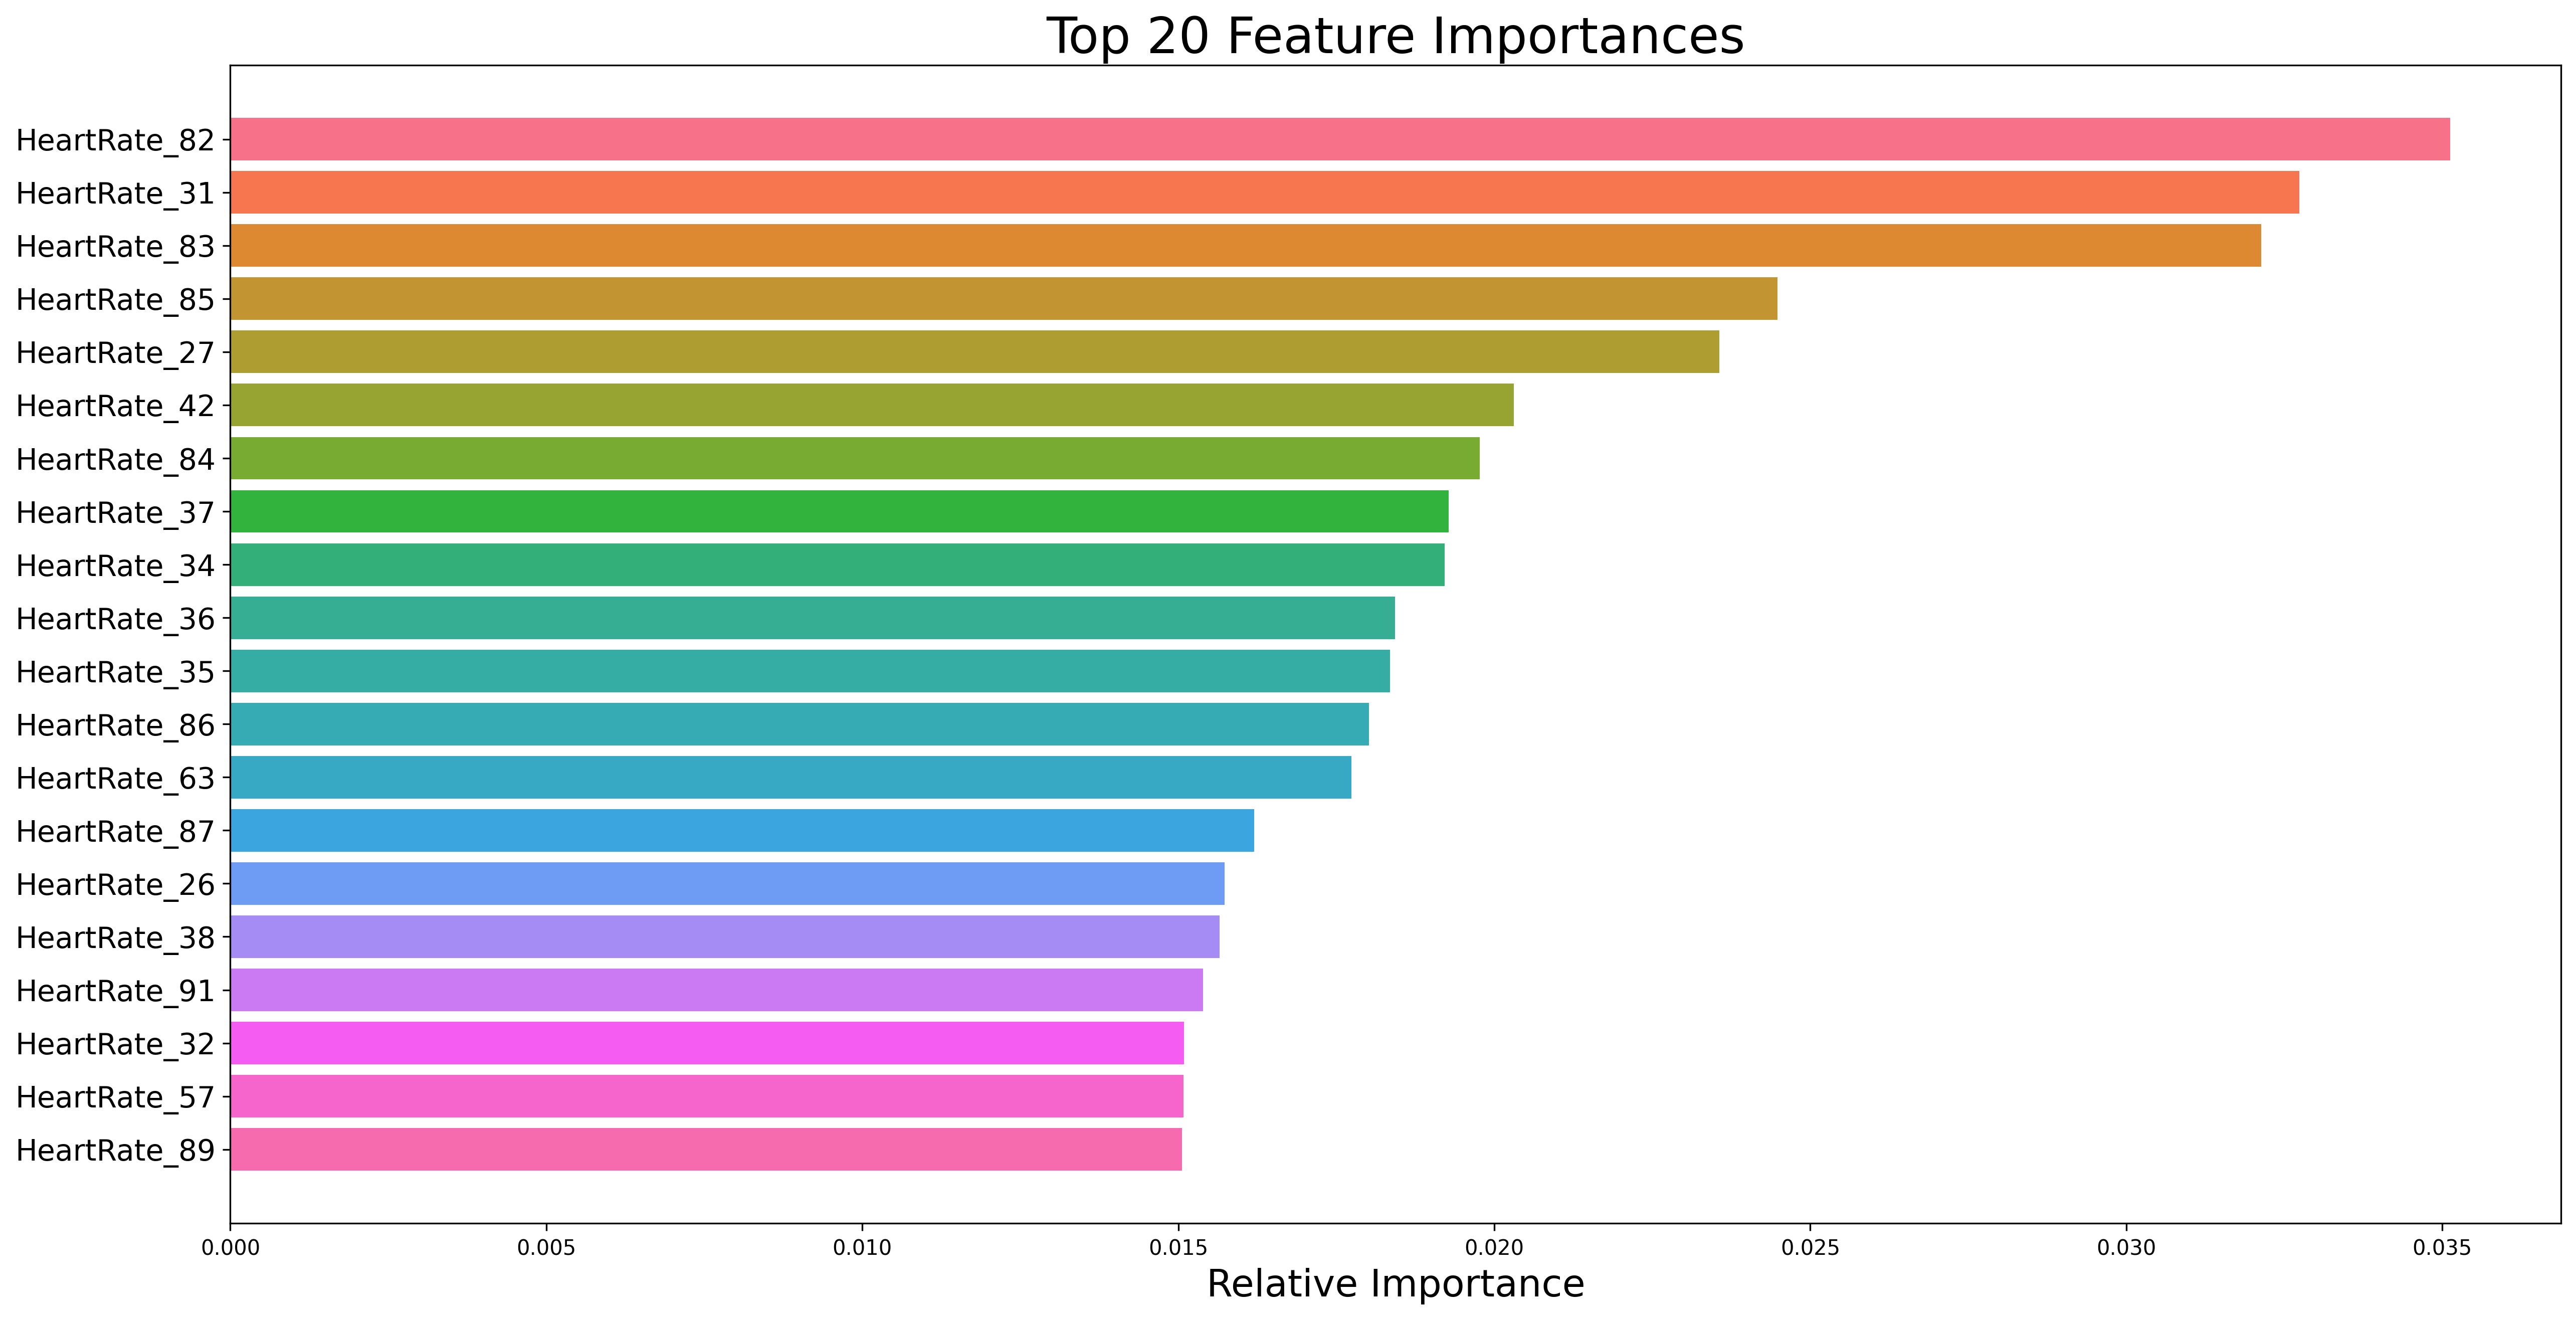

In [329]:
feature_importances = best_rf_clf.feature_importances_

# Get indices of the top 20 features in ascending order
indices = np.argsort(feature_importances)[-20:]
indices = indices[::-1]  # Reverse to get descending order

# Plot
plt.figure(figsize=(20, 10), dpi=300)
plt.title('Top 20 Feature Importances', fontsize=24)
colors = sns.color_palette("husl", len(indices))  # Use a colorful palette

plt.barh(range(len(indices)), feature_importances[indices], color=colors, align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices], fontsize=14)
plt.xlabel('Relative Importance', fontsize=18)
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.savefig('random_forest_top20_feature_importances_subjpatient_newDatasetjustApple.png')
plt.show()

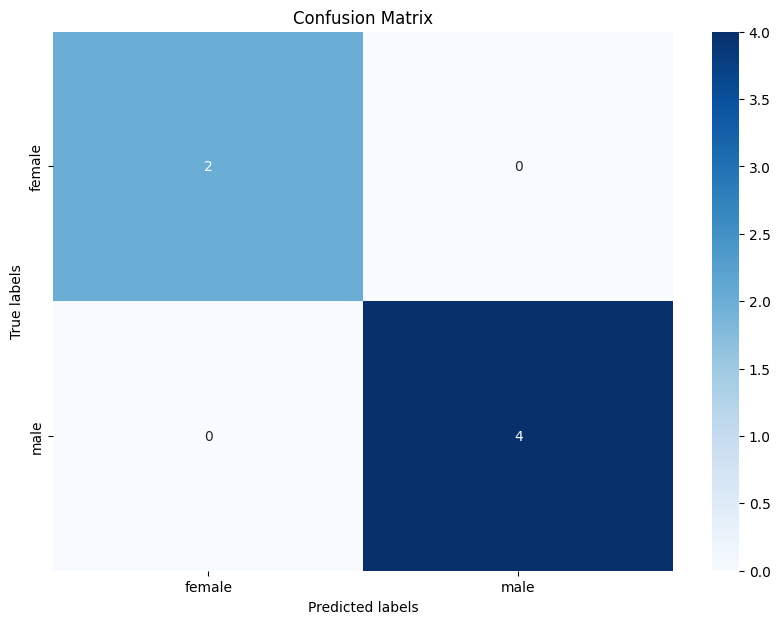

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=rf_clf.classes_, yticklabels=rf_clf.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('random_forest_risk_confusionMatrix.png')
plt.show()

In [52]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Daten laden
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/final_updated_data_modified.csv')
df['Distance (km)'] = df['Distance (km)'].str.replace(',', '.').astype(float)
#df = df.dropna(subset=['gender'])

features = df[['Heart rate 1', 'Heart rate 2', 'Heart rate 3', 'Heart rate 4', 'Heart rate 5', 'Heart rate 6', 'Heart rate 7', 'Heart rate 8', 'Heart rate 9', 'Heart rate 10', 'weight (kg)', 'height (cm)', 'age (years)', 'HR_before', 'HR_after','RR_before_systolic', 'RR_before_diastolic',
       'RR_after_systolic', 'RR_after_diastolic']]

# Skalierung der Features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Anwendung von K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Angenommen, Sie möchten 3 Cluster haben
clusters = kmeans.fit_predict(scaled_features)

# Berechne den Silhouette Score
silhouette_avg = silhouette_score(scaled_features, clusters)
print(f"Silhouette Score for K-Means: {silhouette_avg}")

# Berechne Davies-Bouldin Score
davies_bouldin_avg = davies_bouldin_score(scaled_features, clusters)
print(f"Davies-Bouldin Score for K-Means: {davies_bouldin_avg}")

Silhouette Score for K-Means: 0.2064362166061537
Davies-Bouldin Score for K-Means: 1.3011486682483764


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


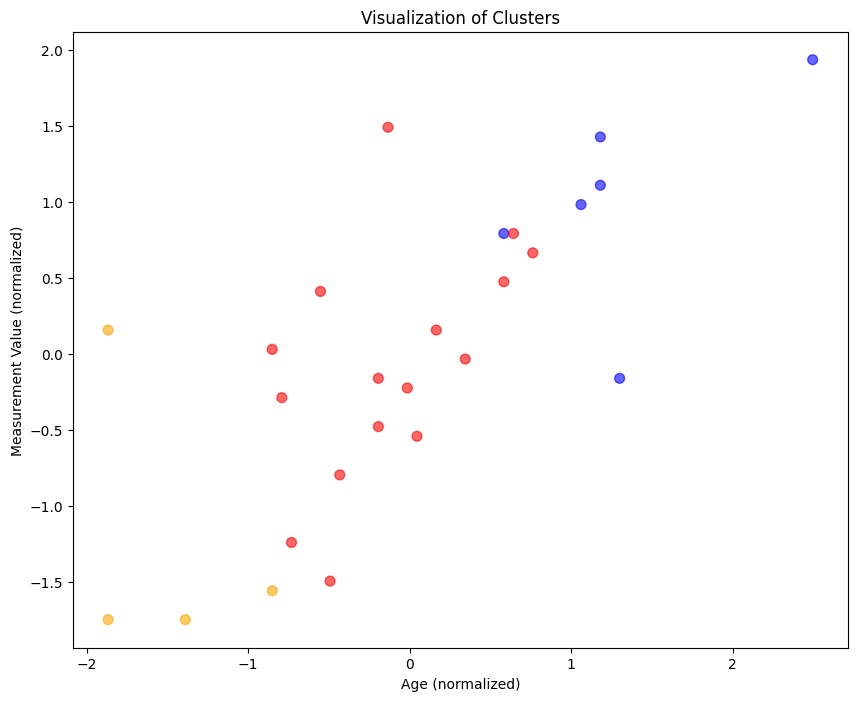

In [50]:
from matplotlib.colors import ListedColormap

# Erstellen einer benutzerdefinierten Farbkarte ohne Gelb
colors = ["blue", "green", "red", "purple", "orange"]
cmap = ListedColormap(colors)

# Setze die Größe der Abbildung
plt.figure(figsize=(10, 8))

# Erstelle ein Scatter-Plot der skalierten Features
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=clusters, cmap=cmap, marker='o', s=50, alpha=0.6)

# Beschrifte die Achsen
plt.xlabel('Age (normalized)')
plt.ylabel('Measurement Value (normalized)')

# Setze den Titel
plt.title('Visualization of Clusters')

# Speichere den Plot als eine Bilddatei
plt.savefig('cluster_visualization_no_yellow.png')

# Zeige den Plot an
plt.show()

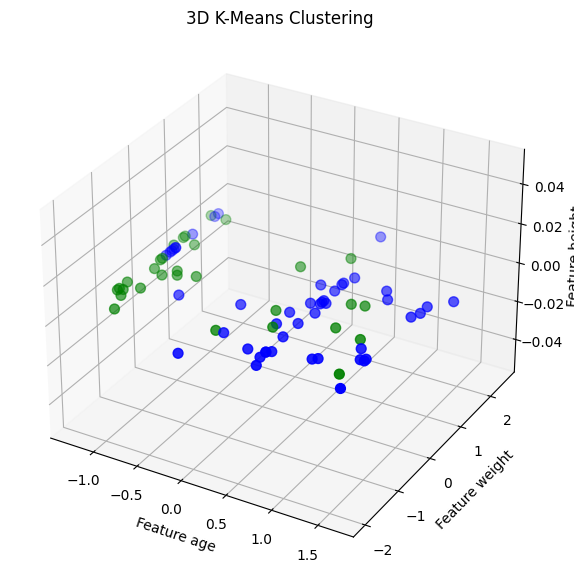

In [114]:
colors = np.array(['blue', 'green'])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(scaled_features[:, 0], scaled_features[:, 1], c=colors[clusters], s=50)
ax.set_xlabel('Feature age')
ax.set_ylabel('Feature weight')
ax.set_zlabel('Feature height')
ax.set_title('3D K-Means Clustering')
plt.savefig('Clustering_age+heartRate.png')

plt.show()

Silhouette Score for Hierarchical Clustering: 0.27143686906033687
Davies-Bouldin Score for Hierarchical Clustering: 1.4248941112042506


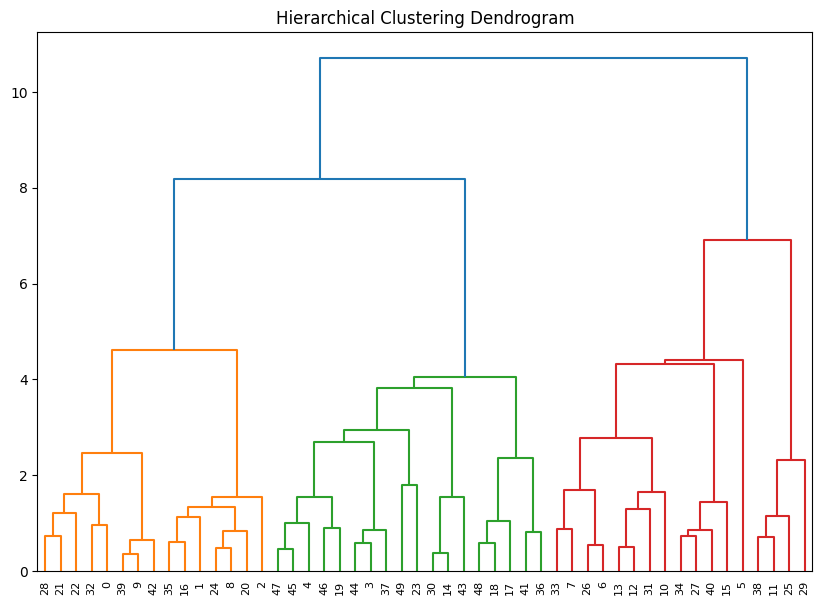

In [316]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster

# Hierarchisches Clustering
linked = linkage(scaled_features, method='ward')

# Hierarchisches Clustering und Erstellen von Labels
max_d = 10 # Beispielwert, anpassen an deinen Dendrogramm
clusters_hier = fcluster(linked, max_d, criterion='distance')

# Berechne Silhouette Score
silhouette_avg_hier = silhouette_score(scaled_features, clusters_hier)
print(f"Silhouette Score for Hierarchical Clustering: {silhouette_avg_hier}")

# Berechne Davies-Bouldin Score
davies_bouldin_avg_hier = davies_bouldin_score(scaled_features, clusters_hier)
print(f"Davies-Bouldin Score for Hierarchical Clustering: {davies_bouldin_avg_hier}")

# Dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.savefig('HierarchicalClustering_age+heartRate.png')
plt.show()


In [53]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_features, clusters, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=scaled_features.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, batch_size=10)

_, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy*100:.2f}%')

2024-07-16 15:02:37.600472: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
2/2 [==============================] - 1s 7ms/step - loss: 0.5618 - accuracy: 0.5500
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 0.5188 - accuracy: 0.6500
Epoch 3/100
2/2 [==============================] - 0s 4ms/step - loss: 0.4773 - accuracy: 0.7500
Epoch 4/100
2/2 [==============================] - 0s 5ms/step - loss: 0.4343 - accuracy: 0.7500
Epoch 5/100
2/2 [==============================] - 0s 4ms/step - loss: 0.3826 - accuracy: 0.8000
Epoch 6/100
2/2 [==============================] - 0s 4ms/step - loss: 0.3530 - accuracy: 0.8000
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 0.3059 - accuracy: 0.8000
Epoch 8/100
2/2 [==============================] - 0s 4ms/step - loss: 0.2779 - accuracy: 0.8000
Epoch 9/100
2/2 [==============================] - 0s 4ms/step - loss: 0.2365 - accuracy: 0.8000
Epoch 10/100
2/2 [==============================] - 0s 4ms/step - loss: 0.2107 - accuracy: 0.8000
Epoch 11/100
2/2 [===========

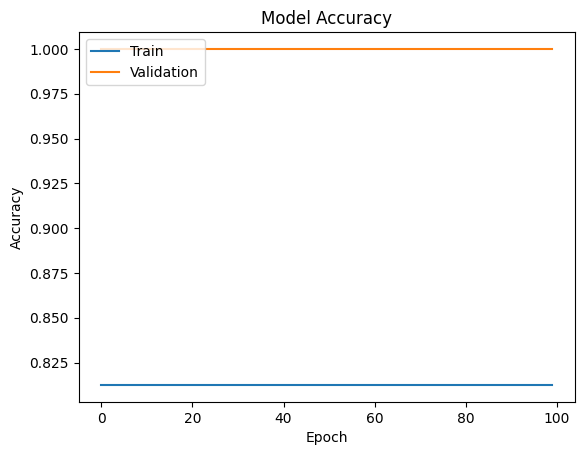

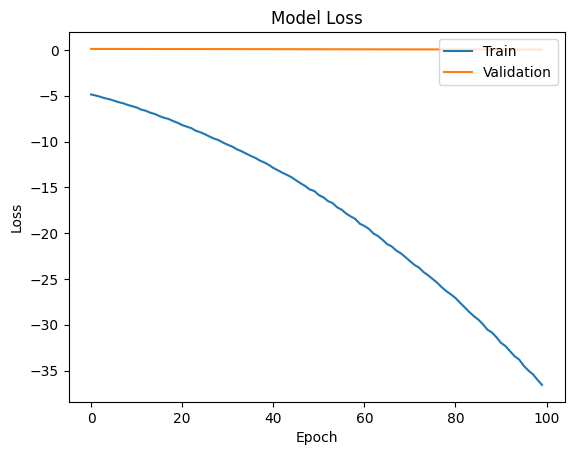

In [54]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=10, verbose=0)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('deepLearningModel_age+heartRate1.png')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('deepLearningModel_age+heartRate2.png')
plt.show()

In [334]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Daten laden
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/cleaneddata_with_bmi_flag.csv')
df = df.dropna()

#df['Distance (km)'] = df['Distance (km)'].str.replace(',', '.').astype(float)
# Konvertiere Distance von km in Meter
df['real_Distance'] = df['real_Distance'] * 1000

scaler = StandardScaler()
df[['MeasurementValue', 'Heart rate 2', 'real_Distance', 'age (years)', 'leg Length (cm)']] = scaler.fit_transform(df[['MeasurementValue', 'Heart rate 2', 'real_Distance', 'age (years)', 'leg Length (cm)']])

# Aufteilen in Trainings- und Testdatensätze
X1 = df[['age (years)', 'real_Distance', 'leg Length (cm)']]
y1 = df['MeasurementValue']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

X2 = df[['age (years)', 'MeasurementValue', 'leg Length (cm)', 'Heart rate 2']]
y2 = df['real_Distance']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

X3 = df[['real_Distance', 'MeasurementValue', 'leg Length (cm)', 'Heart rate 2']]
y3 = df['age (years)']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)


In [335]:
from keras.models import Sequential
from keras.layers import Dense

def build_model(input_dim):
    model = Sequential()
    model.add(Dense(12, input_dim=input_dim, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='linear'))  # Ausgabeschicht für Regression
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Modelle für jede Vorhersagekombination erstellen und trainieren
model1 = build_model(3)  # Alter und Distanz zur Vorhersage der Herzfrequenz
model1.fit(X_train1, y_train1, epochs=50, batch_size=10, verbose=1)

model2 = build_model(4)  # Alter und Herzfrequenz zur Vorhersage der Distanz
model2.fit(X_train2, y_train2, epochs=50, batch_size=10, verbose=1)

model3 = build_model(4)  # Distanz und Herzfrequenz zur Vorhersage des Alters
model3.fit(X_train3, y_train3, epochs=50, batch_size=10, verbose=1)

Epoch 1/50
4/4 [==============================] - 1s 2ms/step - loss: 0.9576
Epoch 2/50
4/4 [==============================] - 0s 2ms/step - loss: 0.9401
Epoch 3/50
4/4 [==============================] - 0s 3ms/step - loss: 0.9264
Epoch 4/50
4/4 [==============================] - 0s 4ms/step - loss: 0.9093
Epoch 5/50
4/4 [==============================] - 0s 3ms/step - loss: 0.8955
Epoch 6/50
4/4 [==============================] - 0s 3ms/step - loss: 0.8862
Epoch 7/50
4/4 [==============================] - 0s 2ms/step - loss: 0.8738
Epoch 8/50
4/4 [==============================] - 0s 2ms/step - loss: 0.8670
Epoch 9/50
4/4 [==============================] - 0s 3ms/step - loss: 0.8569
Epoch 10/50
4/4 [==============================] - 0s 3ms/step - loss: 0.8486
Epoch 11/50
4/4 [==============================] - 0s 2ms/step - loss: 0.8375
Epoch 12/50
4/4 [==============================] - 0s 3ms/step - loss: 0.8306
Epoch 13/50
4/4 [==============================] - 0s 2ms/step - loss: 0.

In [336]:
from sklearn.metrics import mean_squared_error

# Modellevaluierung
y_pred1 = model1.predict(X_test1)
mse1 = mean_squared_error(y_test1, y_pred1)
print("MSE for Model 1 (Heart Rate Prediction):", mse1)

y_pred2 = model2.predict(X_test2)
mse2 = mean_squared_error(y_test2, y_pred2)
print("MSE for Model 2 (Distance Prediction):", mse2)

y_pred3 = model3.predict(X_test3)
mse3 = mean_squared_error(y_test3, y_pred3)
print("MSE for Model 3 (Age Prediction):", mse3)

1/1 [==============================] - 0s 62ms/step
MSE for Model 1 (Heart Rate Prediction): 1.0974172355681442
1/1 [==============================] - 0s 45ms/step
MSE for Model 2 (Distance Prediction): 0.593705163161206
1/1 [==============================] - 0s 49ms/step
MSE for Model 3 (Age Prediction): 0.5957454643769236


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/updated_data_with_gender.csv')
df['Subject/Patient'] = df['Subject/Patient'].str.replace('S', 's').str.replace('P', 'p').str.strip().str.lower()
df['Distance (km)'] = df['Distance (km)'].str.replace(',', '.').astype(float)

df = df.dropna(subset=['Subject/Patient'])

#df['real_Distance'] = df['real_Distance'].str.replace(',', '.').astype(float)
df['Distance (km)'] = df['Distance (km)'] * 1000

scaler = StandardScaler()
df[['Heart rate 1', 'Heart rate 2', 'Heart rate 3', 'Heart rate 4', 'Heart rate 5', 'Heart rate 6', 'Heart rate 7', 'Heart rate 8', 'Heart rate 9', 'Heart rate 10', 'Distance (km)', 'age (years)', 'height (cm)', 'weight (kg)']] = scaler.fit_transform(df[['Heart rate 1', 'Heart rate 2', 'Heart rate 3', 'Heart rate 4', 'Heart rate 5', 'Heart rate 6', 'Heart rate 7', 'Heart rate 8', 'Heart rate 9', 'Heart rate 10', 'Distance (km)', 'age (years)', 'height (cm)', 'weight (kg)']])
features = df[['Heart rate 1', 'Heart rate 2', 'Heart rate 3', 'Heart rate 4', 'Heart rate 5', 'Heart rate 6', 'Heart rate 7', 'Heart rate 8', 'Heart rate 9', 'Heart rate 10', 'Distance (km)', 'age (years)', 'height (cm)', 'weight (kg)']]
# Prepare feature sets
feature_sets = {
    'Set1': ['age (years)', 'Distance (km)', 'height (cm)', 'weight (kg)'],
    'Set2': ['age (years)', 'Heart rate 1', 'Heart rate 2', 'Heart rate 3', 'Heart rate 4', 'Heart rate 5', 'Heart rate 6', 'Heart rate 7', 'Heart rate 8', 'Heart rate 9', 'Heart rate 10', 'height (cm)', 'weight (kg)'],
    'Set3': ['Distance (km)', 'Heart rate 1', 'Heart rate 2', 'Heart rate 3', 'Heart rate 4', 'Heart rate 5', 'Heart rate 6', 'Heart rate 7', 'Heart rate 8', 'Heart rate 9', 'Heart rate 10', 'height (cm)', 'weight (kg)'],
    'Set4': ['Distance (km)', 'Heart rate 1', 'Heart rate 2', 'Heart rate 3', 'Heart rate 4', 'Heart rate 5', 'Heart rate 6', 'Heart rate 7', 'Heart rate 8', 'Heart rate 9', 'Heart rate 10','age (years)', 'height (cm)', 'weight (kg)']
}


Set1 - Accuracy: 0.5
Set1 - Classification Report:
               precision    recall  f1-score   support

      female       0.50      0.50      0.50         4
        male       0.50      0.50      0.50         4

    accuracy                           0.50         8
   macro avg       0.50      0.50      0.50         8
weighted avg       0.50      0.50      0.50         8



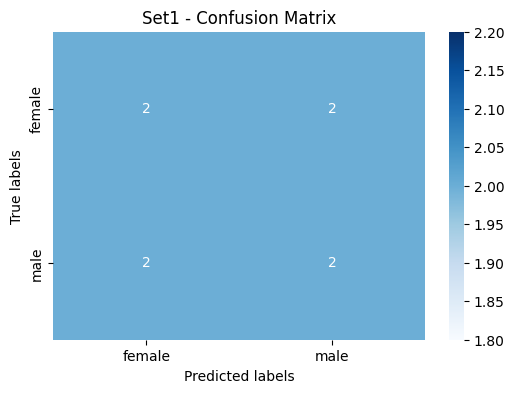


Set2 - Accuracy: 0.75
Set2 - Classification Report:
               precision    recall  f1-score   support

      female       0.75      0.75      0.75         4
        male       0.75      0.75      0.75         4

    accuracy                           0.75         8
   macro avg       0.75      0.75      0.75         8
weighted avg       0.75      0.75      0.75         8



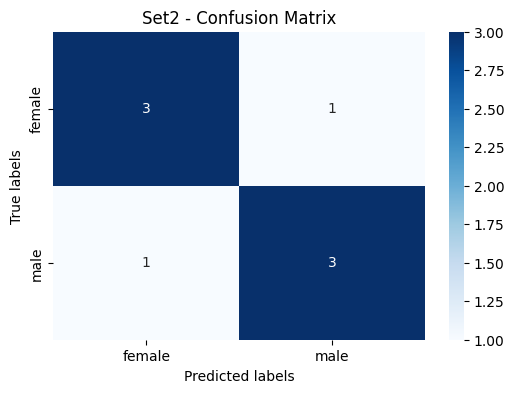


Set3 - Accuracy: 0.625
Set3 - Classification Report:
               precision    recall  f1-score   support

      female       0.60      0.75      0.67         4
        male       0.67      0.50      0.57         4

    accuracy                           0.62         8
   macro avg       0.63      0.62      0.62         8
weighted avg       0.63      0.62      0.62         8



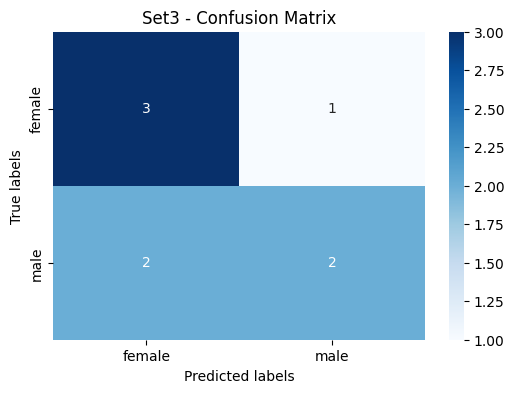


Set4 - Accuracy: 0.625
Set4 - Classification Report:
               precision    recall  f1-score   support

      female       0.67      0.50      0.57         4
        male       0.60      0.75      0.67         4

    accuracy                           0.62         8
   macro avg       0.63      0.62      0.62         8
weighted avg       0.63      0.62      0.62         8



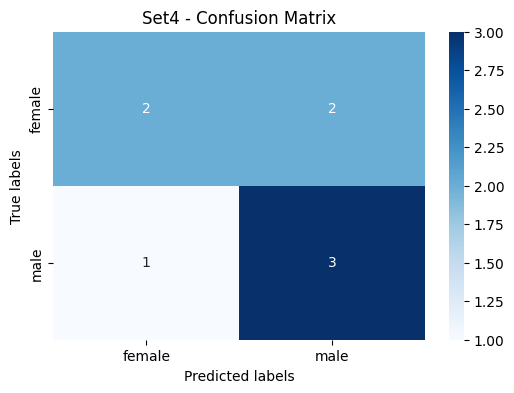

In [17]:
# Train models and evaluate
for set_name, features in feature_sets.items():
    X = df[features]
    y = df['gender']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    svm_clf = SVC(kernel='linear', random_state=42)
    svm_clf.fit(X_train, y_train)
    y_pred = svm_clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{set_name} - Accuracy: {accuracy}")
    print(f"{set_name} - Classification Report:\n {classification_report(y_test, y_pred)}")

    # Plotting the Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=svm_clf.classes_, yticklabels=svm_clf.classes_)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'{set_name} - Confusion Matrix')
    plt.show()

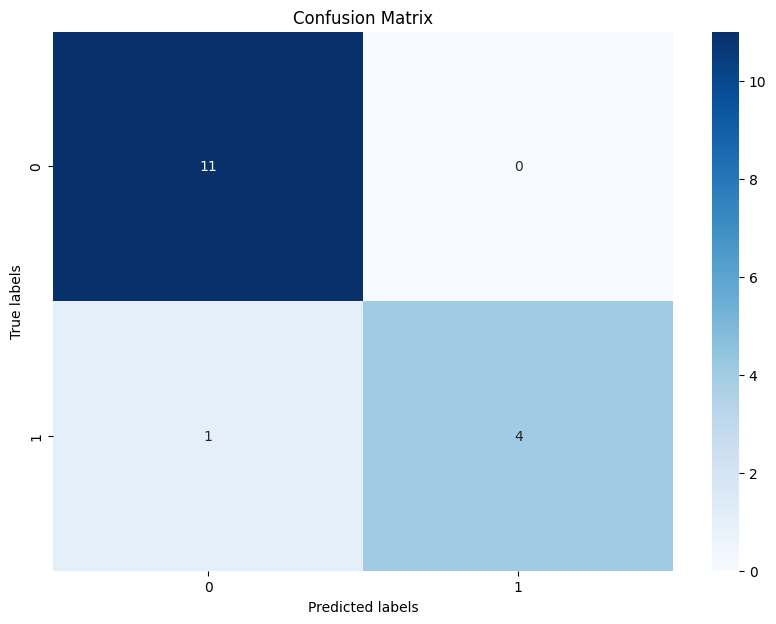

In [329]:
# Plotting the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=svm_clf.classes_, yticklabels=svm_clf.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [158]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/modified_cleaned_data_full_no_measurement_50Values.csv')

df['weight (kg)'] = df['weight (kg)'].str.replace(',', '.').astype(float)
# Spalte 'BMI_CDA' löschen
if 'BMI_CDA' in df.columns:
    df.drop('BMI_CDA', axis=1, inplace=True)

# Neue Spalte 'BMI' berechnen und direkt nach 'weight (kg)' einfügen
if 'weight (kg)' in df.columns and 'height (cm)' in df.columns:
    # BMI berechnen
    df['BMI'] = df['weight (kg)'] / (df['height (cm)'] / 100) ** 2

    # Neue Spalte direkt nach 'weight (kg)' einfügen
    weight_index = df.columns.get_loc('weight (kg)') + 1
    columns = df.columns.tolist()  # Liste der Spaltennamen erstellen
    columns.insert(weight_index, columns.pop(columns.index('BMI')))  # 'BMI' verschieben
    df = df[columns]  # DataFrame neu ordnen mit 'BMI' direkt nach 'weight (kg)'
else:
    print("Die Spalten 'weight (kg)' oder 'height (cm)' existieren nicht im DataFrame.")

# Änderungen speichern (optional)
df.to_csv('updated_datafile.csv', index=False) 

In [180]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/final_updated_data_23.05.csv')

# Finde den Spaltenindex von 'BMI_CDA'
bmi_cda_index = df.columns.get_loc('BMI') + 1

# Füge die neue Spalte 'BMI_Over_25' hinzu, setze Werte nur, wenn 'BMI_CDA' nicht NaN ist
df.insert(bmi_cda_index, 'BMI_Over_25', np.where(df['BMI'].notna(), (df['BMI'] > 25).astype(int), np.nan))

# Speichere die modifizierte Tabelle in einer neuen CSV-Datei
neuer_dateipfad = 'final_updated_data_23.05.csv'
df.to_csv(neuer_dateipfad, index=False)

In [159]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/updated_datafile_23.05.csv')

# Fehlende Werte in 'leg length (cm)' ersetzen
df['leg Length (cm)'] = df['leg Length (cm)'].fillna(df['height (cm)'] * 0.45)

# Neue Spalte 'real_Distance' berechnen
df['real_Distance'] = (df['leg Length (cm)'] * df['Steps']) / 100000  # Ergebnis in km

# 'real_Distance' direkt nach 'Distance (km)' einfügen
distance_index = df.columns.get_loc('Distance (km)') + 1
columns = df.columns.tolist()  # Liste der Spaltennamen erstellen
columns.insert(distance_index, columns.pop(columns.index('real_Distance')))  # 'real_Distance' verschieben
df = df[columns]  # DataFrame neu ordnen mit 'real_Distance' direkt nach 'Distance (km)'

# DataFrame speichern
df.to_csv('cleaneddata_with_bmi_flag_23.05.csv', index=False)

# weiter zu ML
## ggf Optimierung

In [358]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/cleaneddata_with_bmi_flag.csv')

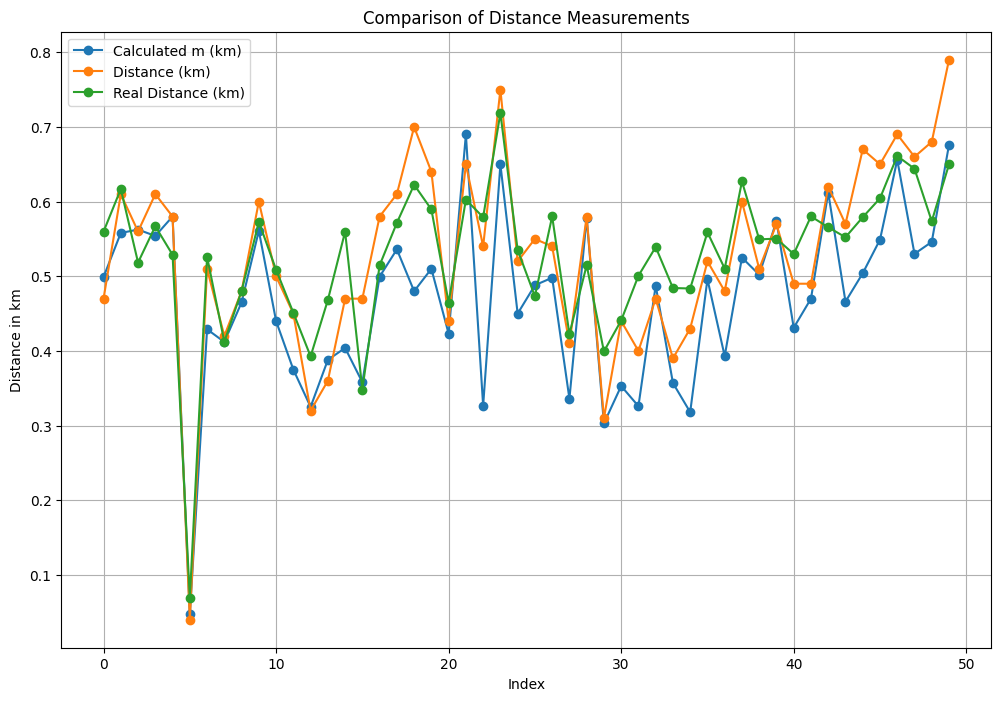

In [341]:

# Überprüfen, ob die benötigten Spalten vorhanden sind
if not set(['Calculated m', 'Distance (km)', 'real_Distance']).issubset(df.columns):
    raise ValueError("Einer oder mehrere der erforderlichen Spaltennamen fehlen im DataFrame.")

df['Calculated m'] = df['Calculated m'].str.replace(',', '.').astype(float)
df['Distance (km)'] = df['Distance (km)'].str.replace(',', '.').astype(float)
#df['real_Distance'] = df['real_Distance'].str.replace(',', '.').astype(float)
# Konvertierung der 'Calculated m' in Kilometer, wenn sie in Metern angegeben ist
df['Calculated m'] = df['Calculated m'] / 1000  # Angenommen, die Werte sind in Metern

# Plot erstellen
plt.figure(figsize=(12, 8))
plt.plot(df['Calculated m'], label='Calculated m (km)', marker='o')
plt.plot(df['Distance (km)'], label='Distance (km)', marker='o')
plt.plot(df['real_Distance'], label='Real Distance (km)', marker='o')

# Achsen und Titel
plt.xlabel('Index')
plt.ylabel('Distance in km')
plt.title('Comparison of Distance Measurements')
plt.legend()

# Gitternetz anzeigen
plt.grid(True)

# Speichern des Plots
plt.savefig('distance_comparison_plot.png')

# Anzeigen des Plots
plt.show()

In [359]:
df['Calculated m'] = df['Calculated m'].str.replace(',', '.').astype(float)
df['Distance (km)'] = df['Distance (km)'].str.replace(',', '.').astype(float)
#df['real_Distance'] = df['real_Distance'].str.replace(',', '.').astype(float)

# Umrechnung von Metern in Kilometer
df['Calculated m'] = df['Calculated m'] / 1000

# Berechnung der prozentualen Differenzen
df['Diff_Calculated_vs_Distance_km'] = ((df['Calculated m'] - df['Distance (km)']) / df['Distance (km)']) * 100
df['Diff_Calculated_vs_Real_Distance'] = ((df['Calculated m'] - df['real_Distance']) / df['real_Distance']) * 100
df['Diff_Distance_km_vs_Real_Distance'] = ((df['Distance (km)'] - df['real_Distance']) / df['real_Distance']) * 100

# Optionale Auswahl einiger Zeilen für die Darstellung
sample_df = df[['Calculated m', 'Distance (km)', 'real_Distance', 
                'Diff_Calculated_vs_Distance_km', 
                'Diff_Calculated_vs_Real_Distance', 
                'Diff_Distance_km_vs_Real_Distance']].head()

# Konvertierung in LaTeX-Format
latex_table = sample_df.to_latex(index=False)

# LaTeX-Tabelle ausgeben
print(latex_table)

\begin{tabular}{rrrrrr}
\toprule
 Calculated m &  Distance (km) &  real\_Distance &  Diff\_Calculated\_vs\_Distance\_km &  Diff\_Calculated\_vs\_Real\_Distance &  Diff\_Distance\_km\_vs\_Real\_Distance \\
\midrule
       0.4990 &           0.47 &        0.55980 &                        6.170213 &                        -10.861022 &                         -16.041443 \\
       0.5580 &           0.61 &        0.61683 &                       -8.524590 &                         -9.537474 &                          -1.107274 \\
       0.5625 &           0.56 &        0.51840 &                        0.446429 &                          8.506944 &                           8.024691 \\
       0.5540 &           0.61 &        0.56700 &                       -9.180328 &                         -2.292769 &                           7.583774 \\
       0.5800 &           0.58 &        0.52875 &                        0.000000 &                          9.692671 &                           9.692671

/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_1780/46539918.py:20: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = sample_df.to_latex(index=False)


In [360]:
df.to_csv('cleaneddata_with_bmi_flag_updated.csv', index=False)

In [361]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/cleaneddata_with_bmi_flag_updated.csv')

# Find the highest differences in the specified columns
max_diff_calculated_vs_distance_km = df['Diff_Calculated_vs_Distance_km'].max()
max_diff_calculated_vs_real_distance = df['Diff_Calculated_vs_Real_Distance'].max()
max_diff_distance_km_vs_real_distance = df['Diff_Distance_km_vs_Real_Distance'].max()

# Print out the highest differences
print("Highest difference between 'Calculated m' and 'Distance (km)':", max_diff_calculated_vs_distance_km)
print("Highest difference between 'Calculated m' and 'real_Distance':", max_diff_calculated_vs_real_distance)
print("Highest difference between 'Distance (km)' and 'real_Distance':", max_diff_distance_km_vs_real_distance)

Highest difference between 'Calculated m' and 'Distance (km)': 17.5
Highest difference between 'Calculated m' and 'real_Distance': 14.507617245842866
Highest difference between 'Distance (km)' and 'real_Distance': 34.94114269308067


In [161]:
import pandas as pd

file_path = '/Users/tanjazast/Desktop/jupyter_folder/cleaneddata_with_bmi_flag_23.05.csv'

df = pd.read_csv(file_path)

print(df['study ID'])

0       2.0
1       3.0
2       1.0
3       4.0
4       5.0
5       7.0
6       8.0
7       9.0
8      10.0
9      11.0
10     12.0
11     13.0
12     14.0
13     15.0
14     16.0
15     20.0
16     21.0
17     22.0
18     23.0
19     24.0
20     25.0
21     26.0
22     29.0
23     30.0
24     31.0
25     32.0
26     33.0
27    599.0
28     36.0
29    660.0
30    699.0
31    708.0
32    596.0
33    808.0
34    688.0
35    855.0
36    795.0
37    707.0
38    765.0
39    558.0
40    733.0
41    787.0
42    621.0
43    697.0
44    547.0
45    620.0
46    613.0
47    630.0
Name: study ID, dtype: float64


In [162]:
study_id_index = df.columns.get_loc("study ID")
df.insert(study_id_index + 1, 'gender', pd.Series())

gender_data = ['male', 'female', 'male', 'male', 'male', 'female', 'female', 'female', 'female', 'male', 'male', 'male', 'female', 'male', 'male', 'female', 'male', 'male', 'male', 'female', 'female', 'male', 'male', 'female', 'male', 'male', 'male', 'female', 'female', 'female', 'male', 'male', 'female', 'female', 'male', 'male', 'male', 'male', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE' ] 
df['gender'] = gender_data

new_file_path = 'updated_data_with_gender.csv'
df.to_csv(new_file_path, index=False)

/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_14510/3728389169.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.insert(study_id_index + 1, 'gender', pd.Series())


In [166]:
import pandas as pd

file_path = '/Users/tanjazast/Desktop/jupyter_folder/updated_data_with_HR_23.05.csv'

df = pd.read_csv(file_path)

study_id_index = df.columns.get_loc("study ID")
df.insert(study_id_index + 1, 'RR_before', pd.Series())
df.insert(study_id_index + 2, 'RR_after', pd.Series())

RR_before_data = ['144/89', '102/66', '159/72', '149/94', '135/96', '144/81', '137/84', '115/67', '128/78', '141/104', '111/73', '114/64', '131/99', '108/77', '112/83', '127/82', '143/90', '168/93', 'NONE', '127/84', '136/72', '104/67', '130/82', '120/80', '118/69', '162/108', '132/90', '131/93', '124/79', '153/94', '130/80', 'NONE', '136/84', '143/94', '139/88', '122/75', '119/71', '117/83', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE' ] 
df['RR_before'] = RR_before_data

RR_after_data = ['157/98', '102/79', '160/63', '162/97', '148/109', '166/78', '126/81', '134/78', '148/89', '153/107', '125/76', '130/73', '129/102', '130/83', '111/70', '135/90', '120/82', '178/96', 'NONE', '143/94', '154/83', '108/80', '176/85', '135/80', '110/75', '169/108', '140/96', '123/100', '156/128', '159/96', '160/80', 'NONE', '160/92', '136/91', '136/89', '127/85', '146/85', '128/88', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE' ] 
df['RR_after'] = RR_after_data

new_file_path = 'updated_data_with_RR.csv'
df.to_csv(new_file_path, index=False)

/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_14510/638370565.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.insert(study_id_index + 1, 'RR_before', pd.Series())
/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_14510/638370565.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.insert(study_id_index + 2, 'RR_after', pd.Series())


In [164]:
file_path = '/Users/tanjazast/Desktop/jupyter_folder/updated_data_with_gender_23.05.csv'

df = pd.read_csv(file_path)

study_id_index = df.columns.get_loc("study ID")
df.insert(study_id_index + 1, 'HR_before', pd.Series())
df.insert(study_id_index + 2, 'HR_after', pd.Series())

HR_before_data = ['89', '54', '88', '75', '64', '70', '85', '80', '72', '57', '60', '64', '87', '78', '93', '60', '66', '60', 'NONE', '67', '75', '79', '85', '71', '55', '71', '76', '74', '58', '55', '70', 'NONE', '59', '87', '76', '61', '71', '51', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE' ] 
df['HR_before'] = HR_before_data

HR_after_data = ['104', '70', '74', '83', '77', '83', '105', '73', '95', '69', '55', '73', '80', '91', '84', '78', '72', '78', 'NONE', '69', '89', '91', '117', '76', '52', '91', '102', '92', '65', '55', '73', 'NONE', '86', '87', '92', '65', '80', '51', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE' ] 
df['HR_after'] = HR_after_data

new_file_path = 'updated_data_with_HR.csv'
df.to_csv(new_file_path, index=False)

/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_14510/2536398397.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.insert(study_id_index + 1, 'HR_before', pd.Series())
/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_14510/2536398397.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.insert(study_id_index + 2, 'HR_after', pd.Series())


In [167]:
def categorize_bp(systolic, diastolic):
    
    if pd.isnull(systolic) or pd.isnull(diastolic):
        return 'Unknown'
    if systolic < 120 and diastolic < 80:
        return 'Normal'
    elif 120 <= systolic < 130 and diastolic < 80:
        return 'Elevated'
    elif 130 <= systolic <= 139 or 80 <= diastolic <= 89:
        return 'Hypertension Stage 1'
    elif 140 <= systolic or 90 <= diastolic:
        return 'Hypertension Stage 2'
    elif systolic >= 180 or diastolic >= 120:
        return 'Hypertensive Crise'
    else:
        return 'Unknown'

def split_bp(bp):
    if bp == 'NONE' or pd.isnull(bp):
        return None, None
    return map(int, bp.split('/'))

file_path = '/Users/tanjazast/Desktop/jupyter_folder/updated_data_with_RR_23.05.csv'
df = pd.read_csv(file_path)

for col in ['RR_before', 'RR_after']:
    df[f'{col}_systolic'], df[f'{col}_diastolic'] = zip(*df[col].apply(split_bp))

# Kategorisiere Blutdruckwerte
for col in ['RR_before', 'RR_after']:
    df[f'{col}_category'] = df.apply(lambda row: categorize_bp(row[f'{col}_systolic'], row[f'{col}_diastolic']), axis=1)

# Speichere den DataFrame als neue CSV-Datei
new_file_path = 'updated_data_with_BP_categories_40Values.csv'
df.to_csv(new_file_path, index=False)


In [168]:
def categorize_bp(systolic, diastolic):
    if pd.isnull(systolic) or pd.isnull(diastolic):
        return 'Unknown'
    if systolic < 120 and diastolic < 80:
        return 'Normal'
    elif 120 <= systolic < 130 and diastolic < 80:
        return 'Elevated'
    elif 130 <= systolic <= 139 or 80 <= diastolic <= 89:
        return 'Hypertension Stage 1'
    elif 140 <= systolic or 90 <= diastolic:
        return 'Hypertension Stage 2'
    elif systolic >= 180 or diastolic >= 120:
        return 'Hypertensive Crisis'
    else:
        return 'Unknown'

# Funktion zum Aufteilen von Blutdruckwerten
def split_bp(bp):
    if bp == 'NONE' or pd.isnull(bp):
        return None, None
    return map(int, bp.split('/'))

# Lade die Daten
file_path = '/Users/tanjazast/Desktop/jupyter_folder/updated_data_with_BP_categories_50Values.csv'
df = pd.read_csv(file_path)

# Spalte die Blutdruckwerte auf
for col in ['RR_before', 'RR_after']:
    df[f'{col}_systolic'], df[f'{col}_diastolic'] = zip(*df[col].apply(split_bp))

# Kategorisiere Blutdruckwerte
for col in ['RR_before', 'RR_after']:
    df[f'{col}_category'] = df.apply(lambda row: categorize_bp(row[f'{col}_systolic'], row[f'{col}_diastolic']), axis=1)

# Mappe die Kategorien auf numerische Werte
bp_category_mapping = {
    'Unknown': 0,
    'Normal': 1,
    'Elevated': 2,
    'Hypertension Stage 1': 3,
    'Hypertension Stage 2': 4,
    'Hypertensive Crisis': 5
}

# Erzeuge numerische Kategorien
for col in ['RR_before', 'RR_after']:
    df[f'{col}_category_num'] = df[f'{col}_category'].map(bp_category_mapping)

# Speichere den aktualisierten DataFrame
new_file_path = '/Users/tanjazast/Desktop/jupyter_folder/csv/updated_data_with_numerical_BP_categories.csv'
df.to_csv(new_file_path, index=False)

In [169]:
file_path = '/Users/tanjazast/Desktop/jupyter_folder/updated_data_with_numerical_BP_categories_23.05.csv'

# Daten laden
df = pd.read_csv(file_path)

# Stelle sicher, dass die Spalte "Subject/Patient" vorhanden ist
if "Subject/Patient" in df.columns:
    # Index der Spalte "Subject_Patient_Number" ermitteln
    index_of_number = df.columns.get_loc("Subject_Patient_Number")
    
    # Kopiere die Spalte "Subject/Patient" und füge sie nach "Subject_Patient_Number" ein
    df.insert(index_of_number + 1, 'Subject/Patient_copy', df['Subject/Patient'])

    # Speichere den geänderten DataFrame
    df.to_csv('final_updated_data_modified.csv', index=False)

KeyError: 'Subject_Patient_Number'

Plots

In [51]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/updated_data_with_numerical_BP_categories.csv')

print(df.columns)

Index(['Unnamed: 0', 'PatientID', 'Gender', 'BirthDate', 'ObservationID',
       'ObservationType', 'Code', 'DisplayName', 'Heart rate 40',
       'Heart rate 39', 'Heart rate 38', 'Heart rate 37', 'Heart rate 36',
       'Heart rate 35', 'Heart rate 34', 'Heart rate 33', 'Heart rate 32',
       'Heart rate 31', 'Heart rate 30', 'Heart rate 29', 'Heart rate 28',
       'Heart rate 27', 'Heart rate 26', 'Heart rate 25', 'Heart rate 24',
       'Heart rate 23', 'Heart rate 22', 'Heart rate 21', 'Heart rate 20',
       'Heart rate 19', 'Heart rate 18', 'Heart rate 17', 'Heart rate 16',
       'Heart rate 15', 'Heart rate 14', 'Heart rate 13', 'Heart rate 12',
       'Heart rate 11', 'Heart rate 10', 'Heart rate 9', 'Heart rate 8',
       'Heart rate 7', 'Heart rate 6', 'Heart rate 5', 'Heart rate 4',
       'Heart rate 3', 'Heart rate 2', 'Heart rate 1', 'Unit', 'EffectiveTime',
       'BMI', 'type', 'sourceName', 'value', 'unit', 'startDate', 'endDate',
       'study ID', 'HR_before', 'H

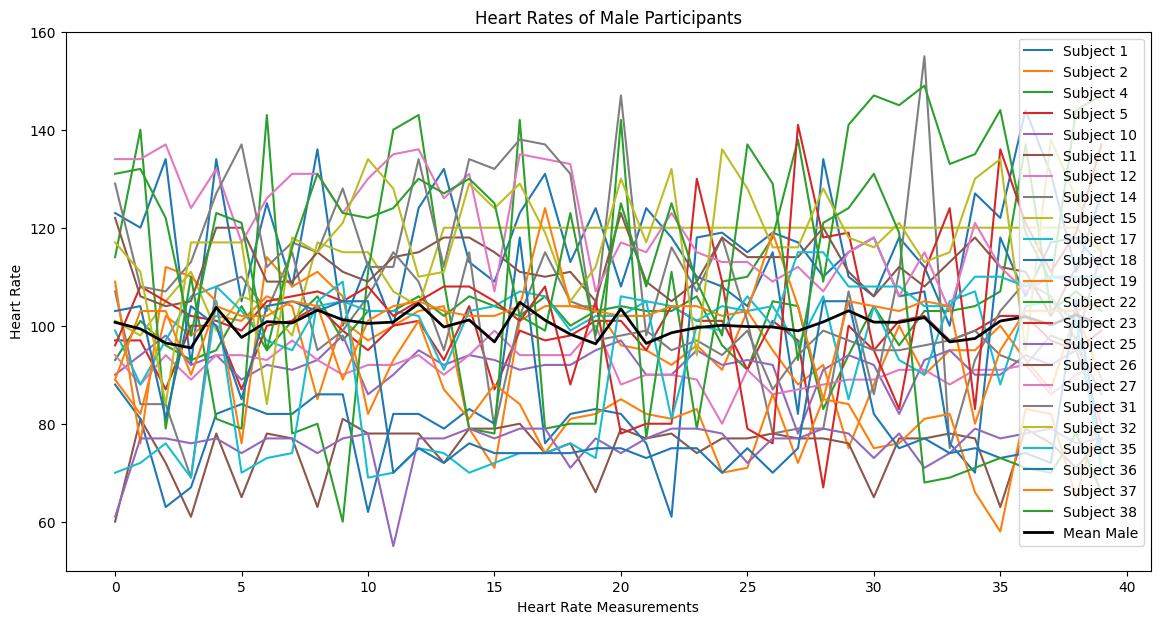

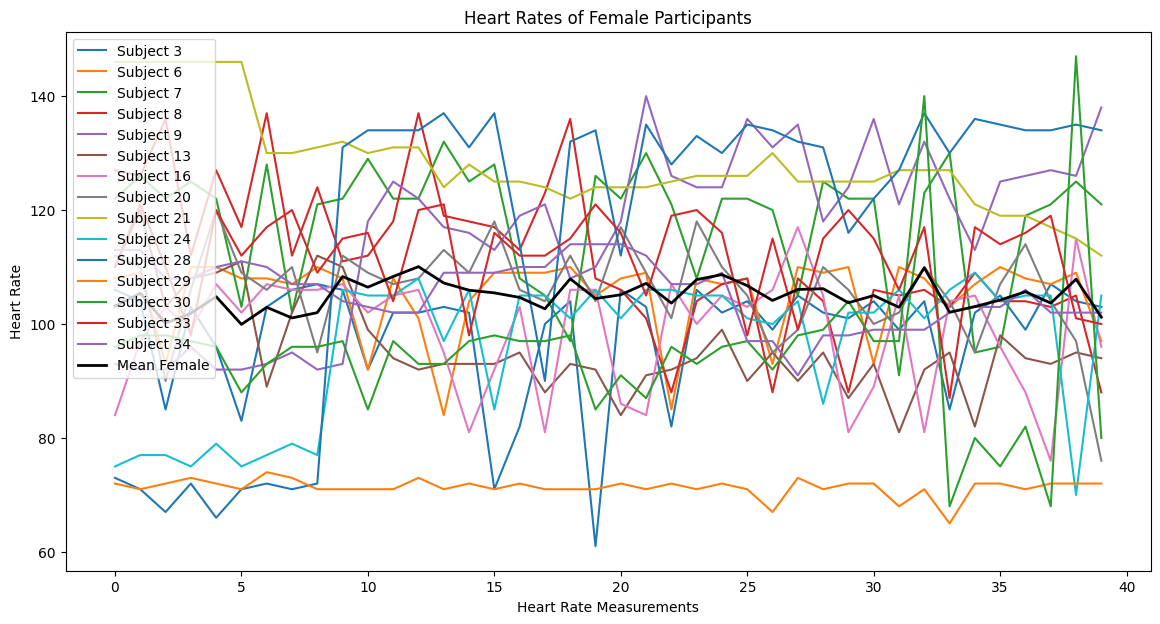

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/updated_data_with_RR_40Values.csv')

df.columns = df.columns.str.strip()

# Daten für Männer und Frauen filtern
df_male = df[df['gender'] == 'male']
df_female = df[df['gender'] == 'female']

# Plot für Männer erstellen
plt.figure(figsize=(14, 7))
for i, row in df_male.iterrows():
    heart_rates = row[['Heart rate 40',
       'Heart rate 39', 'Heart rate 38', 'Heart rate 37', 'Heart rate 36',
       'Heart rate 35', 'Heart rate 34', 'Heart rate 33', 'Heart rate 32',
       'Heart rate 31', 'Heart rate 30', 'Heart rate 29', 'Heart rate 28',
       'Heart rate 27', 'Heart rate 26', 'Heart rate 25', 'Heart rate 24',
       'Heart rate 23', 'Heart rate 22', 'Heart rate 21', 'Heart rate 20',
       'Heart rate 19', 'Heart rate 18', 'Heart rate 17', 'Heart rate 16',
       'Heart rate 15', 'Heart rate 14', 'Heart rate 13', 'Heart rate 12',
       'Heart rate 11', 'Heart rate 10', 'Heart rate 9', 'Heart rate 8',
       'Heart rate 7', 'Heart rate 6', 'Heart rate 5', 'Heart rate 4',
       'Heart rate 3', 'Heart rate 2', 'Heart rate 1']]  
    plt.plot(range(len(heart_rates)), heart_rates, label=f'Subject {i+1}')
mean_male = df_male[['Heart rate 40',
       'Heart rate 39', 'Heart rate 38', 'Heart rate 37', 'Heart rate 36',
       'Heart rate 35', 'Heart rate 34', 'Heart rate 33', 'Heart rate 32',
       'Heart rate 31', 'Heart rate 30', 'Heart rate 29', 'Heart rate 28',
       'Heart rate 27', 'Heart rate 26', 'Heart rate 25', 'Heart rate 24',
       'Heart rate 23', 'Heart rate 22', 'Heart rate 21', 'Heart rate 20',
       'Heart rate 19', 'Heart rate 18', 'Heart rate 17', 'Heart rate 16',
       'Heart rate 15', 'Heart rate 14', 'Heart rate 13', 'Heart rate 12',
       'Heart rate 11', 'Heart rate 10', 'Heart rate 9', 'Heart rate 8',
       'Heart rate 7', 'Heart rate 6', 'Heart rate 5', 'Heart rate 4',
       'Heart rate 3', 'Heart rate 2', 'Heart rate 1']].mean()
plt.plot(range(len(mean_male)), mean_male, label='Mean Male', color='black', linewidth=2)
plt.title('Heart Rates of Male Participants')
plt.xlabel('Heart Rate Measurements')
plt.ylabel('Heart Rate')
plt.legend()
plt.savefig('comparison_plot_male.png')
plt.show()

# Plot für Frauen erstellen
plt.figure(figsize=(14, 7))
for i, row in df_female.iterrows():
    heart_rates = row[['Heart rate 40','Heart rate 39', 'Heart rate 38', 
        'Heart rate 37', 'Heart rate 36',
       'Heart rate 35', 'Heart rate 34', 'Heart rate 33', 'Heart rate 32',
       'Heart rate 31', 'Heart rate 30', 'Heart rate 29', 'Heart rate 28',
       'Heart rate 27', 'Heart rate 26', 'Heart rate 25', 'Heart rate 24',
       'Heart rate 23', 'Heart rate 22', 'Heart rate 21', 'Heart rate 20',
       'Heart rate 19', 'Heart rate 18', 'Heart rate 17', 'Heart rate 16',
       'Heart rate 15', 'Heart rate 14', 'Heart rate 13', 'Heart rate 12',
       'Heart rate 11', 'Heart rate 10', 'Heart rate 9', 'Heart rate 8',
       'Heart rate 7', 'Heart rate 6', 'Heart rate 5', 'Heart rate 4',
       'Heart rate 3', 'Heart rate 2', 'Heart rate 1']] 
    plt.plot(range(len(heart_rates)), heart_rates, label=f'Subject {i+1}')
mean_female = df_female[['Heart rate 40',
       'Heart rate 39', 'Heart rate 38', 'Heart rate 37', 'Heart rate 36',
       'Heart rate 35', 'Heart rate 34', 'Heart rate 33', 'Heart rate 32',
       'Heart rate 31', 'Heart rate 30', 'Heart rate 29', 'Heart rate 28',
       'Heart rate 27', 'Heart rate 26', 'Heart rate 25', 'Heart rate 24',
       'Heart rate 23', 'Heart rate 22', 'Heart rate 21', 'Heart rate 20',
       'Heart rate 19', 'Heart rate 18', 'Heart rate 17', 'Heart rate 16',
       'Heart rate 15', 'Heart rate 14', 'Heart rate 13', 'Heart rate 12',
       'Heart rate 11', 'Heart rate 10', 'Heart rate 9', 'Heart rate 8',
       'Heart rate 7', 'Heart rate 6', 'Heart rate 5', 'Heart rate 4',
       'Heart rate 3', 'Heart rate 2', 'Heart rate 1']].mean()
plt.plot(range(len(mean_female)), mean_female, label='Mean Female', color='black', linewidth=2)
plt.title('Heart Rates of Female Participants')
plt.xlabel('Heart Rate Measurements')
plt.ylabel('Heart Rate')
plt.legend()
plt.savefig('comparison_plot_female.png')
plt.show()

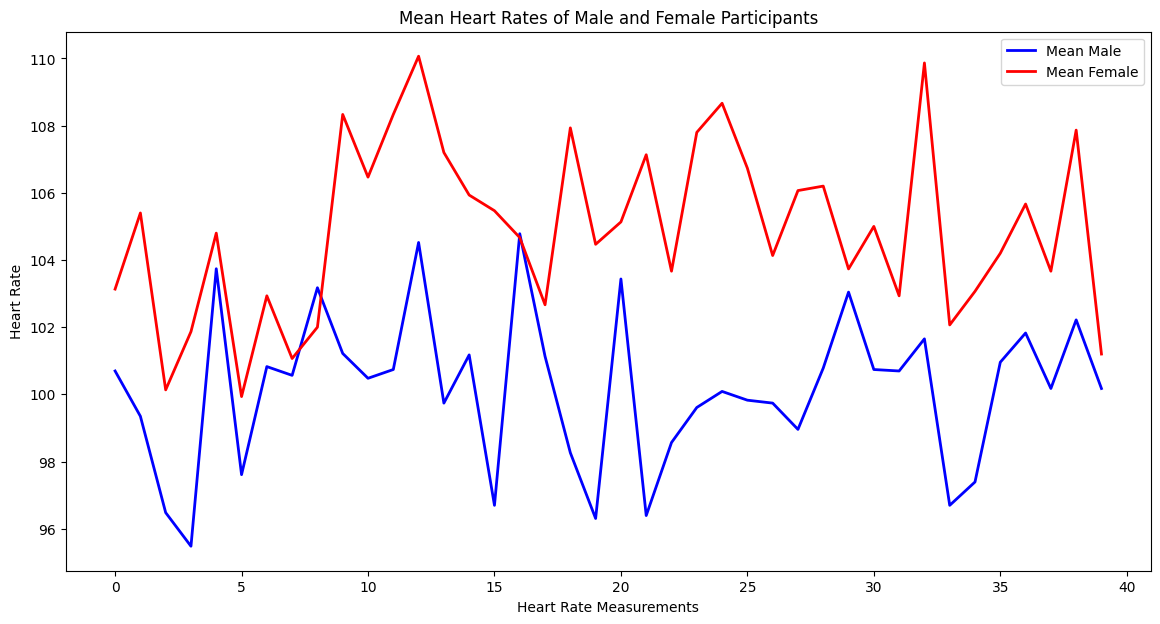

In [7]:
plt.figure(figsize=(14, 7))

# Mittelwert für Männer plotten
plt.plot(range(len(mean_male)), mean_male, label='Mean Male', color='blue', linewidth=2)

# Mittelwert für Frauen plotten
plt.plot(range(len(mean_female)), mean_female, label='Mean Female', color='red', linewidth=2)

# Titel und Beschriftungen
plt.title('Mean Heart Rates of Male and Female Participants')
plt.xlabel('Heart Rate Measurements')
plt.ylabel('Heart Rate')
plt.legend()
plt.savefig('comparison_plot_mean_maleVSfemale.png')
plt.show()

In [87]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/final_data_07.06.csv')

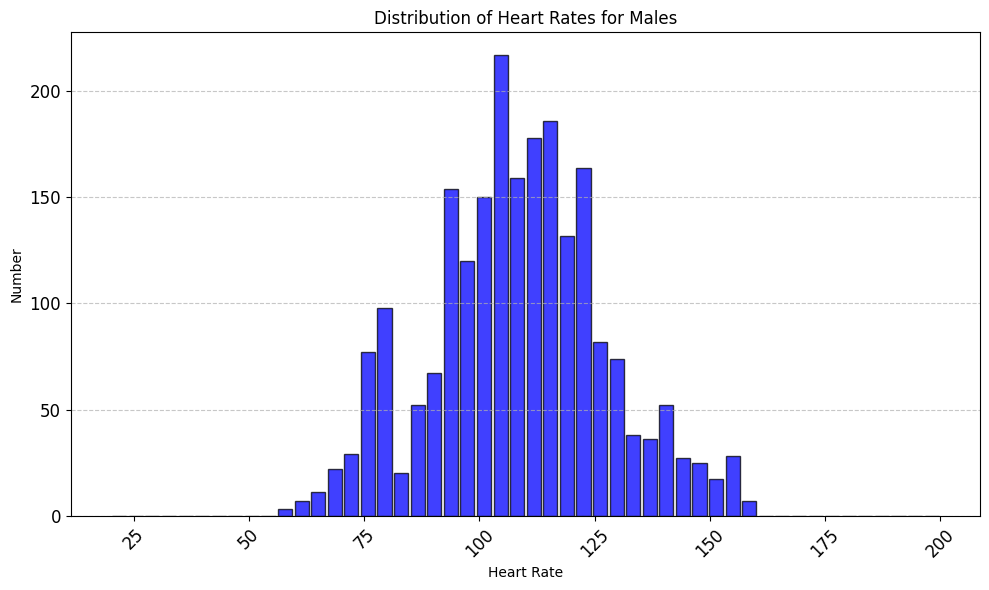

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

male_data = df[df['gender'] == 'male']

# Alle Spalten, die mit "HeartRate" anfangen, auswählen
heart_rate_columns = [col for col in df.columns if col.startswith('HeartRate')]

# Daten der ausgewählten Spalten für männliche Probanden
male_heart_rate_data = male_data[heart_rate_columns]

# Daten in eine flache Struktur umwandeln und NaN-Werte entfernen
flattened_data = male_heart_rate_data.values.flatten()
flattened_data = flattened_data[~pd.isnull(flattened_data)]

# Histogramm der Herzfrequenzwerte plotten
plt.figure(figsize=(10, 6))
plt.hist(flattened_data, bins=50, range=(20, 200), alpha=0.75, color='blue', edgecolor='black', rwidth=0.85)
plt.title('Distribution of Heart Rates for Males')
plt.xlabel('Heart Rate')
plt.ylabel('Number')
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Dist_HeartRate_Males.png')
plt.show()

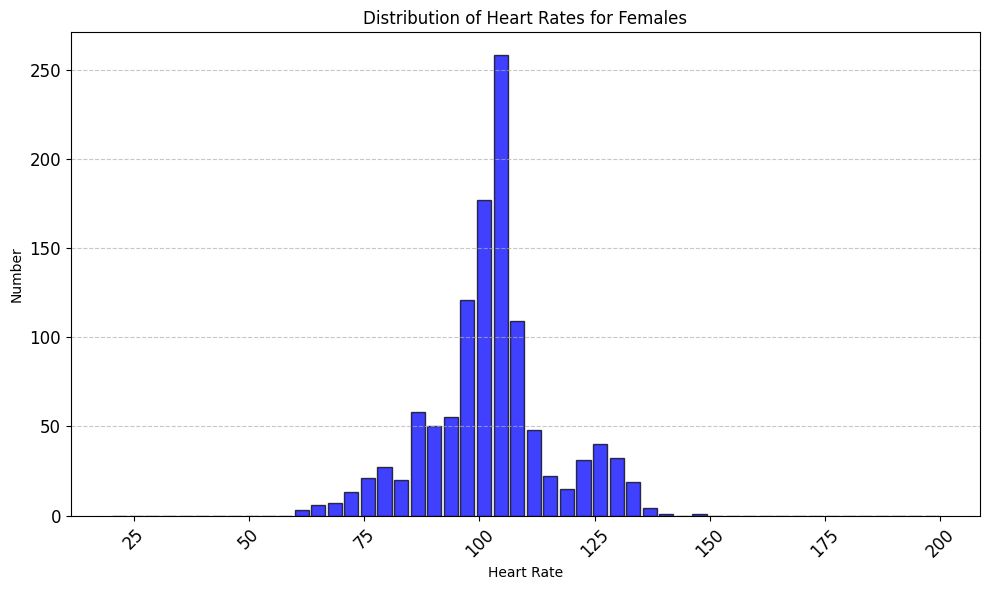

In [88]:
female_data = df[df['gender'] == 'female']

heart_rate_columns = [col for col in df.columns if col.startswith('HeartRate')]

# Daten der ausgewählten Spalten für männliche Probanden
female_heart_rate_data = female_data[heart_rate_columns]

# Daten in eine flache Struktur umwandeln und NaN-Werte entfernen
flattened_data = female_heart_rate_data.values.flatten()
flattened_data = flattened_data[~pd.isnull(flattened_data)]


# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(flattened_data, bins=50, range=(20, 200), alpha=0.75, color='blue', edgecolor='black', rwidth=0.85)
plt.title('Distribution of Heart Rates for Females')
plt.xlabel('Heart Rate')
plt.ylabel('Number')
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Dist_HeartRate_Females.png')
plt.show()

Cross Entropy between male and female heart rates: 0.9821


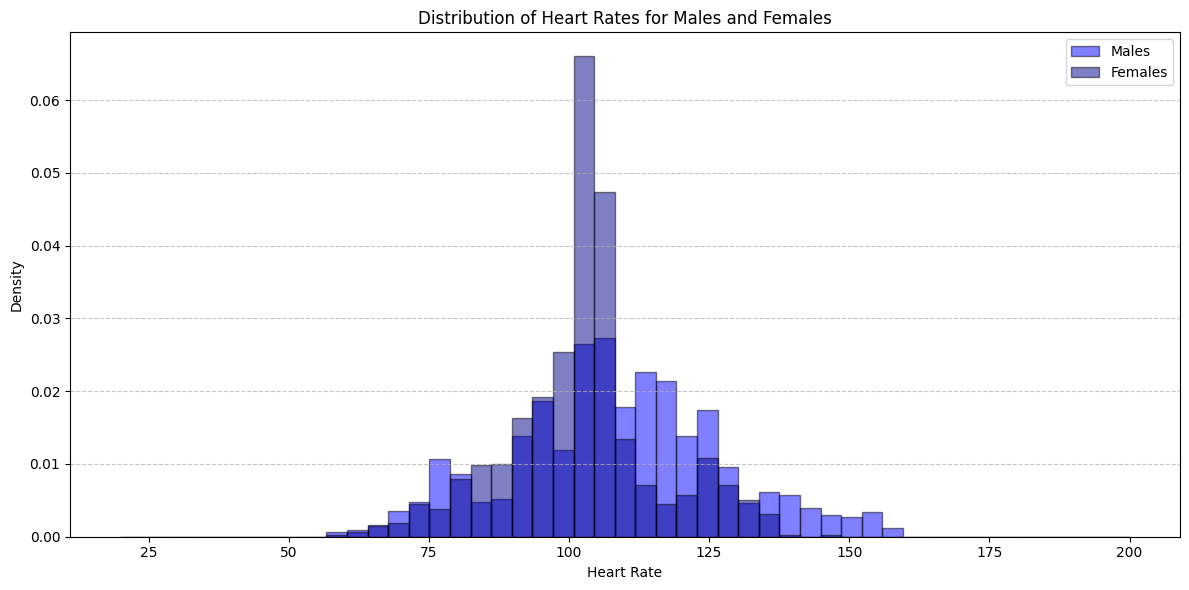

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy

# Load the CSV file
file_path = '/Users/tanjazast/Desktop/jupyter_folder/csv/final_data_07.06.csv'
df = pd.read_csv(file_path)

heart_rate_columns = [col for col in df.columns if col.startswith('HeartRate')]

# Process male data
male_data = df[df['gender'] == 'male']  # Assuming 'male' was converted to 0
male_heart_rate_data = male_data[heart_rate_columns]
flattened_male_data = male_heart_rate_data.values.flatten()
flattened_male_data = flattened_male_data[~pd.isnull(flattened_male_data) & (flattened_male_data != 0)]

# Process female data
female_data = df[df['gender'] == 'female']  # Assuming 'female' was converted to 1
female_heart_rate_data = female_data[heart_rate_columns]
flattened_female_data = female_heart_rate_data.values.flatten()
flattened_female_data = flattened_female_data[~pd.isnull(flattened_female_data) & (flattened_female_data != 0)]

# Compute histograms
bins = np.linspace(20, 200, 50)
male_hist, _ = np.histogram(flattened_male_data, bins=bins, density=True)
female_hist, _ = np.histogram(flattened_female_data, bins=bins, density=True)

# Add small values to histograms to avoid division by zero
male_hist += 1e-10
female_hist += 1e-10



# Compute cross entropy
cross_entropy = entropy(male_hist, female_hist)
print(f"Cross Entropy between male and female heart rates: {cross_entropy:.4f}")

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(flattened_male_data, bins=bins, alpha=0.5, color='blue', label='Males', edgecolor='black', density = True)
plt.hist(flattened_female_data, bins=bins, alpha=0.5, color='darkblue', label='Females', edgecolor='black', density = True)
plt.title('Distribution of Heart Rates for Males and Females')
plt.xlabel('Heart Rate')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Dist_HeartRate_Males_Females.png')
plt.show()

In [11]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/final_data_07.06.csv')

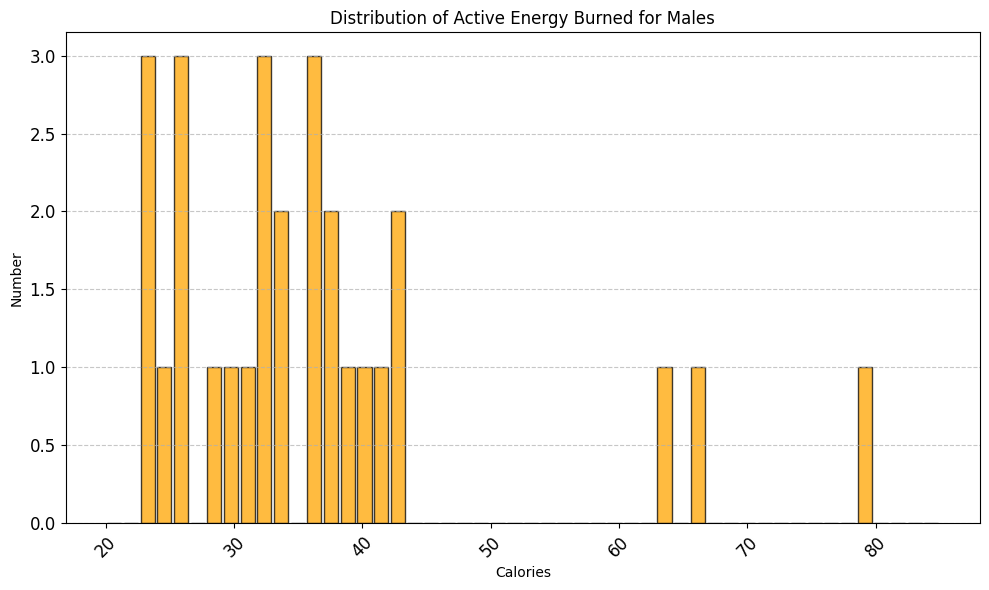

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

male_data = df[df['gender'] == 'male']

# Alle Spalten, die mit "HeartRate" anfangen, auswählen
activeEnergy_columns = [col for col in df.columns if col.startswith('Sum_ActiveEnergy')]

# Daten der ausgewählten Spalten für männliche Probanden
male_active_energy_data = male_data[activeEnergy_columns]

# Daten in eine flache Struktur umwandeln und NaN-Werte entfernen
flattened_data = male_active_energy_data.values.flatten()
flattened_data = flattened_data[~pd.isnull(flattened_data)]

# Histogramm der Herzfrequenzwerte plotten
plt.figure(figsize=(10, 6))
plt.hist(flattened_data, bins=50, range=(20, 85), alpha=0.75, color='orange', edgecolor='black', rwidth=0.85)
plt.title('Distribution of Active Energy Burned for Males')
plt.xlabel('Calories')
plt.ylabel('Number')
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Dist_ActiveEnergy_Males.png')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


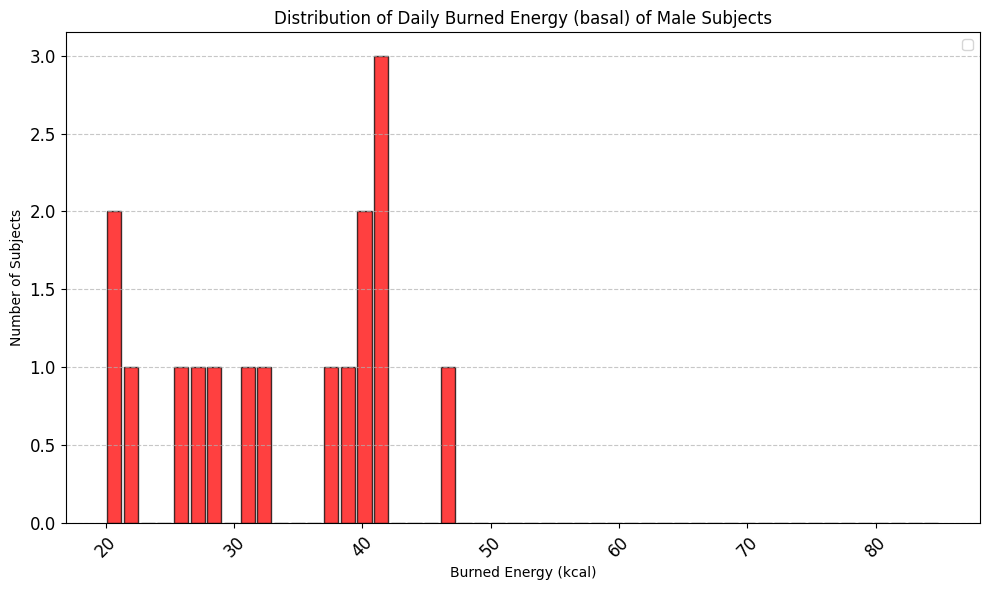

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

male_data = df[df['gender'] == 'male']

# Alle Spalten, die mit "HeartRate" anfangen, auswählen
activeEnergy_columns = [col for col in df.columns if col.startswith('Sum_Basa')]

# Daten der ausgewählten Spalten für männliche Probanden
male_active_energy_data = male_data[activeEnergy_columns]

# Daten in eine flache Struktur umwandeln und NaN-Werte entfernen
flattened_data = male_active_energy_data.values.flatten()
flattened_data = flattened_data[~pd.isnull(flattened_data)]

# Histogramm der Herzfrequenzwerte plotten
plt.figure(figsize=(10, 6))
plt.hist(flattened_data, bins=50, range=(20, 85), alpha=0.75, color='red', edgecolor='black', rwidth=0.85)

plt.title('Distribution of Daily Burned Energy (basal) of Male Subjects')
plt.xlabel('Burned Energy (kcal)')
plt.ylabel('Number of Subjects')
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('Dist_BasalEnergyBurned_Male.png')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


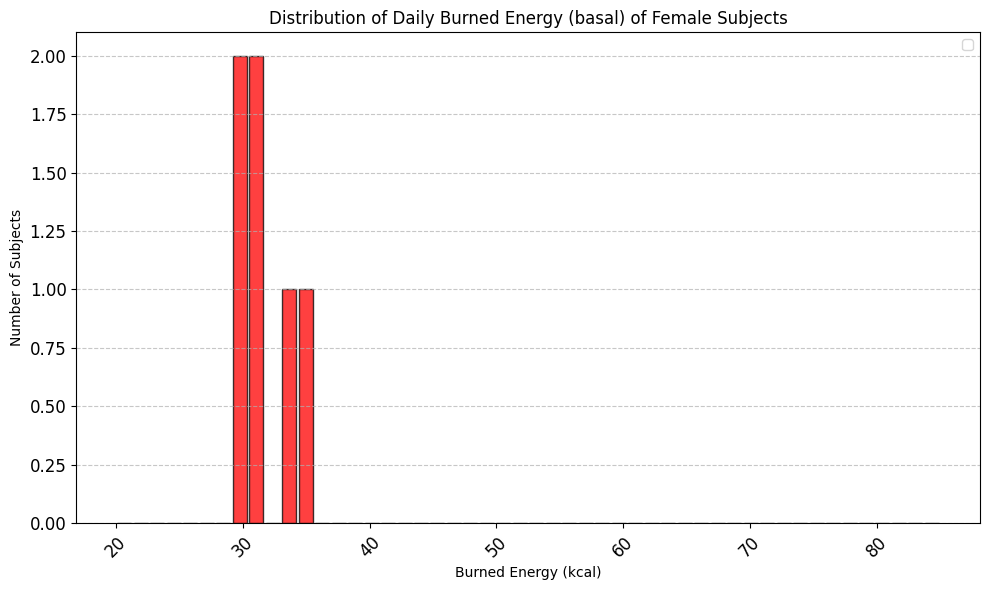

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

male_data = df[df['gender'] == 'female']

# Alle Spalten, die mit "HeartRate" anfangen, auswählen
activeEnergy_columns = [col for col in df.columns if col.startswith('Sum_Bas')]

# Daten der ausgewählten Spalten für männliche Probanden
female_active_energy_data = female_data[activeEnergy_columns]

# Daten in eine flache Struktur umwandeln und NaN-Werte entfernen
flattened_data = female_active_energy_data.values.flatten()
flattened_data = flattened_data[~pd.isnull(flattened_data)]

# Histogramm der Herzfrequenzwerte plotten
plt.figure(figsize=(10, 6))
plt.hist(flattened_data, bins=50, range=(20, 85), alpha=0.75, color='red', edgecolor='black', rwidth=0.85)

plt.title('Distribution of Daily Burned Energy (basal) of Female Subjects')
plt.xlabel('Burned Energy (kcal)')
plt.ylabel('Number of Subjects')
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('Dist_BasalEnergyBurned_Female.png')
plt.show()

19.493854966644637
Cross Entropy between male and female heart rates: 19.4939


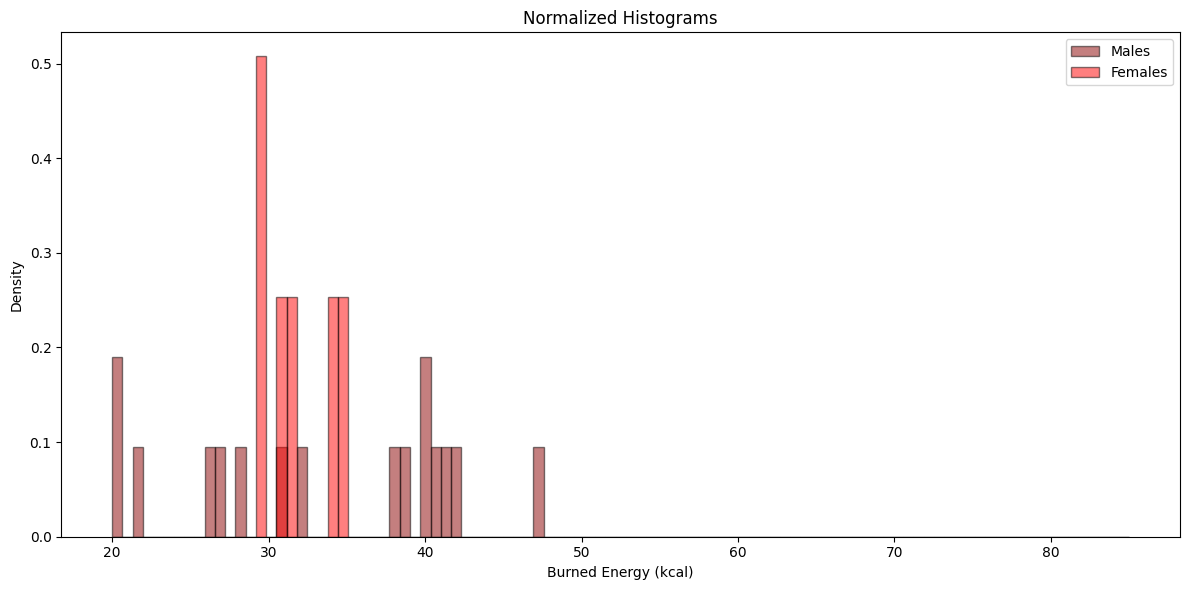

In [15]:
file_path = '/Users/tanjazast/Desktop/jupyter_folder/csv/final_data_07.06.csv'
df = pd.read_csv(file_path)

heart_rate_columns = [col for col in df.columns if col.startswith('Sum_Basal')]

# Process male data
male_data = df[df['gender'] == 'male']
male_heart_rate_data = male_data[heart_rate_columns]
flattened_male_data = male_heart_rate_data.values.flatten()
flattened_male_data = flattened_male_data[~pd.isnull(flattened_male_data) & (flattened_male_data != 0)]

# Process female data
female_data = df[df['gender'] == 'female']
female_heart_rate_data = female_data[heart_rate_columns]
flattened_female_data = female_heart_rate_data.values.flatten()
flattened_female_data = flattened_female_data[~pd.isnull(flattened_female_data) & (flattened_female_data != 0)]



# Compute histograms
bins = np.linspace(20, 85, 100)
male_hist, _ = np.histogram(flattened_male_data, bins=bins, density=True)
female_hist, _ = np.histogram(flattened_female_data, bins=bins, density=True)

bins = np.linspace(20, 85, 100)
male_hist, _ = np.histogram(flattened_male_data, bins=bins, density=True)
female_hist, _ = np.histogram(flattened_female_data, bins=bins, density=True)

male_hist += 1e-10
female_hist += 1e-10

cross_entropy = entropy(male_hist, female_hist)
print(cross_entropy)
print(f"Cross Entropy between male and female heart rates: {cross_entropy:.4f}")
red_tones = ['#FF0000', '#8B0000']
plt.figure(figsize=(12, 6))
plt.hist(flattened_male_data, bins=bins, alpha=0.5, color=red_tones[1], label='Males', edgecolor='black', density = True)
plt.hist(flattened_female_data, bins=bins, alpha=0.5, color=red_tones[0], label='Females', edgecolor='black', density = True)
plt.title('Normalized Histograms')
plt.xlabel('Burned Energy (kcal)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.savefig('CrossEntro_BasalEnergyBurned_all.png')
plt.show()

In [12]:
file_path = '/Users/tanjazast/Desktop/jupyter_folder/csv/final_data_07.06.csv'
df = pd.read_csv(file_path)

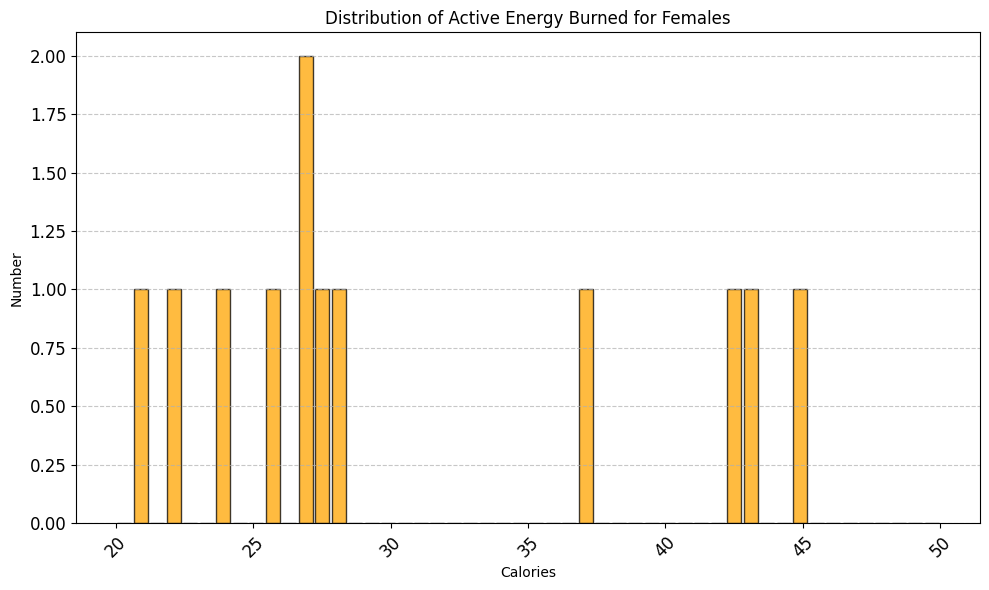

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

male_data = df[df['gender'] == 'female']

# Alle Spalten, die mit "HeartRate" anfangen, auswählen
activeEnergy_columns = [col for col in df.columns if col.startswith('Sum_ActiveEnergy')]

# Daten der ausgewählten Spalten für männliche Probanden
female_active_energy_data = female_data[activeEnergy_columns]

# Daten in eine flache Struktur umwandeln und NaN-Werte entfernen
flattened_data = female_active_energy_data.values.flatten()
flattened_data = flattened_data[~pd.isnull(flattened_data)]

# Histogramm der Herzfrequenzwerte plotten
plt.figure(figsize=(10, 6))
plt.hist(flattened_data, bins=50, range=(20, 50), alpha=0.75, color='orange', edgecolor='black', rwidth=0.85)
plt.title('Distribution of Active Energy Burned for Females')
plt.xlabel('Calories')
plt.ylabel('Number')
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Dist_ActiveEnergy_Females.png')
plt.show()

Cross Entropy between male and female active energy burned: 9.8469


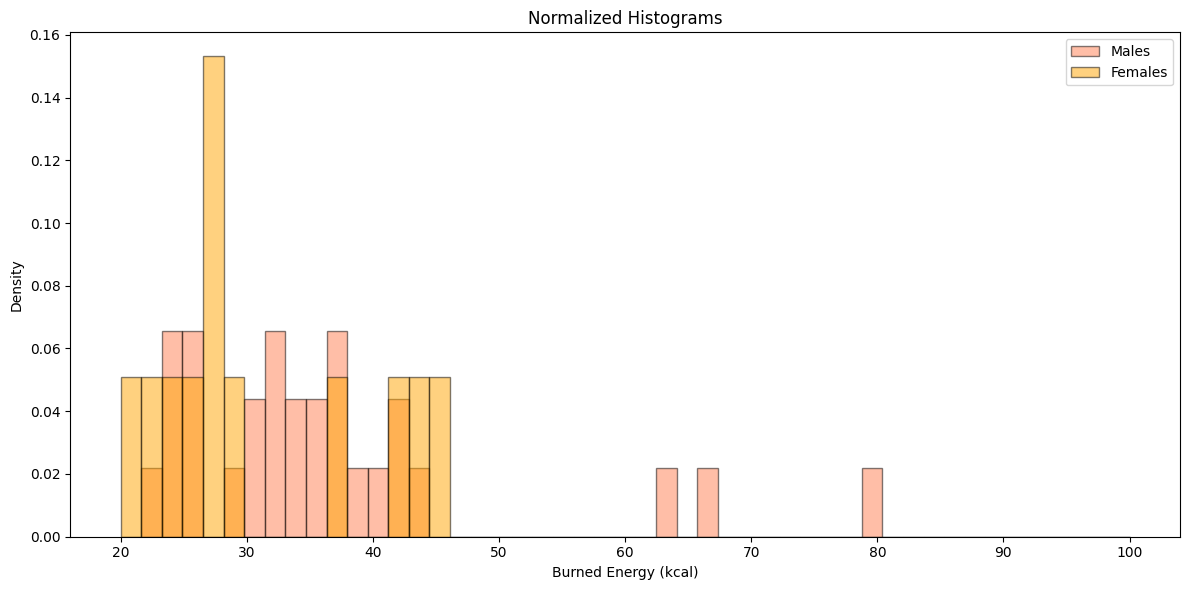

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import entropy

# Load the CSV file
file_path = '/Users/tanjazast/Desktop/jupyter_folder/csv/final_data_07.06.csv'
df = pd.read_csv(file_path)

heart_rate_columns = [col for col in df.columns if col.startswith('Sum_ActiveEnergy')]

# Process male data
male_data = df[df['gender'] == 'male']
male_heart_rate_data = male_data[heart_rate_columns]
flattened_male_data = male_heart_rate_data.values.flatten()
flattened_male_data = flattened_male_data[~pd.isnull(flattened_male_data) & (flattened_male_data != 0)]

# Process female data
female_data = df[df['gender'] == 'female']
female_heart_rate_data = female_data[heart_rate_columns]
flattened_female_data = female_heart_rate_data.values.flatten()
flattened_female_data = flattened_female_data[~pd.isnull(flattened_female_data)& (flattened_female_data != 0)]

# Compute histograms
bins = np.linspace(20, 100, 50)
male_hist, _ = np.histogram(flattened_male_data, bins=bins, density=True)
female_hist, _ = np.histogram(flattened_female_data, bins=bins, density=True)

male_hist += 1e-10
female_hist += 1e-10

# Compute cross entropy
cross_entropy = entropy(male_hist, female_hist)
print(f"Cross Entropy between male and female active energy burned: {cross_entropy:.4f}")
orange_tones = ['#FFA500', '#FF7F50']
# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(flattened_male_data, bins=bins, alpha=0.5, color=orange_tones[1], label='Males', edgecolor='black', density = True)
plt.hist(flattened_female_data, bins=bins, alpha=0.5, color=orange_tones[0], label='Females', edgecolor='black', density = True)
plt.title('Normalized Histograms')
plt.xlabel('Burned Energy (kcal)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.savefig('CrossEntro_ActiveEnergyBurned_all.png')
plt.show()

In [136]:
df = pd.read_csv('/Users/tanjazast/Desktop/jupyter_folder/csv/final_data_07.06.csv')

    Sum_DistanceWalkingRunning
0                    850.67800
1                   1033.02000
2                   1195.50120
3                   1162.97750
4                    615.59000
7                    961.20000
10                   836.68570
11                   634.39400
12                   581.97230
13                     9.17150
14                   985.32450
15                   913.75600
17                  1018.30750
18                   903.33765
20                   736.79700
22                   926.54260
23                   866.75450
25                   989.01750
26                   852.04400
27                  1116.27750
28                   817.52050
29                   796.80050
30                   730.93500
32                   759.43750
33                   831.33000
34                  1133.68850
40                   852.94150
41                   991.95300
42                   907.46200
44                  1285.56800


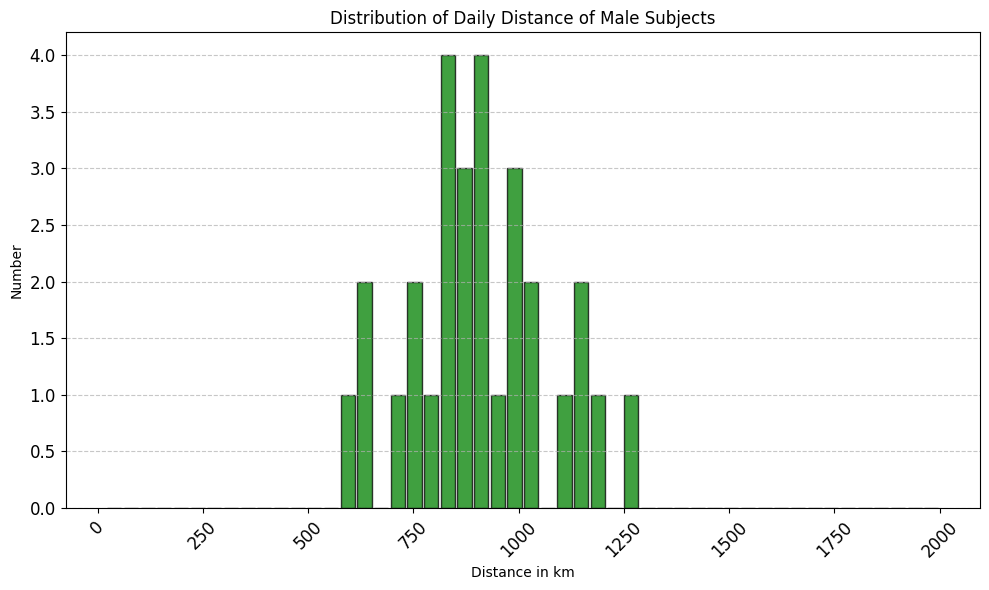

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

male_data = df[df['gender'] == 'male']

# Alle Spalten, die mit "HeartRate" anfangen, auswählen
heart_rate_columns = [col for col in df.columns if col.startswith('Sum_Di')]

# Daten der ausgewählten Spalten für männliche Probanden
male_heart_rate_data = male_data[heart_rate_columns]*1000
print(male_heart_rate_data)

# Daten in eine flache Struktur umwandeln und NaN-Werte entfernen
flattened_data = male_heart_rate_data.values.flatten()
flattened_data = flattened_data[~pd.isnull(flattened_data)]

# Histogramm der Herzfrequenzwerte plotten
plt.figure(figsize=(10, 6))
plt.hist(flattened_data, bins=50, range=(20, 2000), alpha=0.75, color='green', edgecolor='black', rwidth=0.85)
plt.title('Distribution of Daily Distance of Male Subjects')
plt.xlabel('Distance in km')
plt.ylabel('Number')
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Dist_Dist_Males.png')
plt.show()

    Sum_DistanceWalkingRunning
5                    1614.3715
6                     666.5423
8                     813.4865
9                     829.5485
16                   1042.2905
19                    671.6620
21                    946.0165
24                    804.0050
31                    707.0765
35                   1095.7000
36                    854.1305
37                    794.3170
38                    626.4050
39                    116.6084
43                   1044.6305


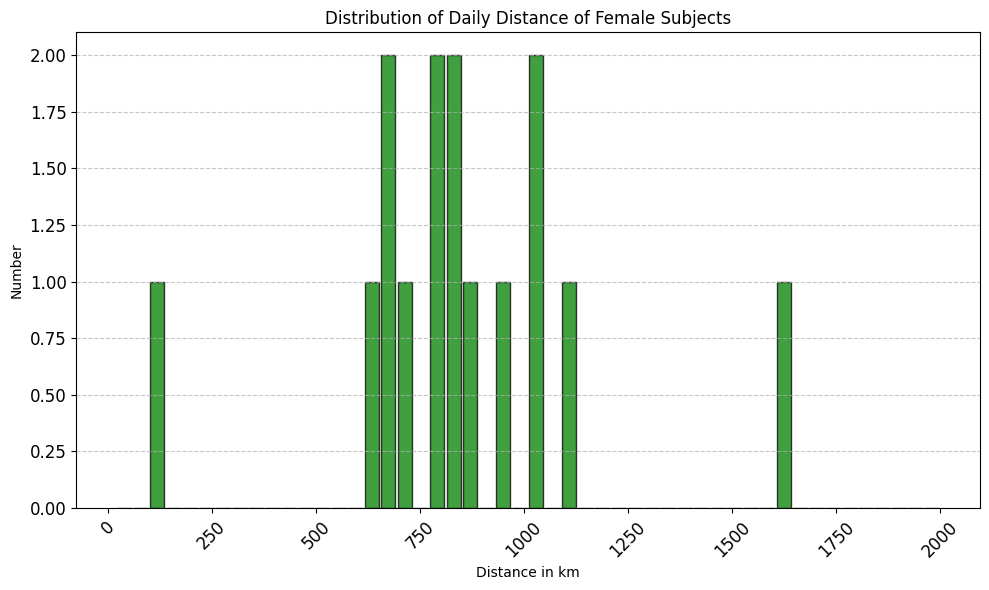

In [137]:
female_data = df[df['gender'] == 'female']

heart_rate_columns = [col for col in df.columns if col.startswith('Sum_Di')]

# Daten der ausgewählten Spalten für männliche Probanden
female_heart_rate_data = female_data[heart_rate_columns]*1000
print(female_heart_rate_data)

# Daten in eine flache Struktur umwandeln und NaN-Werte entfernen
flattened_data = female_heart_rate_data.values.flatten()
flattened_data = flattened_data[~pd.isnull(flattened_data)]


# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(flattened_data, bins=50, range=(20, 2000), alpha=0.75, color='green', edgecolor='black', rwidth=0.85)
plt.title('Distribution of Daily Distance of Female Subjects')
plt.xlabel('Distance in km')
plt.ylabel('Number')
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Dist_Dist_Females.png')
plt.show()

8.464768239138312
Cross Entropy between male and female heart rates: 8.4648


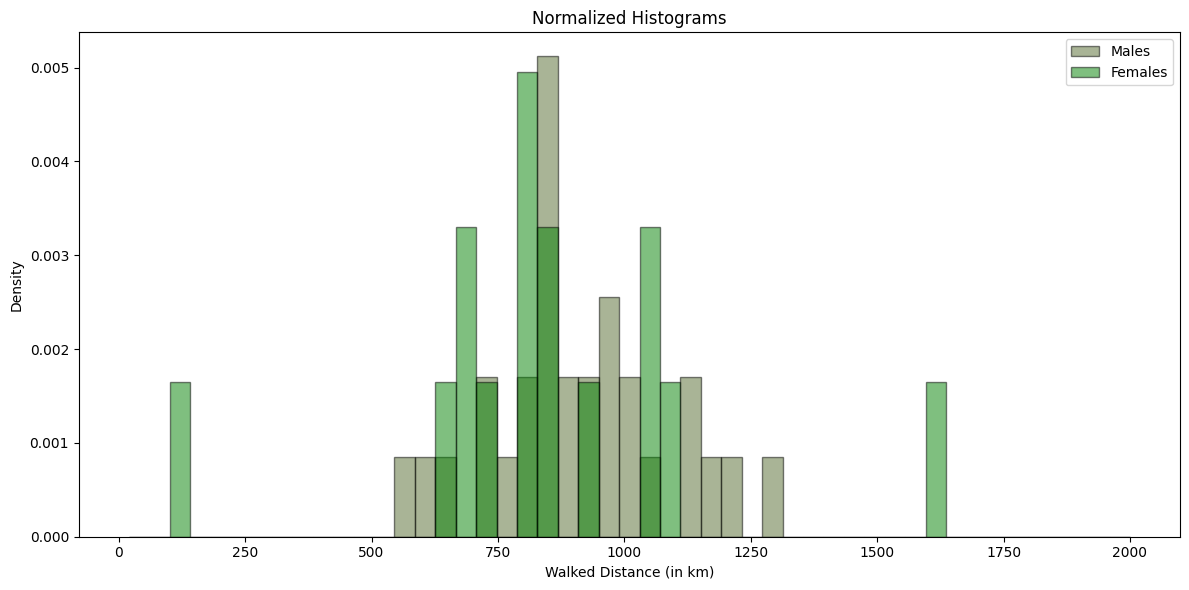

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import entropy

# Load the CSV file
file_path = '/Users/tanjazast/Desktop/jupyter_folder/csv/final_data_07.06.csv'
df = pd.read_csv(file_path)

heart_rate_columns = [col for col in df.columns if col.startswith('Sum_Di')]

# Process male data
male_data = df[df['gender'] == 'male']
male_heart_rate_data = male_data[heart_rate_columns]*1000
flattened_male_data = male_heart_rate_data.values.flatten()
flattened_male_data = flattened_male_data[~pd.isnull(flattened_male_data)& (flattened_male_data != 0)]

# Process female data
female_data = df[df['gender'] == 'female']
female_heart_rate_data = female_data[heart_rate_columns]*1000
flattened_female_data = female_heart_rate_data.values.flatten()
flattened_female_data = flattened_female_data[~pd.isnull(flattened_female_data)& (flattened_female_data != 0)]

# Compute histograms
bins = np.linspace(20, 2000, 50)
male_hist, _ = np.histogram(flattened_male_data, bins=bins, density=True)
female_hist, _ = np.histogram(flattened_female_data, bins=bins, density=True)

male_hist += 1e-10
female_hist += 1e-10

# Compute cross entropy
cross_entropy = entropy(male_hist, female_hist)
print(cross_entropy)
print(f"Cross Entropy between male and female heart rates: {cross_entropy:.4f}")
green_tones = ['#556B2F', '#008000']
# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(flattened_male_data, bins=bins, alpha=0.5, color=green_tones[0], label='Males', edgecolor='black', density = True)
plt.hist(flattened_female_data, bins=bins, alpha=0.5, color=green_tones[1], label='Females', edgecolor='black', density = True)
plt.title('Normalized Histograms')
plt.xlabel('Walked Distance (in km)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.savefig('CrossEntro_Distance_all.png')
plt.show()

In [110]:
import seaborn as sns


file_path = '/Users/tanjazast/Desktop/jupyter_folder/csv/final_data_07.06.csv'
df = pd.read_csv(file_path)

# Filtern der relevanten Spalten
heart_rate_columns = [col for col in df.columns if col.startswith('HeartRate')]

df = df[df['gender'] == 'female'][heart_rate_columns]

# Finden des maximalen und minimalen Wertes über alle HeartRate-Spalten
max_value = df[heart_rate_columns].max().max()
min_value = df[heart_rate_columns].min().min()

print(f'Maximum Heart Rate: {max_value}')
print(f'Minimum Heart Rate: {min_value}')

Maximum Heart Rate: 146.0
Minimum Heart Rate: 60.0


In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = '/Users/tanjazast/Desktop/jupyter_folder/csv/final_data_07.06.csv'
df = pd.read_csv(file_path)

# Filtern der relevanten Spalten
columns_to_keep = [col for col in df.columns if col.startswith('HR') or col.startswith('Heart')]
columns_to_keep.append('TimeStamp')
columns_to_keep.append('gender')

# DataFrame filtern nach 'male' und den relevanten Spalten
df = df[df['gender'] == 'female'][columns_to_keep]
print(df)

# Konvertieren der 'TimeStamp'-Spalte in datetime
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])

# Filtern der Daten für den 19.03.2024
df_filtered = df[df['TimeStamp'].dt.date == pd.Timestamp('2024-03-12').date()]
print(df_filtered)

# Alle Herzfrequenzwerte in ein Array packen und NaN-Werte ignorieren
heart_rate_columns = [col for col in df_filtered.columns if col.startswith('HR') or col.startswith('Heart')]
#heart_rate_columns = heart_rate_columns
print(heart_rate_columns)

    HeartRate_1  HeartRate_2  HeartRate_3  HeartRate_4  HeartRate_5  \
5         102.0        102.0        102.0        101.0        100.0   
6          98.0         97.0         97.0         99.0         99.0   
8          85.0         85.0         87.0         89.0         81.0   
9         134.0        133.0        129.0        129.0        131.0   
16        100.0        101.0         99.0         99.0        101.0   
19        130.0        132.0        131.0        136.0        137.0   
21        106.0        105.0         95.0         94.0         92.0   
24         82.0         86.0         86.0         96.0         98.0   
31         91.0         88.0         88.0         89.0         90.0   
35         74.0         61.0         60.0         64.0         63.0   
36         79.0         74.0         74.0         74.0         73.0   
37        128.0        130.0        126.0        126.0        126.0   
38         84.0         85.0         85.0         85.0         86.0   
39    

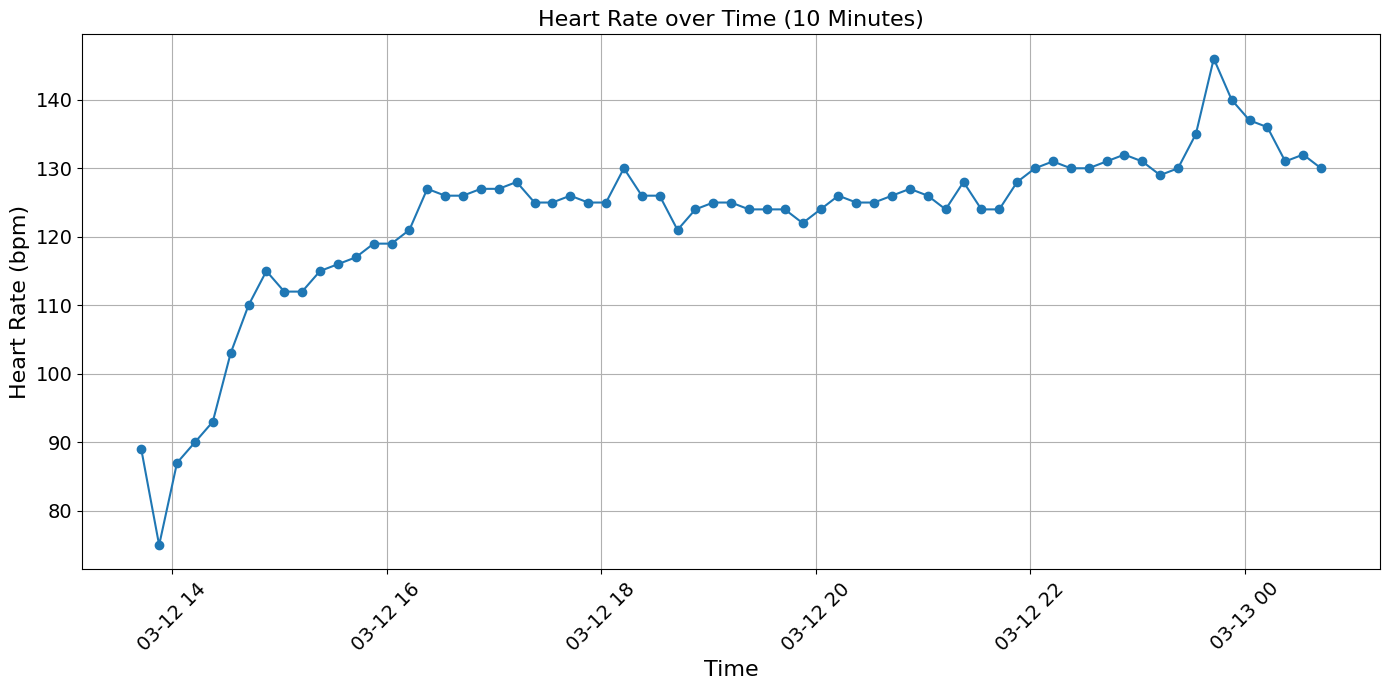

In [120]:
plt.figure(figsize=(14, 7))

# Nur die dritte Zeile plotten
row = df_filtered.iloc[0]
heart_rate_values = row[heart_rate_columns].dropna().values[::-1]  # Werte umkehren
timestamps = [row['TimeStamp'] - pd.Timedelta(minutes=5) + pd.Timedelta(minutes=10 * i) for i in range(len(heart_rate_values))]
plt.plot(timestamps, heart_rate_values, marker='o', linestyle='-')

plt.title('Heart Rate over Time (10 Minutes)', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Heart Rate (bpm)', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
plt.xticks(rotation=45)  # Drehen der x-Achsen-Beschriftungen, falls nötig
plt.tight_layout()  # Verbessert das Layout bei Überlappungen
plt.savefig('HeartRate1day_Subject_female.png')
plt.show()

In [86]:
import pandas as pd

file_path = '/Users/tanjazast/Desktop/jupyter_folder/csv/apple_export_Michi2024-02-07.csv'

# Laden der Daten und Konvertierung des Datumsformats
df = pd.read_csv(file_path, parse_dates=['startDate'])
df['value'] = pd.to_numeric(df['value'], errors='coerce').fillna(0)
# Filtern der Daten für den 10.10.2023
start_date = '2023-10-10 05'
end_date = '2023-10-10 20'  # Da es sich um ein 24-Stunden-Intervall handelt, können wir den nächsten Tag als Enddatum verwenden
data_10_10_2023 = df[(df['startDate'] >= start_date) & (df['startDate'] < end_date)]
heart = data_10_10_2023[data_10_10_2023['type'] == 'HeartRate']

# Anzeigen der gefilterten Daten
print(data_10_10_2023)
print(heart)

/var/folders/y1/pjhgyq7s17zfyt6wmlhs0jq40000gn/T/ipykernel_2546/2990518042.py:6: DtypeWarning: Columns (0,1,2,3,5,6,7,10,11,14,15,17,18,20,21,22,25,27,30,31,32,33,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, parse_dates=['startDate'])


                          type             sourceName       value        unit  \
611243  DistanceWalkingRunning  Michael’s Apple Watch    0.023803          km   
611244               StepCount  Michael’s Apple Watch   33.000000       count   
611245  DistanceWalkingRunning       Michael’s iPhone    0.047956          km   
611246               StepCount       Michael’s iPhone   52.000000       count   
611247          PhysicalEffort  Michael’s Apple Watch    1.700000  kcal/hr·kg   
...                        ...                    ...         ...         ...   
621720               StepCount       Michael’s iPhone  109.000000       count   
621721      ActiveEnergyBurned  Michael’s Apple Watch    5.608000        kcal   
621722       BasalEnergyBurned  Michael’s Apple Watch    7.833000        kcal   
621723          PhysicalEffort  Michael’s Apple Watch    1.300000  kcal/hr·kg   
621724          AppleStandHour  Michael’s Apple Watch    0.000000         NaN   

                       star

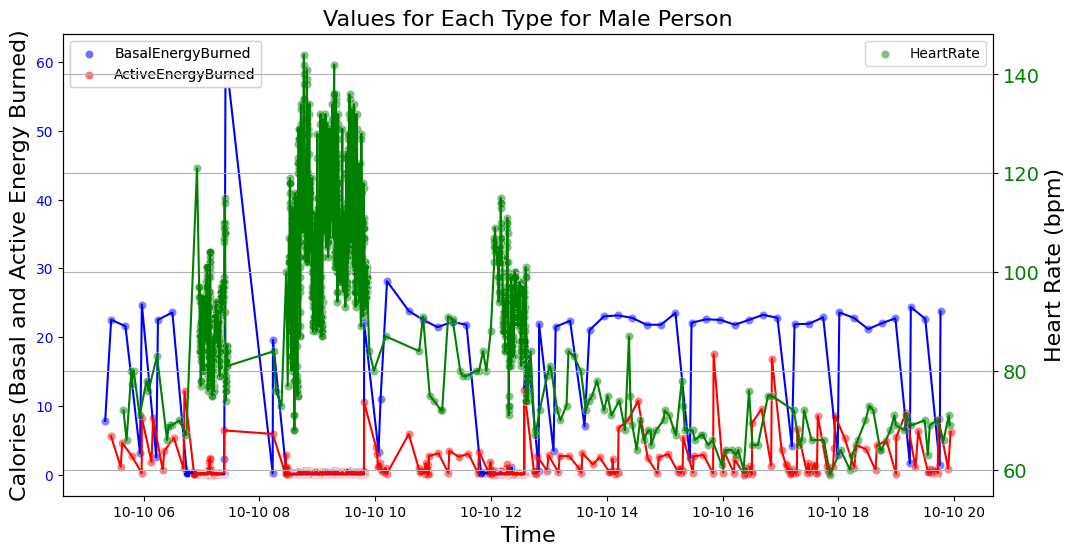

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Farben für jeden Typ definieren
colors = {'BasalEnergyBurned': 'blue', 'ActiveEnergyBurned': 'red', 'HeartRate': 'green'}

# Erstellen einer Figur für das Plotten
fig, ax1 = plt.subplots(figsize=(12, 6))

# Filtern der Daten nach Typ
data_10_10_2023 = data_10_10_2023[data_10_10_2023['value'] > 0]

# Plotten der Datenpunkte und der Mittelwertlinien für BasalEnergyBurned und ActiveEnergyBurned auf ax1
for type_name in ['BasalEnergyBurned', 'ActiveEnergyBurned']:
    type_data = data_10_10_2023[data_10_10_2023['type'] == type_name]
    
    # Scatterplot für BasalEnergyBurned und ActiveEnergyBurned
    sns.scatterplot(x=type_data['startDate'], y=type_data['value'], color=colors[type_name], label=type_name, alpha=0.5, ax=ax1)
    
    # Berechnung und Plotten der Mittelwertlinie
    mean_line = type_data.groupby('startDate')['value'].mean().reset_index()
    sns.lineplot(x=mean_line['startDate'], y=mean_line['value'], color=colors[type_name], ax=ax1)

# Y-Achse für Kalorien
ax1.set_ylabel('Calories (Basal and Active Energy Burned)', fontsize=16)
ax1.set_xlabel('Time', fontsize=16)
ax1.tick_params(axis='y', labelcolor=colors['BasalEnergyBurned'])

# Erstellen einer zweiten Y-Achse für HeartRate
ax2 = ax1.twinx()
type_data = data_10_10_2023[data_10_10_2023['type'] == 'HeartRate']

# Scatterplot für HeartRate
sns.scatterplot(x=type_data['startDate'], y=type_data['value'], color=colors['HeartRate'], label='HeartRate', alpha=0.5, ax=ax2)

# Berechnung und Plotten der Mittelwertlinie für HeartRate
mean_line = type_data.groupby('startDate')['value'].mean().reset_index()
sns.lineplot(x=mean_line['startDate'], y=mean_line['value'], color=colors['HeartRate'], ax=ax2)

# Y-Achse für Heart Rate
ax2.set_ylabel('Heart Rate (bpm)', fontsize=16)
ax2.tick_params(axis='y', labelcolor=colors['HeartRate'])

# Titel und Legende
plt.title('Values for Each Type for Male Person', fontsize=16)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend1 = ax1.legend(handles1, labels1, loc='upper left', fontsize=10)
legend2 = ax2.legend(handles2, labels2, loc='upper right', fontsize=10)
ax1.add_artist(legend1)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
plt.savefig('Values_Mean_Male.png')
plt.show()

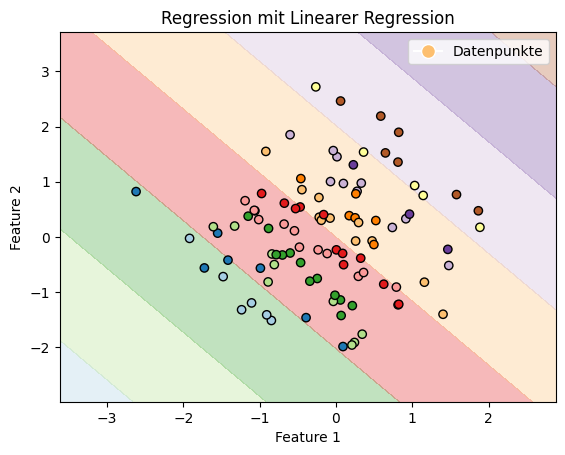

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

# Generiere ein einfaches Regressions-Dataset
X, y = make_regression(n_samples=100, n_features=2, noise=10, random_state=42)

# Trainiere einen linearen Regressionsmodells
reg = LinearRegression()
reg.fit(X, y)

# Erstelle ein Meshgrid zum Plotten der Vorhersagen
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Vorhersagen für jedes Punkt im Meshgrid
Z = reg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot der Regressionsfläche
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Regression mit Linearer Regression')

# Legende hinzufügen
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.Paired(0.5), markersize=10, label='Datenpunkte')])

plt.show()

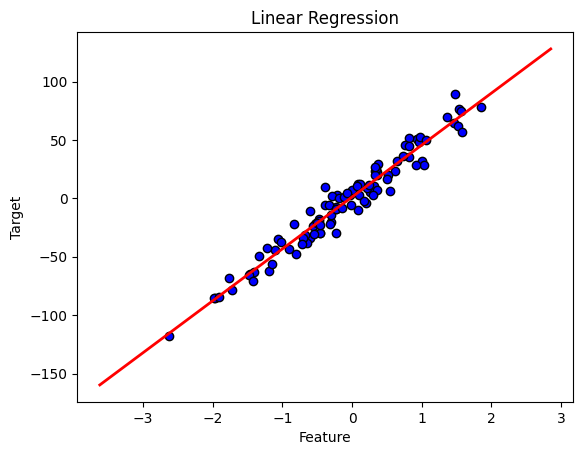

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

# Generiere ein einfaches Regressions-Dataset
X, y = make_regression(n_samples=100, n_features=1, noise=10, random_state=42)

# Trainiere einen linearen Regressionsmodells
reg = LinearRegression()
reg.fit(X, y)

# Erstelle einen Bereich für die Vorhersagen
x_min, x_max = X.min() - 1, X.max() + 1
x_range = np.linspace(x_min, x_max, 100)

# Vorhersagen für den Bereich
y_pred = reg.predict(x_range.reshape(-1, 1))

# Plot der Daten und der Regressionslinie
plt.scatter(X, y, color='blue', edgecolor='k')
plt.plot(x_range, y_pred, color='red', linewidth=2)
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('Linear Regression')
plt.savefig('linearregressionexample.png')

plt.show()

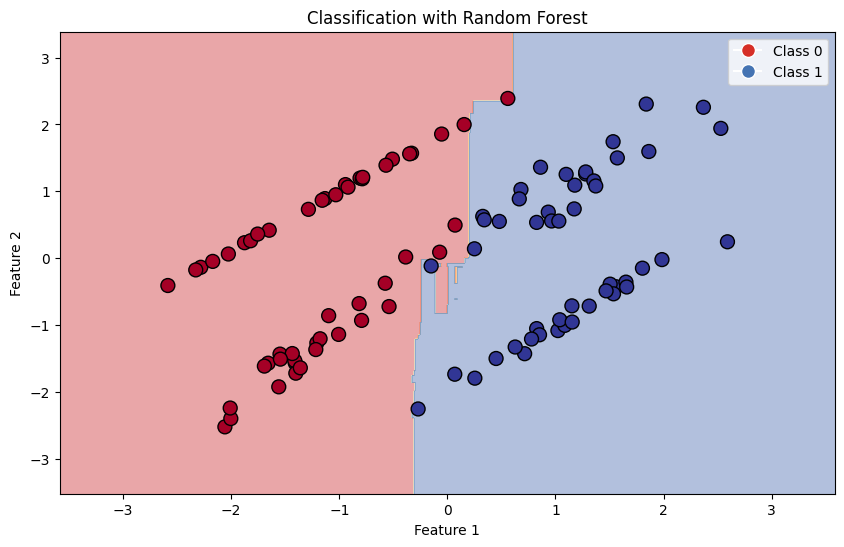

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# Generiere ein einfaches Klassifikations-Dataset
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=42)

# Trainiere einen Random Forest Klassifikator
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

# Erstelle ein Meshgrid zum Plotten der Entscheidungsgrenze
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Vorhersagen für jedes Punkt im Meshgrid
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot der Entscheidungsgrenze
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.RdYlBu, s=100, marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Classification with Random Forest')

# Legende hinzufügen
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.RdYlBu(0.1), markersize=10, label='Class 0'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.RdYlBu(0.9), markersize=10, label='Class 1')],
           loc='upper right')
plt.savefig('randomForestexample.png')

plt.show()

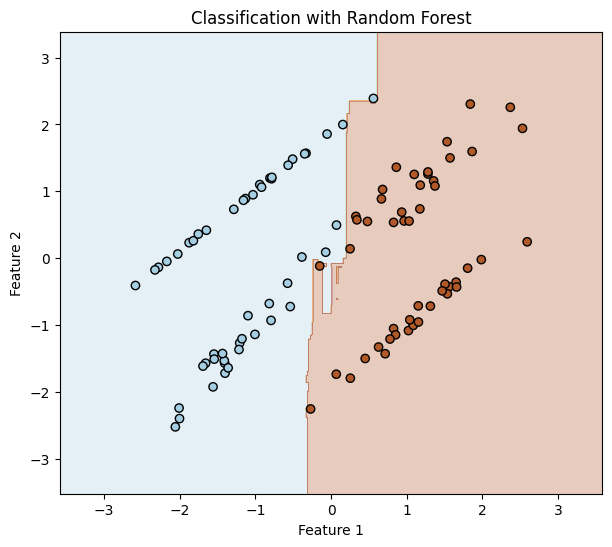

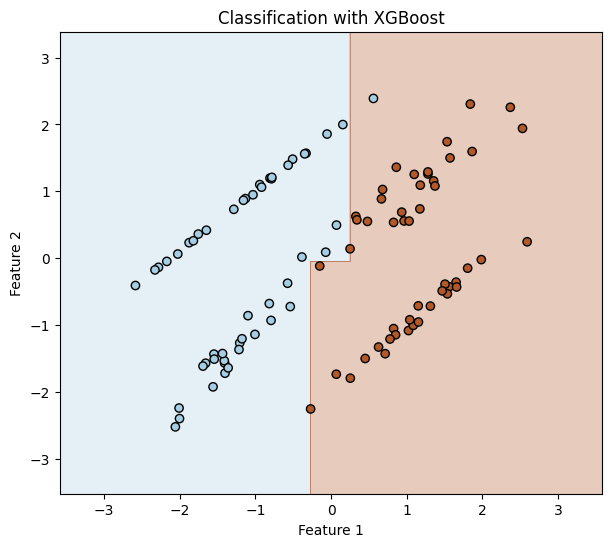

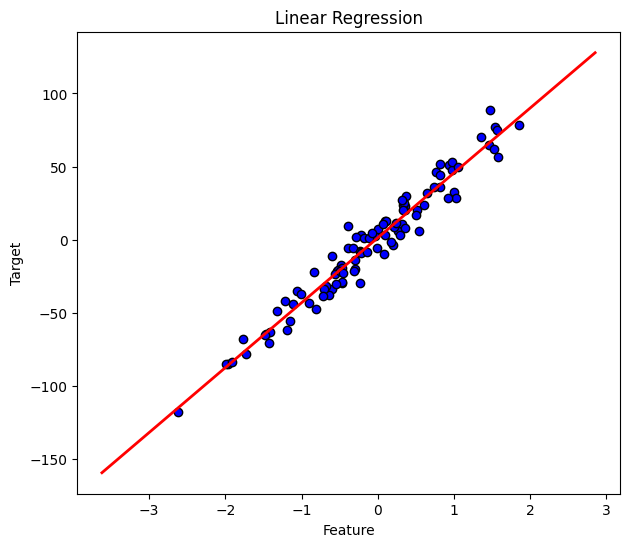

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier

# Generate a simple classification dataset
X_classification, y_classification = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=42)

# Generate a simple regression dataset
X_regression, y_regression = make_regression(n_samples=100, n_features=1, noise=10, random_state=42)

# Train a Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_classification, y_classification)

# Train an XGBoost Classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_classification, y_classification)

# Train a linear regression model
linear_reg = LinearRegression()
linear_reg.fit(X_regression, y_regression)

# Create a mesh grid for plotting decision boundaries for XGBoost and Random Forest
x_min, x_max = X_classification[:, 0].min() - 1, X_classification[:, 0].max() + 1
y_min, y_max = X_classification[:, 1].min() - 1, X_classification[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predictions for each point in the mesh grid
Z_rf = rf_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z_rf = Z_rf.reshape(xx.shape)

Z_xgb = xgb_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z_xgb = Z_xgb.reshape(xx.shape)

# Range for linear regression
x_range = np.linspace(X_regression.min() - 1, X_regression.max() + 1, 100)

# Predictions for the range
y_pred = linear_reg.predict(x_range.reshape(-1, 1))

# Plot for Random Forest
plt.figure(figsize=(7, 6))
plt.contourf(xx, yy, Z_rf, alpha=0.3, cmap=plt.cm.Paired)
plt.scatter(X_classification[:, 0], X_classification[:, 1], c=y_classification, edgecolor='k', cmap=plt.cm.Paired)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Classification with Random Forest')
plt.savefig('classification_with_random_forest.png')
plt.show()

# Plot for XGBoost
plt.figure(figsize=(7, 6))
plt.contourf(xx, yy, Z_xgb, alpha=0.3, cmap=plt.cm.Paired)
plt.scatter(X_classification[:, 0], X_classification[:, 1], c=y_classification, edgecolor='k', cmap=plt.cm.Paired)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Classification with XGBoost')
plt.savefig('classification_with_xgboost.png')
plt.show()

# Plot for linear regression
plt.figure(figsize=(7, 6))
plt.scatter(X_regression, y_regression, color='blue', edgecolor='k')
plt.plot(x_range, y_pred, color='red', linewidth=2)
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('Linear Regression')
plt.savefig('linear_regression.png')
plt.show()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


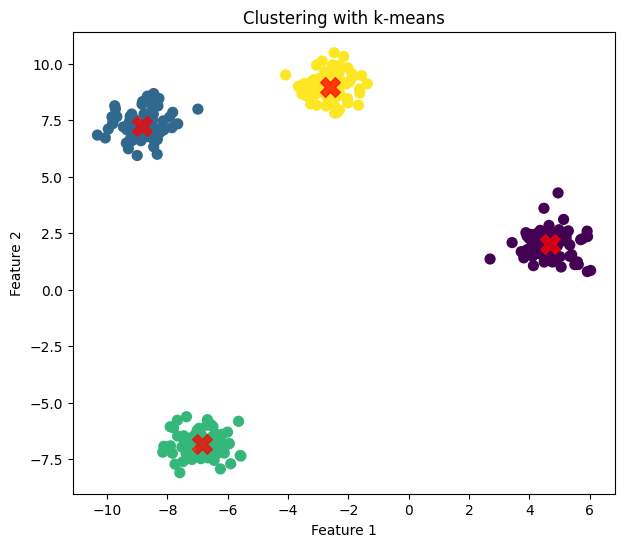

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Generiere ein einfaches Clustering-Dataset
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=42)

# Trainiere ein K-Means Clustering-Modell
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# Plot der Clustering-Ergebnisse
plt.figure(figsize=(7, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clustering with k-means')
plt.savefig('Clustering_Example.png')
plt.show()

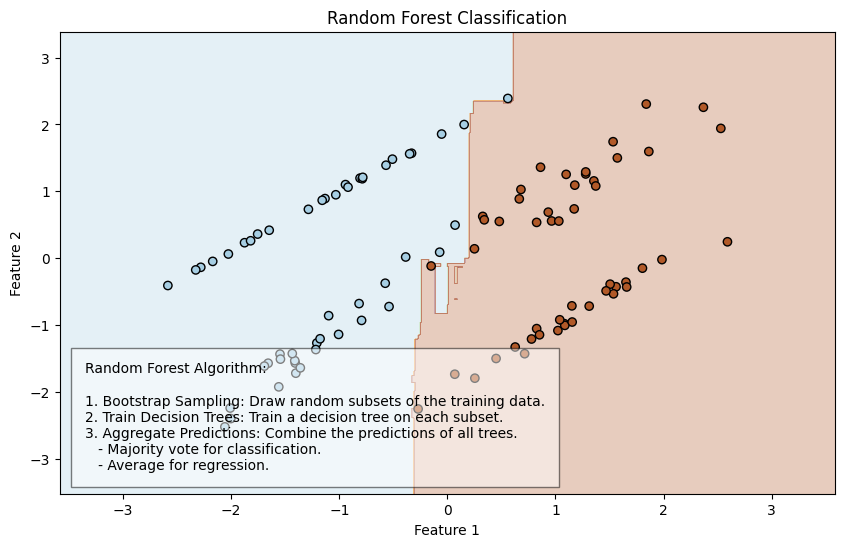

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# Generieren von synthetischen Daten
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=42)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Trainieren eines Random Forest Classifiers
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X, y)

# Vorhersagen für jedes Punkt im Meshgrid
Z = rf_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotten der Entscheidungsgrenzen und Datenpunkte
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Random Forest Classification')

# Erklärung des Random Forest Algorithmus
plt.figtext(0.15, 0.15, 'Random Forest Algorithm:\n\n'
                        '1. Bootstrap Sampling: Draw random subsets of the training data.\n'
                        '2. Train Decision Trees: Train a decision tree on each subset.\n'
                        '3. Aggregate Predictions: Combine the predictions of all trees.\n'
                        '   - Majority vote for classification.\n'
                        '   - Average for regression.',
            fontsize=10, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.show()


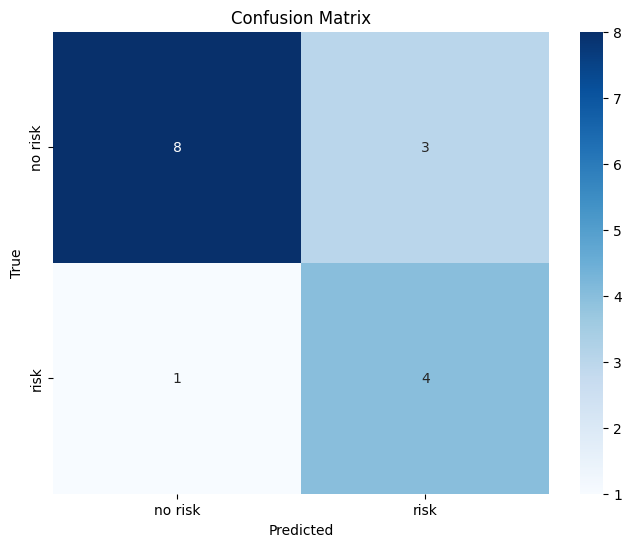

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Daten aus der Tabelle
labels = ['no risk', 'risk']
true_labels = [0] * 11 + [1] * 5
predicted_labels = [0] * 8 + [1] * 3 + [0] + [1] * 4

# Erstellen der Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Erstellen eines Heatmaps für die Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('Confusion Matrix risk 1')
plt.show()


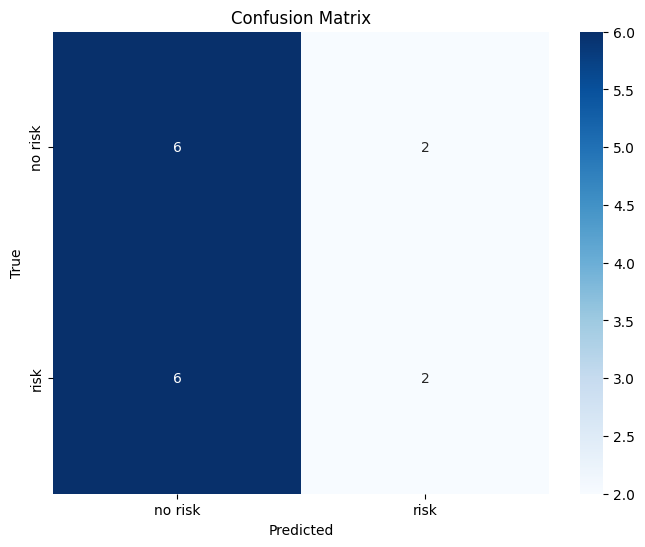

In [57]:
labels = ['no risk', 'risk']
true_labels = [0] * 8 + [1] * 8
predicted_labels = [0] * 6 + [1] * 2 + [0] * 6 + [1] * 2

# Erstellen der Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Erstellen eines Heatmaps für die Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('Confusion Matrix risk 2')
plt.show()